In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import random

In [11]:
def create_dummy_topology_data(num_rings=10, nodes_per_ring=10, logical_rings_per_physical=3):
    """
    Create dummy topology data for testing
    
    Args:
        num_rings: Number of physical rings to create
        nodes_per_ring: Number of nodes per ring
        logical_rings_per_physical: Number of logical rings per physical ring
        
    Returns:
        DataFrame with topology data
    """
    data = []
    
    for pr_idx in range(num_rings):
        physical_ring = f"RING_{pr_idx}"
        block_name = f"BLOCK_{pr_idx}"  # One block per physical ring
        
        # Each physical ring has multiple logical rings from the same block
        for lr_idx in range(logical_rings_per_physical):
            logical_ring = f"LR_{pr_idx}_{lr_idx}"
            
            # Create a linear path for each logical ring (not a complete ring)
            for i in range(nodes_per_ring - 1):  # Connect nodes in a path, not a ring
                node_a = f"NODE_{pr_idx}_{lr_idx}_{i}"
                node_b = f"NODE_{pr_idx}_{lr_idx}_{i+1}"
                
                data.append({
                    'aendname': node_a,
                    'bendname': node_b,
                    'aendip': f"10.{pr_idx}.{lr_idx}.{i}",
                    'bendip': f"10.{pr_idx}.{lr_idx}.{i+1}",
                    'aendifIndex': i,
                    'bendifIndex': i+1,
                    'block_name': block_name,
                    'physicalringname': physical_ring,
                    'lrname': logical_ring
                })
            
            # Connect the first and last nodes to the block
            # First node connects to block
            data.append({
                'aendname': f"NODE_{pr_idx}_{lr_idx}_0",
                'bendname': block_name,
                'aendip': f"10.{pr_idx}.{lr_idx}.0",
                'bendip': f"10.{pr_idx}.99.99",  # Special IP for block
                'aendifIndex': 100 + lr_idx,
                'bendifIndex': 100 + lr_idx,
                'block_name': block_name,
                'physicalringname': physical_ring,
                'lrname': logical_ring
            })
            
            # Last node connects to block
            data.append({
                'aendname': f"NODE_{pr_idx}_{lr_idx}_{nodes_per_ring-1}",
                'bendname': block_name,
                'aendip': f"10.{pr_idx}.{lr_idx}.{nodes_per_ring-1}",
                'bendip': f"10.{pr_idx}.99.99",  # Special IP for block
                'aendifIndex': 200 + lr_idx,
                'bendifIndex': 200 + lr_idx,
                'block_name': block_name,
                'physicalringname': physical_ring,
                'lrname': logical_ring
            })
    
    # Add connections between blocks from different physical rings
    # for pr_idx in range(num_rings):
    #     if pr_idx < num_rings - 1:  # Connect to next physical ring
    #         # Connect this block to the next ring's block
    #         block_a = f"BLOCK_{pr_idx}"
    #         block_b = f"BLOCK_{pr_idx+1}"
            
    #         data.append({
    #             'aendname': block_a,
    #             'bendname': block_b,
    #             'aendip': f"10.{pr_idx}.99.99",
    #             'bendip': f"10.{pr_idx+1}.99.99",
    #             'aendifIndex': 300 + pr_idx,
    #             'bendifIndex': 300 + pr_idx + 1,
    #             'block_name': block_a,
    #             'physicalringname': f"RING_{pr_idx}",
    #             'lrname': "INTER_BLOCK"  # Inter-block connection
    #         })
    
    return pd.DataFrame(data)

In [12]:
topo_data = create_dummy_topology_data()


In [8]:
def build_graph_with_position_features(topology_df):
    """Build NetworkX graph with enhanced position features"""
    G = nx.Graph()
    
    # Track ring membership and positions
    ring_positions = {}  # (pr_id, lr_id) -> list of positions
    
    # First pass: identify all rings and node positions
    for _, row in topology_df.iterrows():
        for node_col in ['aendname', 'bendname']:
            node = row[node_col]
            if not isinstance(node, str) or 'NODE_' not in node:
                continue
                
            parts = node.split('_')
            if len(parts) >= 4:
                try:
                    pr_id = int(parts[1])
                    lr_id = int(parts[2])
                    pos = int(parts[3])
                    
                    key = (pr_id, lr_id)
                    if key not in ring_positions:
                        ring_positions[key] = []
                    
                    if pos not in ring_positions[key]:
                        ring_positions[key].append(pos)
                except ValueError:
                    continue
    
    # Sort positions within each ring
    for key in ring_positions:
        ring_positions[key].sort()
    
    # Add nodes and edges with position-aware features
    for _, row in topology_df.iterrows():
        aend = row['aendname']
        bend = row['bendname']
        
        # Add nodes with enhanced features
        for node in [aend, bend]:
            if node in G:
                continue  # Skip if already added
                
            # Default features
            features = {
                'is_block': 'BLOCK' in str(node),
                'pr_id': -1,
                'lr_id': -1,
                'position': -1,
  
            }
            
            # Extract position information
            if isinstance(node, str) and 'NODE_' in node:
                parts = node.split('_')
                if len(parts) >= 4:
                    try:
                        pr_id = int(parts[1])
                        lr_id = int(parts[2])
                        pos = int(parts[3])
                        
                        # Get normalized position (crucial for learning the pattern)


                        
                        features.update({
                            'pr_id': pr_id,
                            'lr_id': lr_id,
                            'position': pos,

                        })
                    except ValueError:
                        pass
            
            G.add_node(node, **features)
        
        # Add edge
        G.add_edge(aend, bend)
    
    return G

In [5]:
G = build_graph_with_position_features(topo_data)

In [6]:
def add_failure_status_to_graph(G, failed_node_names=None):
    """Add 'failed' attribute to graph nodes"""
    if failed_node_names is None:
        failed_node_names = []
    
    # Create a copy to avoid modifying the original
    G_copy = G.copy()
    
    # Set failed attribute for all nodes
    for node in G_copy.nodes():
        G_copy.nodes[node]['failed'] = node in failed_node_names
    
    return G_copy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, DataLoader
import networkx as nx
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [8]:
class GraphStateGNN(nn.Module):
    def __init__(self, in_channels):
        super(GraphStateGNN, self).__init__()
        
        # Feature processing
        self.node_encoder = nn.Linear(in_channels, 64)
        
        # Graph convolution layers
        self.conv1 = GCNConv(64, 128)
        self.conv2 = GCNConv(128, 64)
        
        # Isolation prediction layer
        self.predictor = nn.Linear(64, 1)
    
    def forward(self, x, edge_index):
        """The first feature of x is the 'failed' status"""
        # Initial node encoding
        h = F.relu(self.node_encoder(x))
        
        # Message passing to understand graph structure
        h = F.relu(self.conv1(h, edge_index))
        h = F.dropout(h, p=0.2, training=self.training)
        
        h = F.relu(self.conv2(h, edge_index))
        
        # Predict isolation probability
        out = torch.sigmoid(self.predictor(h))
        
        # Make sure failed nodes are never predicted as isolated
        # failed status is the first feature (x[:, 0])
        failed_mask = (x[:, 0] < 0.5).float().unsqueeze(1)
        out = out * failed_mask
        
        return out

In [9]:
def calculate_isolated_nodes(G, node_list, node_to_idx):
    """Calculate which nodes are isolated based on graph failures"""
    y = torch.zeros(len(node_list), dtype=torch.float)
    
    for i, node in enumerate(node_list):
        # Skip failed nodes
        if G.nodes[node].get('failed', False):
            continue
            
        # Get node attributes
        attrs = G.nodes[node]
        pr_id = attrs.get('pr_id', -1)
        lr_id = attrs.get('lr_id', -1)
        pos = attrs.get('position', -1)
        
        if pr_id < 0 or lr_id < 0 or pos < 0:
            continue
        
        # Find failed nodes in same ring
        failed_in_ring = []
        for other_node in node_list:
            if not G.nodes[other_node].get('failed', False):
                continue
                
            other_attrs = G.nodes[other_node]
            other_pr = other_attrs.get('pr_id', -1)
            other_lr = other_attrs.get('lr_id', -1)
            other_pos = other_attrs.get('position', -1)
            
            # Check if in same ring
            if other_pr == pr_id and other_lr == lr_id and other_pos >= 0:
                failed_in_ring.append((other_node, other_pos))
        
        # Check if between any two failed nodes
        if len(failed_in_ring) >= 2:
            for i in range(len(failed_in_ring)):
                for j in range(i+1, len(failed_in_ring)):
                    pos1 = failed_in_ring[i][1]
                    pos2 = failed_in_ring[j][1]
                    
                    if min(pos1, pos2) < pos < max(pos1, pos2):
                        y[node_to_idx[node]] = 1.0
                        break
    
    return y

In [10]:
def prepare_data_from_graph(G):
    """Convert graph with failure attributes to PyG data"""
    from torch_geometric.data import Data
    
    # Create node mapping
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    # Create edge index
    edge_index = []
    for u, v in G.edges():
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        edge_index.append([node_to_idx[v], node_to_idx[u]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    
    # Create node features
    x = []
    failed_nodes = []
    for i, node in enumerate(node_list):
        attrs = G.nodes[node]
        
        # Get failed status as first feature
        is_failed = float(attrs.get('failed', False))
        if is_failed > 0.5:
            failed_nodes.append(i)
        
        features = [
            is_failed,                       # Failed status as first feature
            float(attrs.get('is_block', False)),
            attrs.get('pr_id', -1) / 10.0,
            attrs.get('lr_id', -1) / 10.0,
            attrs.get('position', -1) / 10.0,
        ]
        x.append(features)
    
    x = torch.tensor(x, dtype=torch.float)
    
    # Calculate isolated nodes (ground truth)
    y = calculate_isolated_nodes(G, node_list, node_to_idx)
    
    return Data(x=x, edge_index=edge_index, y=y)

In [11]:
def train_graph_state_model(graph_examples, num_epochs=30):
    """Train model on graphs with failed attributes"""
    from torch_geometric.loader import DataLoader
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Prepare training data
    train_data = [prepare_data_from_graph(G) for G in graph_examples]
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    
    # Create model
    in_channels = train_data[0].x.size(1)
    model = GraphStateGNN(in_channels).to(device)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Class weights
    pos_weight = torch.tensor([10.0]).to(device)
    
    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            out = model(batch.x, batch.edge_index)
            
            # Loss with weighting
            loss = F.binary_cross_entropy(
                out.squeeze(), 
                batch.y,
                weight=pos_weight * batch.y + (1.0 - batch.y)
            )
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Track predictions
            pred = (out.squeeze() > 0.5).float()
            all_preds.append(pred.detach().cpu())
            all_labels.append(batch.y.detach().cpu())
        
        # Calculate metrics
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        print(f"Epoch {epoch}/{num_epochs}:")
        print(f"  Loss: {total_loss/len(train_loader):.4f}")
        print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        print(f"  Predictions: {all_preds.sum().item()}/{len(all_preds)}")
    
    return model

In [16]:
def generate_graph_examples(G, num_examples=100):
    """Generate graphs with different failure patterns"""
    import random
    
    examples = []
    nodes = list(G.nodes())
    
    for _ in range(num_examples):
        # Randomly select 1-4 failed nodes
        num_failures = 2
        failed_nodes = random.sample(nodes, num_failures)
        
        # Create graph with these failures
        G_example = add_failure_status_to_graph(G, failed_nodes)
        
        # Add to examples
        examples.append(G_example)
    
    return examples

In [17]:
def predict_isolations(model, G):
    """Predict which nodes are isolated in a graph"""
    model.eval()
    device = next(model.parameters()).device
    
    # Prepare data
    data = prepare_data_from_graph(G)
    data = data.to(device)
    
    # Get node mapping
    node_list = list(G.nodes())
    
    # Make prediction
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        isolation_pred = (out.squeeze() > 0.5).cpu().numpy()
    
    # Get isolated nodes
    isolated_nodes = [node_list[i] for i, is_isolated in enumerate(isolation_pred) 
                     if is_isolated]
    
    return isolated_nodes

In [18]:
print("Generating training data...")
graph_examples = generate_graph_examples(G, num_examples=200)

# Train the model
print("Training model...")
model = train_graph_state_model(graph_examples)

# Create a test graph with specific failures
test_failures = ["NODE_0_0_2", "NODE_0_0_7"]
test_graph = add_failure_status_to_graph(G, test_failures)

# Predict isolations
print("\nPredicting isolations...")
isolated = predict_isolations(model, test_graph)

print(f"Failures: {test_failures}")
print(f"Isolated nodes: {len(isolated)}")
for node in isolated[:5]:
    print(f"- {node}")
if len(isolated) > 5:
    print(f"...and {len(isolated) - 5} more")

Generating training data...
Training model...
Epoch 1/30:
  Loss: 0.5981
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 2/30:
  Loss: 0.4847
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 3/30:
  Loss: 0.3464
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 4/30:
  Loss: 0.1888
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 5/30:
  Loss: 0.0772
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 6/30:
  Loss: 0.0317
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 7/30:
  Loss: 0.0212
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 8/30:
  Loss: 0.0190
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 9/30:
  Loss: 0.0193
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Predictions: 0.0/62000
Epoch 10/30:
  Loss: 0.0197
  Precision: 0.0000, Recal

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import networkx as nx
import pandas as pd
import random
import numpy as np

# Assuming your functions 'create_dummy_topology_data' and 'build_graph_with_position_features' are defined

# Create dummy data and graph
topology_df = create_dummy_topology_data(num_rings=10, nodes_per_ring=10, logical_rings_per_physical=3)
G_nx = build_graph_with_position_features(topology_df)

# Convert networkx graph to PyG Data object
def nx_to_pyg_data(G):
    # Map node features to vectors; here, we simply use a small feature vector based on our features
    mapping = {node: i for i, node in enumerate(G.nodes())}
    edge_index = []
    features = []
    for node, data in G.nodes(data=True):
        # Feature vector: [is_block, pr_id, lr_id, position]
        is_block = 1.0 if data.get('is_block', False) else 0.0
        pr_id = float(data.get('pr_id', -1))
        lr_id = float(data.get('lr_id', -1))
        position = float(data.get('position', -1))
        features.append([is_block, pr_id, lr_id, position])
    for u, v in G.edges():
        edge_index.append([mapping[u], mapping[v]])
        edge_index.append([mapping[v], mapping[u]])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(features, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    # Save mapping to refer back to node names if needed
    data.node_names = list(G.nodes())
    return data

data = nx_to_pyg_data(G_nx)

# Helper function: get ring membership based on node names and their features
def get_ring_id(node_name):
    # Assuming node_name format: "NODE_{pr}_{lr}_{pos}"
    parts = node_name.split('_')
    if len(parts) >= 4:
        return (int(parts[1]), int(parts[2]))
    return None

# Build a training dataset:
def create_training_sample(data, endpoints_per_sample=1):
    """
    For each training sample, we randomly select a ring, pick two endpoint nodes from that ring,
    and label nodes between them as class 1, others as class 0.
    """
    # Group nodes by ring using data.node_names and node feature information.
    ring_dict = {}
    for idx, node_name in enumerate(data.node_names):
        if "NODE_" in node_name:
            ring = get_ring_id(node_name)
            if ring is not None:
                ring_dict.setdefault(ring, []).append((idx, node_name))
    
    # Filter out rings with less than 2 nodes.
    rings = [nodes for nodes in ring_dict.values() if len(nodes) >= 2]
    if not rings:
        raise ValueError("Not enough nodes to form training samples.")
    
    # Select a random ring
    selected_ring = random.choice(rings)
    # Sort nodes in the ring by their position (extracted from the node name)
    selected_ring.sort(key=lambda x: int(x[1].split('_')[3]))
    # Randomly pick two endpoints ensuring the first is before the second
    i, j = sorted(random.sample(range(len(selected_ring)), 2))
    idx_a, name_a = selected_ring[i]
    idx_b, name_b = selected_ring[j]
    
    # Create labels for all nodes: label 1 if the node is in-between on the ring, else 0.
    labels = torch.zeros(data.num_nodes, dtype=torch.long)
    # Label the nodes in the selected ring between endpoints (including endpoints if desired)
    for idx, name in selected_ring[i:j+1]:
        labels[idx] = 1
    # Additionally, you can include the endpoints as context features if needed.
    return labels, (idx_a, idx_b)

# Create a simple dataset of training samples
class TopologyDataset(torch.utils.data.Dataset):
    def __init__(self, data, num_samples=1000):
        self.data = data
        self.num_samples = num_samples
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # For each sample, generate new labels and return the full graph with sample-specific labels
        labels, endpoints = create_training_sample(self.data)
        # endpoints can be used in a more complex model as additional input; here we just return them
        sample = {
            'data': self.data, 
            'labels': labels,
            'endpoints': endpoints
        }
        return sample

dataset = TopologyDataset(data, num_samples=500)
loader = DataLoader(dataset, batch_size=1)

# Define a simple GNN Model
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        # Node-level predictions
        out = self.lin(x)
        return out

# Instantiate model, loss and optimizer
model = GNNModel(in_channels=4, hidden_channels=16, out_channels=2)  # binary classification: in-between or not
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
def train(model, loader, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sample in loader:
            data_sample = sample['data'][0]  # since batch_size=1
            labels = sample['labels'][0]
            optimizer.zero_grad()
            out = model(data_sample)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(loader):.4f}")

train(model, loader)



/home/nms/.local/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1: Loss = 0.0822
Epoch 2: Loss = 0.0772
Epoch 3: Loss = 0.0788
Epoch 4: Loss = 0.0785
Epoch 5: Loss = 0.0751
Epoch 6: Loss = 0.0760
Epoch 7: Loss = 0.0786
Epoch 8: Loss = 0.0770
Epoch 9: Loss = 0.0777
Epoch 10: Loss = 0.0800
Epoch 11: Loss = 0.0755
Epoch 12: Loss = 0.0780
Epoch 13: Loss = 0.0758
Epoch 14: Loss = 0.0782
Epoch 15: Loss = 0.0767
Epoch 16: Loss = 0.0769
Epoch 17: Loss = 0.0765
Epoch 18: Loss = 0.0790
Epoch 19: Loss = 0.0782
Epoch 20: Loss = 0.0753
Epoch 21: Loss = 0.0773
Epoch 22: Loss = 0.0783
Epoch 23: Loss = 0.0778
Epoch 24: Loss = 0.0782
Epoch 25: Loss = 0.0784
Epoch 26: Loss = 0.0778
Epoch 27: Loss = 0.0797
Epoch 28: Loss = 0.0777
Epoch 29: Loss = 0.0782
Epoch 30: Loss = 0.0773
Epoch 31: Loss = 0.0763
Epoch 32: Loss = 0.0786
Epoch 33: Loss = 0.0789
Epoch 34: Loss = 0.0771
Epoch 35: Loss = 0.0763
Epoch 36: Loss = 0.0772
Epoch 37: Loss = 0.0794
Epoch 38: Loss = 0.0790
Epoch 39: Loss = 0.0785
Epoch 40: Loss = 0.0769
Epoch 41: Loss = 0.0771
Epoch 42: Loss = 0.0749
E

In [20]:
def create_training_sample_with_marked_endpoints(data, endpoints_per_sample=1):
    """
    Create a training sample with explicitly marked endpoint nodes
    """
    # Group nodes by ring using data.node_names and node feature information
    ring_dict = {}
    for idx, node_name in enumerate(data.node_names):
        if "NODE_" in node_name:
            ring = get_ring_id(node_name)
            if ring is not None:
                ring_dict.setdefault(ring, []).append((idx, node_name))
    
    # Filter out rings with less than 2 nodes
    rings = [nodes for nodes in ring_dict.values() if len(nodes) >= 2]
    if not rings:
        raise ValueError("Not enough nodes to form training samples.")
    
    # Select a random ring
    selected_ring = random.choice(rings)
    
    # Sort nodes in the ring by their position
    selected_ring.sort(key=lambda x: int(x[1].split('_')[3]))
    
    # Randomly pick two endpoints ensuring the first is before the second
    i, j = sorted(random.sample(range(len(selected_ring)), 2))
    idx_a, name_a = selected_ring[i]
    idx_b, name_b = selected_ring[j]
    
    # Create endpoint markers for all nodes (initialized to zeros)
    endpoint_features = torch.zeros((data.num_nodes, 2), dtype=torch.float)
    
    # Mark endpoint nodes - first endpoint gets [1,0], second gets [0,1]
    endpoint_features[idx_a, 0] = 1.0
    endpoint_features[idx_b, 1] = 1.0
    
    # Create labels for nodes (1 if between endpoints, 0 otherwise)
    labels = torch.zeros(data.num_nodes, dtype=torch.long)
    
    # Label nodes between endpoints (not including endpoints themselves)
    for idx, name in selected_ring[i+1:j]:
        labels[idx] = 1
    
    # Create a copy of the data with added endpoint features
    new_x = torch.cat([data.x, endpoint_features], dim=1)
    new_data = Data(x=new_x, edge_index=data.edge_index)
    new_data.node_names = data.node_names
    
    return new_data, labels, (idx_a, idx_b)

In [21]:
class EnhancedTopologyDataset(torch.utils.data.Dataset):
    def __init__(self, base_data, num_samples=1000):
        self.base_data = base_data
        self.num_samples = num_samples
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # For each sample, generate new data with marked endpoints and labels
        data_with_endpoints, labels, endpoints = create_training_sample_with_marked_endpoints(self.base_data)
        
        sample = {
            'data': data_with_endpoints, 
            'labels': labels,
            'endpoints': endpoints
        }
        return sample

In [22]:
class EndpointAwareGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EndpointAwareGNN, self).__init__()
        # in_channels now includes the 2 additional endpoint marker features
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.attention = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Sigmoid()
        )
        self.lin = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        
        # Node-level predictions
        out = self.lin(x)
        return out

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train_endpoint_aware(model, loader, epochs=50):
    model.train()
    
    # Use Adam optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    for epoch in range(epochs):
        total_loss = 0
        all_preds = []
        all_labels = []
        
        for sample in loader:
            # Get data with endpoints already marked in features
            data_sample = sample['data'][0]  # since batch_size=1
            labels = sample['labels'][0]
            endpoints = sample['endpoints'][0]
            
            # Forward pass
            optimizer.zero_grad()
            out = model(data_sample)
            
            # Get predictions
            _, pred = out.max(dim=1)
            
            # Store predictions and labels for metrics calculation
            all_preds.append(pred.cpu())
            all_labels.append(labels.cpu())
            
            # Compute loss
            loss = criterion(out, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Concatenate all predictions and labels
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(loader):.4f}")
        print(f"  Accuracy = {accuracy:.4f}, Precision = {precision:.4f}")
        print(f"  Recall = {recall:.4f}, F1 Score = {f1:.4f}")
        # Save the model weights
        model_save_path = 'trained_gnn_model.pt'
        torch.save(model.state_dict(), model_save_path)
        print(f"  Model saved to {model_save_path}")




In [31]:
# Create the base data object
data = nx_to_pyg_data(G_nx)

# Create the enhanced dataset
dataset = EnhancedTopologyDataset(data, num_samples=500)
loader = DataLoader(dataset, batch_size=1)

# Create model with additional endpoint features
model = EndpointAwareGNN(
    in_channels=data.x.size(1) + 2,  # Original features + 2 endpoint markers
    hidden_channels=32, 
    out_channels=2
)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train the model
train_endpoint_aware(model, loader, epochs=50)

/home/nms/.local/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1: Loss = 0.0543
  Accuracy = 0.9895, Precision = 0.0199
  Recall = 0.0036, F1 Score = 0.0061
  Model saved to trained_gnn_model.pt
Epoch 2: Loss = 0.0348
  Accuracy = 0.9912, Precision = 0.0000
  Recall = 0.0000, F1 Score = 0.0000
  Model saved to trained_gnn_model.pt
Epoch 3: Loss = 0.0326
  Accuracy = 0.9911, Precision = 0.0000
  Recall = 0.0000, F1 Score = 0.0000
  Model saved to trained_gnn_model.pt
Epoch 4: Loss = 0.0326
  Accuracy = 0.9912, Precision = 0.0000
  Recall = 0.0000, F1 Score = 0.0000
  Model saved to trained_gnn_model.pt
Epoch 5: Loss = 0.0291
  Accuracy = 0.9919, Precision = 0.0000
  Recall = 0.0000, F1 Score = 0.0000
  Model saved to trained_gnn_model.pt
Epoch 6: Loss = 0.0322
  Accuracy = 0.9909, Precision = 0.0000
  Recall = 0.0000, F1 Score = 0.0000
  Model saved to trained_gnn_model.pt
Epoch 7: Loss = 0.0302
  Accuracy = 0.9912, Precision = 0.0000
  Recall = 0.0000, F1 Score = 0.0000
  Model saved to trained_gnn_model.pt
Epoch 8: Loss = 0.0286
  Accuracy 

KeyboardInterrupt: 

In [28]:
def infer_for_specific_nodes(model, data, node_indices):
    """
    Get predictions for specific nodes from an already prepared graph
    
    Args:
        model: Trained GNNModel
        data: PyG Data object containing the graph
        node_indices: Indices of the nodes to get predictions for
        
    Returns:
        Tensor of predictions for specified nodes
    """
    model.eval()
    
    with torch.no_grad():
        # Forward pass on the entire graph
        all_node_predictions = model(data)
        
        # Extract only the predictions for specified nodes
        node_predictions = all_node_predictions[node_indices]
    
    return node_predictions

In [32]:
# Load your trained model
model = GNNModel(in_channels=5, hidden_channels=64, out_channels=1)
model.load_state_dict(torch.load('trained_gnn_model.pt'))

# Define input nodes
node1 = "NODE_0_0_2"
node2 = "NODE_0_0_7"

# Make predictions
results = predict_for_two_nodes(model, G, node1, node2)

# Print results
print(f"Input nodes: {results['input_nodes']}")
print(f"Affected nodes: {len(results['affected_nodes'])}")
for node, prob in results['affected_nodes'][:5]:
    print(f"- {node}: {prob:.4f}")

RuntimeError: Error(s) in loading state_dict for GNNModel:
	Unexpected key(s) in state_dict: "attention.0.weight", "attention.0.bias", "attention.2.weight", "attention.2.bias". 
	size mismatch for conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for conv1.lin.weight: copying a param with shape torch.Size([32, 6]) from checkpoint, the shape in current model is torch.Size([64, 5]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for conv2.lin.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for lin.weight: copying a param with shape torch.Size([2, 32]) from checkpoint, the shape in current model is torch.Size([1, 64]).
	size mismatch for lin.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

In [15]:
from torch_geometric.loader import DataLoader  # Use PyG's DataLoader

class SingleGraphDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=1000, num_rings=10, nodes_per_ring=10, logical_rings_per_physical=3):
        # Create graph
        topology_df = create_dummy_topology_data(num_rings, nodes_per_ring, logical_rings_per_physical)
        self.G = build_graph_with_position_features(topology_df)
        self.num_samples = num_samples
        
        # Precompute static graph data
        self.node_list = list(self.G.nodes())
        
        # Create node name to index mapping
        self.node_to_idx = {node: i for i, node in enumerate(self.node_list)}
        
        # Convert edges to index pairs
        edge_list = []
        for u, v in self.G.edges():
            edge_list.append([self.node_to_idx[u], self.node_to_idx[v]])
            edge_list.append([self.node_to_idx[v], self.node_to_idx[u]])
        
        self.edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        
        # Create node features
        node_features = []
        for node in self.node_list:
            attrs = self.G.nodes[node]
            features = [
                float(attrs.get('is_block', False)),
                attrs.get('pr_id', -1) / 10.0,
                attrs.get('lr_id', -1) / 10.0,
                attrs.get('position', -1) / 10.0,
            ]
            node_features.append(features)
        
        self.node_features = torch.tensor(node_features, dtype=torch.float)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Generate random sample using the static graph
        from torch_geometric.data import Data
        
        # Select random ring and two nodes
        rings = {}
        for node, data in self.G.nodes(data=True):
            pr_id = data.get('pr_id', -1)
            lr_id = data.get('lr_id', -1)
            if pr_id >= 0 and lr_id >= 0:
                key = (pr_id, lr_id)
                if key not in rings:
                    rings[key] = []
                rings[key].append((node, data.get('position', -1)))
        
        # Filter rings with enough nodes
        valid_rings = [nodes for nodes in rings.values() if len(nodes) >= 2]
        if not valid_rings:
            # Fallback if no valid rings
            return Data(x=self.node_features, edge_index=self.edge_index, 
                       y=torch.zeros(len(self.node_list), dtype=torch.long))
        
        # Select a random ring
        selected_ring = random.choice(valid_rings)
        
        # Sort by position
        selected_ring.sort(key=lambda x: x[1])
        
        # Pick two random nodes as endpoints
        if len(selected_ring) < 2:
            endpoint_indices = [0, 0]  # Fallback
        else:
            i, j = sorted(random.sample(range(len(selected_ring)), 2))
            endpoint_indices = [self.node_to_idx[selected_ring[i][0]], 
                              self.node_to_idx[selected_ring[j][0]]]
        
        # Create endpoint markers
        endpoint_markers = torch.zeros((len(self.node_list), 2), dtype=torch.float)
        endpoint_markers[endpoint_indices[0], 0] = 1.0
        endpoint_markers[endpoint_indices[1], 1] = 1.0
        
        # Combine features with endpoint markers
        x = torch.cat([self.node_features, endpoint_markers], dim=1)
        
        # Create labels - nodes between endpoints are isolated
        y = torch.zeros(len(self.node_list), dtype=torch.long)
        
        # Only label if we have two distinct endpoints
        if endpoint_indices[0] != endpoint_indices[1]:
            # Get all nodes in the ring
            ring_nodes = [self.node_to_idx[node] for node, _ in selected_ring]
            
            # Get min/max index in the sorted ring
            min_idx = min(endpoint_indices)
            max_idx = max(endpoint_indices)
            
            # Label nodes between endpoints in the ring
            ring_pos_dict = {self.node_to_idx[node]: pos for node, pos in selected_ring}
            min_pos = ring_pos_dict[min_idx]
            max_pos = ring_pos_dict[max_idx]
            
            for node_idx in ring_nodes:
                if node_idx in endpoint_indices:
                    continue
                pos = ring_pos_dict.get(node_idx, -1)
                if min_pos < pos < max_pos:
                    y[node_idx] = 1
        
        return Data(x=x, edge_index=self.edge_index, y=y, endpoints=torch.tensor(endpoint_indices))

In [16]:

# The GNN model remains the same as previous
class GNNModel(nn.Module):
    def __init__(self, feature_dim=6, hidden_dim=64, output_dim=1):
        super().__init__()
        self.conv1 = GATConv(feature_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.float()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.classifier(x)
        return torch.sigmoid(x.squeeze())

def train_single_graph():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create dataset
    dataset = SingleGraphDataset(num_samples=1000)
    
    # Use PyG's DataLoader
    from torch_geometric.loader import DataLoader
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Define model
    model = GNNModel(in_channels=dataset.node_features.size(1) + 2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(50):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            out = model(batch)
            
            # Get predictions
            _, pred = out.max(dim=1)
            
            # Store for metrics
            all_preds.append(pred.cpu())
            all_labels.append(batch.y.cpu())
            
            # Loss and backward
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Calculate metrics
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        
        from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        print(f"Epoch {epoch+1}:")
        print(f"  Loss = {total_loss/len(loader):.4f}")
        print(f"  Accuracy = {accuracy:.4f}, Precision = {precision:.4f}")
        print(f"  Recall = {recall:.4f}, F1 Score = {f1:.4f}")
        print(f"  Positive predictions: {all_preds.sum().item()}/{len(all_preds)}")

if __name__ == '__main__':
    train_single_graph()

TypeError: GNNModel.__init__() got an unexpected keyword argument 'in_channels'

In [53]:
import torch
from torch_geometric.data import Dataset, Data
import random

class NodeIsolationDataset(Dataset):
    def __init__(self,G_nx, num_samples=1000, transform=None, pre_transform=None):
        super(NodeIsolationDataset, self).__init__(None, transform, pre_transform)
        
        # Create base graph
        
        self.G = G_nx
        self.num_samples = num_samples
        
        # Create mapping from node names to indices
        self.node_list = list(self.G.nodes())
        self.node_to_idx = {node: i for i, node in enumerate(self.node_list)}
        
        # Extract ring information for easier access
        self.rings = {}
        for node, data in self.G.nodes(data=True):
            pr_id = data.get('pr_id')
            lr_id = data.get('lr_id')
            position = data.get('position')
            
            if (pr_id, lr_id) not in self.rings:
                self.rings[(pr_id, lr_id)] = []
            
            self.rings[(pr_id, lr_id)].append((node, position))
        
        # Pre-build edge index
        edge_index = []
        for src, dst in self.G.edges():
            src_idx = self.node_to_idx[src]
            dst_idx = self.node_to_idx[dst]
            edge_index.append([src_idx, dst_idx])
            edge_index.append([dst_idx, src_idx])  # Undirected graph
        
        self.edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        
        # Pre-build node features (without failure markers)
        base_features = []
        for node in self.node_list:
            data = self.G.nodes[node]
            features = [
                float(data.get('is_block', False)),
                data.get('pr_id', -1),  # Normalize
                data.get('lr_id', -1) ,  # Normalize
                data.get('position', -1),  # Normalize
            ]
            base_features.append(features)
        
        self.base_features = torch.tensor(base_features, dtype=torch.float)
    
    def len(self):
        return self.num_samples
    
    def get(self, idx):
        # Generate a new sample for each index
        # 1. Select a random ring
        valid_rings = [(pr_lr, nodes) for pr_lr, nodes in self.rings.items() if len(nodes) >= 3]
        
        if not valid_rings:
            # Fallback if no valid rings
            return Data(
                x=self.base_features, 
                edge_index=self.edge_index,
                y=torch.zeros(len(self.node_list), dtype=torch.long)
            )
        
        ring_key, ring_nodes = random.choice(valid_rings)
        
        # 2. Pick two random nodes from the ring to mark as failed
        sorted_ring_nodes = sorted(ring_nodes, key=lambda x: x[1])  # Sort by position
        
        if len(sorted_ring_nodes) < 2:
            # Safety check
            i, j = 0, 0
        else:
            i, j = sorted(random.sample(range(len(sorted_ring_nodes)), 2))
        
        # Get the failed nodes
        failed_node1, pos1 = sorted_ring_nodes[i]
        failed_node2, pos2 = sorted_ring_nodes[j]
        
        # Get indices in our node list
        failed_idx1 = self.node_to_idx[failed_node1]
        failed_idx2 = self.node_to_idx[failed_node2]
        
        # 3. Create failure marker features (2 additional features)
        failure_markers = torch.zeros((len(self.node_list), 2), dtype=torch.float)
        failure_markers[failed_idx1, 0] = 1.0  # First failed node
        failure_markers[failed_idx2, 1] = 1.0  # Second failed node
        
        # 4. Combine features
        x = torch.cat([self.base_features, failure_markers], dim=1)
        
        # 5. Create label tensor - nodes between the two failed nodes should be isolated
        y = torch.zeros(len(self.node_list), dtype=torch.long)
        
        # Only if nodes are in the same ring
        min_pos = min(pos1, pos2)
        max_pos = max(pos1, pos2)
        
        # Find nodes that should be isolated (in same ring with position between failed nodes)
        for node, pos in sorted_ring_nodes:
            if node in [failed_node1, failed_node2]:
                continue  # Skip failed nodes
            
            # Check if position is between the failed nodes
            if min_pos < pos < max_pos:
                # Mark as isolated (target = 1)
                node_idx = self.node_to_idx[node]
                y[node_idx] = 1
        
        # 6. Create and return Data object
        return Data(
            x=x,
            edge_index=self.edge_index,
            y=y,
            failed_nodes=torch.tensor([failed_idx1, failed_idx2], dtype=torch.long)
        )

In [54]:
class IsolationGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels=64):
        super(IsolationGNN, self).__init__()
        
        # GNN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        
        # FIXED: Specify the correct output dimensions and heads
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=2)
        
        # FIXED: Match the output dimensions from GAT (hidden_channels * heads)
        self.classifier = nn.Linear(hidden_channels * 2, 2)  # Binary classification
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First layer with ReLU activation
        h = torch.relu(self.conv1(x, edge_index))
        
        # Second layer
        h = self.conv2(h, edge_index)  # Output shape: [nodes, heads, hidden_channels]
        
        # FIXED: Handle output shape from GAT correctly
        # If h shape is [nodes, heads, features], reshape to [nodes, heads*features]
        if len(h.shape) == 3:
            batch_size, heads, features = h.shape
            h = h.reshape(batch_size, heads * features)
        
        # Final classification
        out = self.classifier(h)
        
        return out

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [55]:
def train_isolation_model(G_nx,num_epochs=30, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create dataset
    dataset = NodeIsolationDataset(G_nx,num_samples=1000)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Create model
    model = IsolationGNN(in_channels=dataset.base_features.size(1) + 2).to(device)
    
    # Optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 5.0]).to(device))  # Weight positive class higher
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            out = model(batch)
            
            # Compute loss
            loss = criterion(out, batch.y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Get predictions
            _, pred = out.max(dim=1)
            
            # Track predictions and labels for metrics
            all_preds.append(pred.cpu())
            all_labels.append(batch.y.cpu())
            
            total_loss += loss.item()
        
        # Combine predictions and labels
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Loss: {total_loss/len(loader):.4f}")
        print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"  Positive predictions: {all_preds.sum().item()}/{len(all_preds)}")
    
    return model

In [ ]:
def predict_isolated_nodes(model, graph, failed_node1, failed_node2):
    """
    Predict which nodes should be isolated when two nodes fail
    
    Args:
        model: Trained IsolationGNN model
        graph: NetworkX graph with node attributes
        failed_node1, failed_node2: Names of the two failed nodes
        
    Returns:
        List of node names predicted to be isolated
    """
    model.eval()
    
    # Convert graph to appropriate format
    node_list = list(graph.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    # Check if failed nodes exist in the graph
    if failed_node1 not in node_to_idx or failed_node2 not in node_to_idx:
        print(f"Error: One or both failed nodes not in graph")
        return []
    
    # Get indices of failed nodes
    failed_idx1 = node_to_idx[failed_node1]
    failed_idx2 = node_to_idx[failed_node2]
    
    # Create edge index
    edge_index = []
    for u, v in graph.edges():
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        edge_index.append([node_to_idx[v], node_to_idx[u]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    
    # Create node features
    base_features = []
    for node in node_list:
        data = graph.nodes[node]
        features = [
            float(data.get('is_block', False)),
            data.get('pr_id', -1) ,
            data.get('lr_id', -1),
            data.get('position', -1)
        ]
        base_features.append(features)
    
    base_features = torch.tensor(base_features, dtype=torch.float)
    
    # Create failure markers
    failure_markers = torch.zeros((len(node_list), 2), dtype=torch.float)
    failure_markers[failed_idx1, 0] = 1.0
    failure_markers[failed_idx2, 1] = 1.0
    
    # Combine features
    x = torch.cat([base_features, failure_markers], dim=1)
    
    # Create data object
    data = Data(x=x, edge_index=edge_index)
    
    # Make prediction
    with torch.no_grad():
        out = model(data)
        for i, node_name in enumerate(node_list):  # first 10 nodes
            print(f"{node_name}: {out[i].tolist()}")
        _, pred = out.max(dim=1)
    
    # Get isolated nodes
    isolated_indices = torch.nonzero(pred == 1).squeeze().tolist()
    
    # Convert to list if single item
    if not isinstance(isolated_indices, list):
        isolated_indices = [isolated_indices]
    
    # Convert to node names and exclude failed nodes
    isolated_nodes = [node_list[idx] for idx in isolated_indices 
                    if idx != failed_idx1 and idx != failed_idx2]
    
    return isolated_nodes

In [30]:
topo_data = create_dummy_topology_data()

In [13]:
G_nx = build_graph_with_position_features(topo_data)

In [56]:
model = train_isolation_model(G_nx,num_epochs=30, batch_size=32)

/home/nms/.local/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/30:
  Loss: 0.2472
  Accuracy: 0.9827, Precision: 0.0112
  Recall: 0.0109, F1 Score: 0.0110
  Positive predictions: 2687/310000
Epoch 2/30:
  Loss: 0.1916
  Accuracy: 0.9914, Precision: 0.0000
  Recall: 0.0000, F1 Score: 0.0000
  Positive predictions: 0/310000
Epoch 3/30:
  Loss: 0.1767
  Accuracy: 0.9918, Precision: 0.0000
  Recall: 0.0000, F1 Score: 0.0000
  Positive predictions: 0/310000
Epoch 4/30:
  Loss: 0.1706
  Accuracy: 0.9919, Precision: 0.0000
  Recall: 0.0000, F1 Score: 0.0000
  Positive predictions: 0/310000
Epoch 5/30:
  Loss: 0.1675
  Accuracy: 0.9919, Precision: 0.0000
  Recall: 0.0000, F1 Score: 0.0000
  Positive predictions: 0/310000
Epoch 6/30:
  Loss: 0.1652
  Accuracy: 0.9915, Precision: 0.0000
  Recall: 0.0000, F1 Score: 0.0000
  Positive predictions: 0/310000
Epoch 7/30:
  Loss: 0.1580
  Accuracy: 0.9917, Precision: 0.0000
  Recall: 0.0000, F1 Score: 0.0000
  Positive predictions: 0/310000
Epoch 8/30:
  Loss: 0.1424
  Accuracy: 0.9918, Precision: 0.0000
 

In [58]:
failed_node1 = "NODE_1_0_4"
failed_node2 = "NODE_1_0_6"
    
    # Predict isolated nodes
isolated = predict_isolated_nodes(model, G_nx, failed_node1, failed_node2)
print(f"\nNodes isolated by {failed_node1} and {failed_node2}:")
for node in isolated:
        print(f"- {node}")


NODE_0_0_0: [2.3151636123657227, -2.1297192573547363]
NODE_0_0_1: [2.1137428283691406, -1.9471200704574585]
NODE_0_0_2: [1.825444221496582, -1.6798732280731201]
NODE_0_0_3: [1.8049228191375732, -1.6564351320266724]
NODE_0_0_4: [1.7815285921096802, -1.6319700479507446]
NODE_0_0_5: [1.755421757698059, -1.606775164604187]
NODE_0_0_6: [1.7244935035705566, -1.5778577327728271]
NODE_0_0_7: [1.6938259601593018, -1.5495681762695312]
NODE_0_0_8: [1.9507694244384766, -1.7858049869537354]
NODE_0_0_9: [2.1780738830566406, -1.9944514036178589]
BLOCK_0: [2.6768946647644043, -2.457437753677368]
NODE_0_1_0: [2.3206024169921875, -2.137464761734009]
NODE_0_1_1: [2.1223325729370117, -1.9592417478561401]
NODE_0_1_2: [1.8352240324020386, -1.6932729482650757]
NODE_0_1_3: [1.8099979162216187, -1.6647611856460571]
NODE_0_1_4: [1.78563392162323, -1.638372778892517]
NODE_0_1_5: [1.7629214525222778, -1.6152315139770508]
NODE_0_1_6: [1.7371735572814941, -1.590527892112732]
NODE_0_1_7: [1.7101103067398071, -1.5653

In [59]:
class PathBasedIsolationGNN(nn.Module):
    """GNN that learns to identify nodes on paths between two input nodes"""
    def __init__(self, in_channels, hidden_channels=64):
        super(PathBasedIsolationGNN, self).__init__()
        
        # Node embedding
        self.node_encoder = nn.Linear(in_channels, hidden_channels)
        
        # Message passing layers
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        
        # Path awareness layer
        self.path_layer = nn.Linear(hidden_channels, hidden_channels)
        
        # Output classification
        self.classifier = nn.Linear(hidden_channels, 2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Initial node features encoding
        h = self.node_encoder(x)
        
        # Message passing to understand graph structure
        h1 = F.relu(self.conv1(h, edge_index))
        h2 = F.relu(self.conv2(h1, edge_index)) + h1  # Residual connection
        h3 = F.relu(self.conv3(h2, edge_index)) + h2  # Residual connection
        
        # Path awareness
        h_path = F.relu(self.path_layer(h3))
        
        # Final classification
        out = self.classifier(h_path)
        
        return out

In [60]:
def create_path_based_training_data(G, num_samples=1000):
    """Create training data focused on graph paths"""
    from torch_geometric.data import Data
    from torch_geometric.utils import to_networkx
    
    data_list = []
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    # Create edge index
    edge_index = []
    for u, v in G.edges():
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        edge_index.append([node_to_idx[v], node_to_idx[u]])  # Undirected graph
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    
    # Extract ring information
    rings = {}
    for node, data in G.nodes(data=True):
        pr_id = data.get('pr_id')
        lr_id = data.get('lr_id')
        position = data.get('position')
        
        if pr_id is not None and lr_id is not None and position is not None:
            if (pr_id, lr_id) not in rings:
                rings[(pr_id, lr_id)] = []
            
            rings[(pr_id, lr_id)].append((node, position))
    
    # Generate samples
    for _ in range(num_samples):
        # Create base features
        base_features = []
        for node in node_list:
            data = G.nodes[node]
            features = [
                float(data.get('is_block', False)),
                data.get('pr_id', -1) / 10.0,
                data.get('lr_id', -1) / 10.0,
                data.get('position', -1) / 10.0
            ]
            base_features.append(features)
        
        # Select random ring and two nodes
        valid_rings = [(k, v) for k, v in rings.items() if len(v) >= 3]
        if not valid_rings:
            continue
            
        ring_key, ring_nodes = random.choice(valid_rings)
        
        # Sort by position
        sorted_ring_nodes = sorted(ring_nodes, key=lambda x: x[1])
        
        # Choose two nodes as endpoints
        if len(sorted_ring_nodes) < 2:
            continue
            
        i, j = sorted(random.sample(range(len(sorted_ring_nodes)), 2))
        endpoint1, _ = sorted_ring_nodes[i]
        endpoint2, _ = sorted_ring_nodes[j]
        
        # Mark endpoints in features
        endpoint_markers = torch.zeros((len(node_list), 2), dtype=torch.float)
        endpoint_markers[node_to_idx[endpoint1], 0] = 1.0
        endpoint_markers[node_to_idx[endpoint2], 1] = 1.0
        
        # Combine features
        features = torch.tensor(base_features, dtype=torch.float)
        x = torch.cat([features, endpoint_markers], dim=1)
        
        # Find nodes that should be isolated (on path between endpoints in the ring)
        path_nodes = []
        for idx in range(i+1, j):
            node, _ = sorted_ring_nodes[idx]
            path_nodes.append(node_to_idx[node])
        
        # Create labels
        y = torch.zeros(len(node_list), dtype=torch.long)
        for idx in path_nodes:
            y[idx] = 1
        
        # Create data object with graph structure as primary information
        data = Data(x=x, edge_index=edge_index, y=y, 
                    endpoints=torch.tensor([node_to_idx[endpoint1], node_to_idx[endpoint2]]))
        
        data_list.append(data)
    
    return data_list

In [61]:
def train_path_isolation_model(G_nx, num_epochs=30, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create dataset focused on graph paths
    dataset = create_path_based_training_data(G_nx, num_samples=1000)
    
    # Split train/validation
    from sklearn.model_selection import train_test_split
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
    
    # Create data loaders
    from torch_geometric.loader import DataLoader
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    
    # Create model
    model = PathBasedIsolationGNN(in_channels=6).to(device)  # 4 node features + 2 endpoint markers
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 10.0]).to(device))  # Weight positive class more
    
    best_f1 = 0.0
    best_model = None
    
    # Training loop
    for epoch in range(num_epochs):
        # Train
        model.train()
        total_loss = 0
        train_preds, train_labels = [], []
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            out = model(batch)
            
            # Get predictions
            _, pred = out.max(dim=1)
            
            # Store predictions and labels
            train_preds.append(pred.cpu())
            train_labels.append(batch.y.cpu())
            
            # Compute loss and backward
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        # Validation
        model.eval()
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                _, pred = out.max(dim=1)
                
                val_preds.append(pred.cpu())
                val_labels.append(batch.y.cpu())
        
        # Calculate metrics
        from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
        
        # Training metrics
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        train_acc = accuracy_score(train_labels, train_preds)
        train_prec = precision_score(train_labels, train_preds, zero_division=0)
        train_rec = recall_score(train_labels, train_preds, zero_division=0)
        train_f1 = f1_score(train_labels, train_preds, zero_division=0)
        
        # Validation metrics
        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)
        val_acc = accuracy_score(val_labels, val_preds)
        val_prec = precision_score(val_labels, val_preds, zero_division=0)
        val_rec = recall_score(val_labels, val_preds, zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, zero_division=0)
        
        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()
        
        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train: Loss={total_loss/len(train_loader):.4f}, F1={train_f1:.4f}")
        print(f"  Train: Precision={train_prec:.4f}, Recall={train_rec:.4f}")
        print(f"  Val: F1={val_f1:.4f}, Precision={val_prec:.4f}, Recall={val_rec:.4f}")
        print(f"  Positives: {val_preds.sum().item()}/{len(val_preds)}")
    
    # Load best model
    if best_model:
        model.load_state_dict(best_model)
    
    return model

In [82]:
def predict_path_isolation(model, G, node1, node2):
    """Predict nodes on the path between two specified nodes"""
    # Setup
    model.eval()
    device = next(model.parameters()).device
    
    # Convert graph to indices
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    # Check if nodes exist
    if node1 not in node_to_idx or node2 not in node_to_idx:
        print(f"Error: One or both endpoints not found in graph")
        return []
    
    # Create edge index
    edge_index = []
    for u, v in G.edges():
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        edge_index.append([node_to_idx[v], node_to_idx[u]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().to(device)
    
    # Create node features
    base_features = []
    for node in node_list:
        data = G.nodes[node]
        features = [
            float(data.get('is_block', False)),
            data.get('pr_id', -1) / 10.0,
            data.get('lr_id', -1) / 10.0,
            data.get('position', -1) / 10.0
        ]
        base_features.append(features)
    
    # Create endpoint markers
    endpoint_markers = torch.zeros((len(node_list), 2), dtype=torch.float)
    endpoint_markers[node_to_idx[node1], 0] = 1.0
    endpoint_markers[node_to_idx[node2], 1] = 1.0
    
    # Combine features
    features = torch.tensor(base_features, dtype=torch.float).to(device)
    x = torch.cat([features, endpoint_markers.to(device)], dim=1)
    
    # Create data object
    from torch_geometric.data import Data
    data = Data(x=x, edge_index=edge_index)
    
    # Make prediction
    with torch.no_grad():
        out = model(data)
        probs = torch.softmax(out, dim=1)
        _, pred = out.max(dim=1)
    
    # Get predicted isolated nodes
    isolated_indices = torch.nonzero(pred == 1).squeeze().cpu().tolist()
    
    # Handle case of single or no result
    if not isinstance(isolated_indices, list):
        isolated_indices = [isolated_indices] if isolated_indices.numel() > 0 else []
    
    # Convert to node names
    isolated_nodes = [node_list[idx] for idx in isolated_indices 
                    ]
    
    return isolated_nodes, out, node_list

In [93]:
model2 = train_path_isolation_model(G_nx, num_epochs=100, batch_size=32)

Epoch 1/100:
  Train: Loss=0.4303, F1=0.0208
  Train: Precision=0.0115, Recall=0.1088
  Val: F1=0.0000, Precision=0.0000, Recall=0.0000
  Positives: 0/62000
Epoch 2/100:
  Train: Loss=0.2829, F1=0.0000
  Train: Precision=0.0000, Recall=0.0000
  Val: F1=0.0000, Precision=0.0000, Recall=0.0000
  Positives: 0/62000
Epoch 3/100:
  Train: Loss=0.2660, F1=0.0000
  Train: Precision=0.0000, Recall=0.0000
  Val: F1=0.0000, Precision=0.0000, Recall=0.0000
  Positives: 0/62000
Epoch 4/100:
  Train: Loss=0.2445, F1=0.0000
  Train: Precision=0.0000, Recall=0.0000
  Val: F1=0.0000, Precision=0.0000, Recall=0.0000
  Positives: 0/62000
Epoch 5/100:
  Train: Loss=0.2031, F1=0.0072
  Train: Precision=0.2051, Recall=0.0037
  Val: F1=0.1397, Precision=0.3761, Recall=0.0858
  Positives: 117/62000
Epoch 6/100:
  Train: Loss=0.1487, F1=0.3605
  Train: Precision=0.2990, Recall=0.4539
  Val: F1=0.4321, Precision=0.3219, Recall=0.6569
  Positives: 1047/62000
Epoch 7/100:
  Train: Loss=0.1215, F1=0.4570
  Train:

In [97]:
node1 = "NODE_1_0_4"
node2 = "NODE_1_0_5"
isolated,out,node_list = predict_path_isolation(model2, G_nx, node1, node2)
isolated

[]

In [81]:
isolated

['NODE_5_0_3', 'NODE_5_0_5', 'NODE_5_0_7']

In [79]:
isolated

['NODE_3_0_3', 'NODE_3_0_5', 'NODE_3_0_7']

In [73]:
for i, node_name in enumerate(node_list):  # first 10 nodes
    print(f"{node_name}: {out[i].tolist()}")
    _, pred = out.max(dim=1)

NODE_0_0_0: [3.255542039871216, -2.4851021766662598]
NODE_0_0_1: [3.2551181316375732, -2.7131824493408203]
NODE_0_0_2: [4.006722450256348, -3.4877960681915283]
NODE_0_0_3: [2.879310369491577, -2.453397274017334]
NODE_0_0_4: [2.2853047847747803, -1.882545828819275]
NODE_0_0_5: [2.141958475112915, -1.7502539157867432]
NODE_0_0_6: [2.580329656600952, -2.165238857269287]
NODE_0_0_7: [4.0471510887146, -3.5342583656311035]
NODE_0_0_8: [3.4005801677703857, -2.8939390182495117]
NODE_0_0_9: [3.3036420345306396, -2.563901901245117]
BLOCK_0: [1.7650765180587769, -0.8555459976196289]
NODE_0_1_0: [3.281153440475464, -2.5047178268432617]
NODE_0_1_1: [3.3073740005493164, -2.7558741569519043]
NODE_0_1_2: [4.066165447235107, -3.5339479446411133]
NODE_0_1_3: [2.893030881881714, -2.454338550567627]
NODE_0_1_4: [2.3501172065734863, -1.93293035030365]
NODE_0_1_5: [2.2769405841827393, -1.866085410118103]
NODE_0_1_6: [2.7471938133239746, -2.3133931159973145]
NODE_0_1_7: [4.133645057678223, -3.603438854217529

In [ ]:
class EnhancedPathGNN(nn.Module):
    def __init__(self, embedding_dim, hidden_channels=64):
        super(EnhancedPathGNN, self).__init__()
        
        # Input is: node embeddings + 2 failure indicators
        input_dim = embedding_dim + 2
        
        # Convolutional layers
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Direct path attention
        self.path_attention = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Linear(hidden_channels//2, 1),
            nn.Sigmoid()
        )
        
        # Output layer
        self.out = nn.Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index):
        # Initial convolution
        h = F.relu(self.conv1(x, edge_index))
        h = F.dropout(h, p=0.2, training=self.training)
        
        # Second convolution
        h = F.relu(self.conv2(h, edge_index))
        
        # Path attention - helps focus on likely path nodes
        path_scores = self.path_attention(h)
        h = h * path_scores
        
        # Output layer - binary classification
        return self.out(h).squeeze(-1)

In [4]:
def create_path_samples(G, num_samples=1000,embedding_dim=16):
    """Create samples where labels are nodes on paths between two input nodes"""
    import networkx as nx
    from torch_geometric.data import Data
    from node2vec import Node2Vec
    
    node2vec = Node2Vec(G, dimensions=embedding_dim, walk_length=10, num_walks=50, p=1, q=1)
    model = node2vec.fit(window=5, min_count=1)

    embeddings = {}
    for node in G.nodes():
        try:
            embeddings[node] = model.wv[str(node)]
        except:
            embeddings[node] = np.random.randn(0,0.1,embedding_dim)

    samples = []
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    # Create edge index
    edge_index = []
    for u, v in G.edges():
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        edge_index.append([node_to_idx[v], node_to_idx[u]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    embedding_matrix = torch.zeros((len(node_list), embedding_dim), dtype=torch.float)
    for node, idx in node_to_idx.items():
        embedding_matrix[idx] = torch.tensor(embeddings[node], dtype=torch.float)
    # Group nodes by ring (PR and LR)
    rings = {}
    for node in G.nodes():
        data = G.nodes[node]
        pr_id = data.get('pr_id')
        lr_id = data.get('lr_id')
        
        if pr_id is not None and lr_id is not None:
            key = (pr_id, lr_id)
            if key not in rings:
                rings[key] = []
            rings[key].append(node)
    
    # Filter rings with enough nodes
    valid_rings = {key: nodes for key, nodes in rings.items() if len(nodes) >= 2}

    
    # Generate samples
    sample_count = 0
    attempts = 0
    max_attempts = num_samples * 5
    
    while sample_count < num_samples and attempts < max_attempts:
        attempts += 1
        
        # CHANGED: Select a random ring and two nodes from it
        if not valid_rings:
            print("Warning: No valid rings found with at least 2 nodes")
            break
            
        ring_key = random.choice(list(valid_rings.keys()))
        ring_nodes = valid_rings[ring_key]
        
        # Choose two random nodes from this ring
        node1, node2 = random.sample(ring_nodes, 2)
        
        # Check if a path exists
        if not nx.has_path(G, node1, node2):
            continue
        
        # Find shortest path
        path = nx.shortest_path(G, node1, node2)
        
        # Create input features (just the two marker nodes)
        x = torch.zeros((len(node_list),embedding_dim + 2), dtype=torch.float)
        x[:, :embedding_dim] = embedding_matrix
        x[node_to_idx[node1], embedding_dim] = 1.0  # Mark first input node
        x[node_to_idx[node2], embedding_dim + 1] = 1.0  # Mark second input node
        
        # Create labels (nodes on the path)
        y = torch.zeros(len(node_list), dtype=torch.long)
        
        # Mark nodes on the path (excluding endpoints)
        for node in path[1:-1]:
            y[node_to_idx[node]] = 1
        
        # Create data object
        data = Data(
            x=x, 
            edge_index=edge_index, 
            y=y,
            path_nodes=[node_to_idx[n] for n in path]  # Store for reference
        )
        
        samples.append(data)
        sample_count += 1
    
    print(f"Generated {len(samples)} samples from {len(valid_rings)} unique rings")
    return samples

In [5]:

## Training function simplified for path prediction:


def train_path_model(samples, embedding_dim):
    # Split data
    train_idx, test_idx = train_test_split(range(len(samples)), test_size=0.2)
    train_samples = [samples[i] for i in train_idx]
    test_samples = [samples[i] for i in test_idx]
    
    # Create loaders
    train_loader = DataLoader(train_samples, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_samples, batch_size=32, shuffle=False)
    
    # Initialize model
    model = EnhancedPathGNN(embedding_dim)
    
    # Use weighted loss - path nodes are fewer than non-path nodes
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.0))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(50):
        model.train()
        total_loss = 0
        
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        true_pos, pred_pos, actual_pos = 0, 0, 0
        
        with torch.no_grad():
            for data in test_loader:
                out = model(data.x, data.edge_index)
                pred = (torch.sigmoid(out) > 0.5).float()
                
                # Update metrics
                true_pos += (pred * data.y.float()).sum().item()
                pred_pos += pred.sum().item()
                actual_pos += data.y.sum().item()
                
                # Accuracy for all nodes
                correct += (pred == data.y.float()).sum().item()
                total += data.y.size(0)
        
        # Calculate metrics
        precision = true_pos / max(pred_pos, 1)
        recall = true_pos / max(actual_pos, 1)
        f1 = 2 * precision * recall / max(precision + recall, 1e-8)
        
        print(f"Epoch {epoch}: Loss: {total_loss/len(train_loader):.4f}, "
              f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    return model



In [15]:
%pip install node2vec

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 10.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 10.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [23 lines of output]
      + /bin/python3.13 /tmp/pip-install-a48ulrui/numpy_c08bd759fc4348629eebf8178c6875af/vendored-meson/meson/meson.py setup /tmp/pip-install-a48ulrui/numpy_c08bd759fc4348629eebf8178c6875af /tmp/pip-install-a48ulrui/numpy_c08bd759fc4348629eebf8178c6875af/.mesonpy-9s3e8pr2 -D

In [14]:
samples = create_path_samples(G_nx, num_samples=1000,embedding_dim=16)

ModuleNotFoundError: No module named 'node2vec'

In [122]:
def predict_simple_path(model, G, node1, node2):
    """Predict nodes on the path between two nodes"""
    model.eval()
    device = next(model.parameters()).device
    
    # Get node indices
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    # Check nodes exist
    if node1 not in node_to_idx or node2 not in node_to_idx:
        print("Error: One or both nodes not found in graph")
        return []
    
    # Create edge index
    edge_index = []
    for u, v in G.edges():
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        edge_index.append([node_to_idx[v], node_to_idx[u]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().to(device)
    
    # Create input features (just marking the two input nodes)
    x = torch.zeros((len(node_list), 2), dtype=torch.float).to(device)
    x[node_to_idx[node1], 0] = 1.0
    x[node_to_idx[node2], 1] = 1.0
    
    # Make prediction
    with torch.no_grad():
        out = model(x, edge_index)
        probs = torch.softmax(out, dim=1)
        _, pred = out.max(dim=1)
    
    # Get nodes predicted to be on the path
    path_indices = torch.nonzero(pred == 1).squeeze().cpu().tolist()
    
    # Handle case of single or no result
    if not isinstance(path_indices, list):
        path_indices = [path_indices] if torch.is_tensor(path_indices) and path_indices.numel() > 0 else []
    
    # Convert to node names
    path_nodes = [node_list[idx] for idx in path_indices 
                 if idx != node_to_idx[node1] and idx != node_to_idx[node2]]
    
    return path_nodes, out.cpu(), node_list

In [141]:
simple_model = train_simple_path_model(G_nx, num_epochs=50)


Creating path samples...
Generated 2000 samples from 31 unique rings
Training model...
Epoch 1/50:
  Train: Loss=0.5046, F1=0.1784
  Precision=0.2711, Recall=0.1330
  Val: F1=0.3817, Precision=0.2847, Recall=0.5791
Epoch 2/50:
  Train: Loss=0.0609, F1=0.4174
  Precision=0.2813, Recall=0.8083
  Val: F1=0.4096, Precision=0.2618, Recall=0.9411
Epoch 3/50:
  Train: Loss=0.0336, F1=0.4043
  Precision=0.2558, Recall=0.9637
  Val: F1=0.4183, Precision=0.2660, Recall=0.9779
Epoch 4/50:
  Train: Loss=0.0307, F1=0.4107
  Precision=0.2601, Recall=0.9750
  Val: F1=0.4291, Precision=0.2757, Recall=0.9669
Epoch 5/50:
  Train: Loss=0.0268, F1=0.4646
  Precision=0.3059, Recall=0.9659
  Val: F1=0.5460, Precision=0.3854, Recall=0.9362
Epoch 6/50:
  Train: Loss=0.0225, F1=0.6198
  Precision=0.4615, Recall=0.9435
  Val: F1=0.6657, Precision=0.5332, Recall=0.8859
Epoch 7/50:
  Train: Loss=0.0196, F1=0.6590
  Precision=0.5124, Recall=0.9232
  Val: F1=0.6743, Precision=0.5520, Recall=0.8663
Epoch 8/50:
  Tra

In [142]:
node1 = "NODE_4_0_1"
node2 = "NODE_4_0_4"
path_nodes, out, node_list = predict_simple_path(simple_model, G_nx, node1, node2)

print(f"Isolated nodes because of {node1} and {node2}:")
for node in path_nodes:
    print(f"- {node}")

Isolated nodes because of NODE_4_0_1 and NODE_4_0_4:
- NODE_4_0_2
- NODE_4_0_3
- NODE_4_0_5


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import random

class RingImpactGNN(nn.Module):
    def __init__(self, num_features, hidden_dim=64):
        super(RingImpactGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
    
    def forward(self, x, edge_index):
        # First GNN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        # Second GNN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Final prediction layer
        x = self.linear(x)
        return torch.sigmoid(x)

class RingNetworkTrainer:
    def __init__(self, num_nodes=10, super_node_id=0):
        """
        Initialize a ring network trainer.
        
        Args:
            num_nodes: Number of nodes in the ring
            super_node_id: ID of the reference super node
        """
        self.num_nodes = num_nodes
        self.super_node_id = super_node_id
        
        # Create initial graph
        self.G = self._create_ring_network()
        
        # Initialize model
        # Node features: [status, is_super_node, position, distance_to_super]
        self.model = RingImpactGNN(num_features=4)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.criterion = nn.BCELoss(reduction='mean')
        
        # Training metrics
        self.training_accuracy = []
        self.training_loss = []
    
    def _create_ring_network(self):
        """Create a basic ring network"""
        G = nx.Graph()
        
        # Add nodes
        for i in range(self.num_nodes):
            # Calculate normalized distance to super node
            dist_to_super = min(
                (i - self.super_node_id) % self.num_nodes,
                (self.super_node_id - i) % self.num_nodes
            ) / (self.num_nodes // 2)
            
            G.add_node(i, 
                      status=1.0,  # 1.0 = active
                      is_super=1.0 if i == self.super_node_id else 0.0,
                      position=i / self.num_nodes,  # Normalized position
                      dist_to_super=dist_to_super)
        
        # Add edges to form a ring
        for i in range(self.num_nodes):
            next_node = (i + 1) % self.num_nodes
            G.add_edge(i, next_node)
        
        return G
    
    def _get_impact_from_edge_failure(self, edge):
        """Calculate which nodes are impacted when an edge fails"""
        u, v = edge
        
        # Make a copy of the graph and remove the edge
        temp_G = self.G.copy()
        temp_G.remove_edge(u, v)
        
        # Check which nodes are disconnected from super node
        if nx.has_path(temp_G, u, self.super_node_id):
            component_with_super = nx.node_connected_component(temp_G, self.super_node_id)
            # Nodes not in the component are impacted
            impacted = set(temp_G.nodes()) - set(component_with_super)
        else:
            # All nodes are impacted
            impacted = set(temp_G.nodes()) - {self.super_node_id}
        
        return impacted
    
    def _prepare_training_example(self, failed_edge=None, add_noise=False):
        """Prepare a training example with a failed edge"""
        # If no edge is specified, choose a random one
        if failed_edge is None:
            all_edges = list(self.G.edges())
            failed_edge = random.choice(all_edges)
        
        u, v = failed_edge
        
        # Create copy of graph with failed edge
        temp_G = self.G.copy()
        
        # Prepare node features
        node_features = []
        for node in range(self.num_nodes):
            # Basic node features
            is_super = float(node == self.super_node_id)
            position = node / self.num_nodes
            dist_to_super = min(
                (node - self.super_node_id) % self.num_nodes,
                (self.super_node_id - node) % self.num_nodes
            ) / (self.num_nodes // 2)
            
            # Add status feature - mark the nodes of the failed edge
            status = 0.0 if node in (u, v) else 1.0
            
            # Combine features
            node_features.append([status, is_super, position, dist_to_super])
        
        # Prepare edge index (excluding failed edge)
        edge_index = []
        for src, dst in self.G.edges():
            if (src, dst) != failed_edge and (dst, src) != failed_edge:
                edge_index.append([src, dst])
                edge_index.append([dst, src])  # Add both directions
        
        # Convert to tensors
        x = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        
        # Calculate ground truth impact
        impacted_nodes = self._get_impact_from_edge_failure(failed_edge)
        
        # Create labels (1 for impacted, 0 for not impacted)
        labels = torch.zeros(self.num_nodes, dtype=torch.float)
        for node in impacted_nodes:
            labels[node] = 1.0
        
        # If adding noise, randomly flip some labels
        if add_noise and random.random() < 0.1:  # 10% chance of noise
            noise_idx = random.randint(0, self.num_nodes-1)
            if noise_idx != self.super_node_id:  # Don't mess with super node
                labels[noise_idx] = 1.0 - labels[noise_idx]  # Flip the label
        
        return Data(x=x, edge_index=edge_index, y=labels, edge=torch.tensor(failed_edge))
    
    def train(self, num_epochs=200, batch_size=32, test_interval=10):
        """Train the model on generated ring network examples"""
        self.model.train()
        
        print(f"Training model for {num_epochs} epochs...")
        
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            all_preds = []
            all_labels = []
            
            # Generate batch of training examples
            for _ in range(batch_size):
                data = self._prepare_training_example(add_noise=False)
                
                # Forward pass
                self.optimizer.zero_grad()
                output = self.model(data.x, data.edge_index).squeeze()
                
                # Calculate loss
                loss = self.criterion(output, data.y)
                loss.backward()
                self.optimizer.step()
                
                # Track metrics
                epoch_loss += loss.item()
                
                # Convert predictions to binary
                pred = (output > 0.5).float()
                all_preds.append(pred)
                all_labels.append(data.y)
            
            # Calculate accuracy
            all_preds = torch.cat([p.unsqueeze(0) for p in all_preds], dim=0)
            all_labels = torch.cat([l.unsqueeze(0) for l in all_labels], dim=0)
            accuracy = (all_preds == all_labels).float().mean().item()
            
            # Record metrics
            self.training_loss.append(epoch_loss / batch_size)
            self.training_accuracy.append(accuracy)
            
            # Print progress at intervals
            if (epoch + 1) % test_interval == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/batch_size:.4f}, Accuracy: {accuracy:.4f}")
                
                # Test on a specific edge failure
                if (epoch + 1) % (test_interval * 5) == 0:
                    self.test_specific_failure(edge=(2, 3))
        
        # Final evaluation
        test_accuracy, test_precision = self.evaluate(num_samples=100)
        print(f"Final test accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}")
        self.plot_learning_curves()
        
        return test_accuracy, test_precision
    
    def evaluate(self, num_samples=100):
        """Evaluate model on random examples"""
        self.model.eval()
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for _ in range(num_samples):
                data = self._prepare_training_example()
                
                # Make prediction
                output = self.model(data.x, data.edge_index).squeeze()
                pred = (output > 0.5).float()
                
                # Store results
                all_preds.append(pred)
                all_labels.append(data.y)
        
        # Calculate metrics
        all_preds = torch.cat([p.unsqueeze(0) for p in all_preds], dim=0)
        all_labels = torch.cat([l.unsqueeze(0) for l in all_labels], dim=0)
        
        # Accuracy (all correct predictions / all predictions)
        accuracy = (all_preds == all_labels).float().mean().item()
        
        # Precision (true positives / (true positives + false positives))
        true_positives = ((all_preds == 1) & (all_labels == 1)).float().sum().item()
        predicted_positives = (all_preds == 1).float().sum().item()
        precision = true_positives / predicted_positives if predicted_positives > 0 else 1.0
        
        return accuracy, precision
    
    def test_specific_failure(self, edge):
        """Test the model on a specific edge failure"""
        self.model.eval()
        
        # Prepare test example
        data = self._prepare_training_example(failed_edge=edge)
        
        # Make prediction
        with torch.no_grad():
            output = self.model(data.x, data.edge_index).squeeze()
            pred = (output > 0.5).float()
        
        # Calculate accuracy
        correct = (pred == data.y).float().mean().item()
        
        # Print results
        print(f"\nTest on edge failure {edge}:")
        print(f"Accuracy: {correct:.4f}")
        
        impacted_truth = set([i for i, x in enumerate(data.y) if x > 0.5])
        impacted_pred = set([i for i, x in enumerate(pred) if x > 0.5])
        
        print(f"True impacted nodes: {impacted_truth}")
        print(f"Predicted impacted nodes: {impacted_pred}")
        
        if impacted_truth == impacted_pred:
            print("✓ Perfect prediction!")
        else:
            missed = impacted_truth - impacted_pred
            extra = impacted_pred - impacted_truth
            if missed:
                print(f"Missed impacts: {missed}")
            if extra:
                print(f"Extra impacts: {extra}")
        
        self.visualize_prediction(edge, pred, data.y)
        
        return correct
    
    def predict_impact(self, failed_edge):
        """Predict which nodes will be impacted by a failed edge"""
        self.model.eval()
        
        # Prepare example
        data = self._prepare_training_example(failed_edge=failed_edge)
        
        # Make prediction
        with torch.no_grad():
            output = self.model(data.x, data.edge_index).squeeze()
            pred = (output > 0.5).float()
        
        # Return set of impacted nodes
        impacted = set([i for i, x in enumerate(pred) if x > 0.5])
        return impacted
    
    def visualize_prediction(self, failed_edge, prediction=None, ground_truth=None):
        """Visualize the network with predictions and ground truth"""
        # Create a temporary graph for visualization
        G_vis = self.G.copy()
        
        # Position nodes in a circle
        pos = nx.circular_layout(G_vis)
        
        plt.figure(figsize=(10, 8))
        
        # Prepare node categories
        if prediction is not None and ground_truth is not None:
            # Convert tensors to lists if needed
            if isinstance(prediction, torch.Tensor):
                prediction = prediction.tolist()
            if isinstance(ground_truth, torch.Tensor):
                ground_truth = ground_truth.tolist()
            
            # Categorize nodes
            true_positive = [n for n in range(self.num_nodes) 
                           if prediction[n] > 0.5 and ground_truth[n] > 0.5]
            
            false_positive = [n for n in range(self.num_nodes)
                            if prediction[n] > 0.5 and ground_truth[n] <= 0.5]
            
            false_negative = [n for n in range(self.num_nodes)
                            if prediction[n] <= 0.5 and ground_truth[n] > 0.5]
            
            true_negative = [n for n in range(self.num_nodes)
                           if prediction[n] <= 0.5 and ground_truth[n] <= 0.5 
                           and n not in (failed_edge[0], failed_edge[1], self.super_node_id)]
        else:
            # Default visualization without prediction
            true_positive = []
            false_positive = []
            false_negative = []
            true_negative = [n for n in range(self.num_nodes) 
                          if n not in (failed_edge[0], failed_edge[1], self.super_node_id)]
        
        # Draw nodes by category
        nx.draw_networkx_nodes(G_vis, pos, nodelist=true_positive, 
                             node_color='green', node_size=300, label='True Positive')
        
        nx.draw_networkx_nodes(G_vis, pos, nodelist=false_positive, 
                             node_color='red', node_size=300, label='False Positive')
        
        nx.draw_networkx_nodes(G_vis, pos, nodelist=false_negative, 
                             node_color='orange', node_size=300, label='False Negative')
        
        nx.draw_networkx_nodes(G_vis, pos, nodelist=true_negative, 
                             node_color='lightgray', node_size=300, label='True Negative')
        
        # Draw failed edge nodes
        nx.draw_networkx_nodes(G_vis, pos, nodelist=[failed_edge[0], failed_edge[1]], 
                             node_color='black', node_size=300, label='Failed Edge')
        
        # Draw super node
        nx.draw_networkx_nodes(G_vis, pos, nodelist=[self.super_node_id], 
                             node_color='blue', node_size=500, label='Super Node')
        
        # Draw edges
        all_edges = list(G_vis.edges())
        nx.draw_networkx_edges(G_vis, pos, edgelist=[e for e in all_edges if e != failed_edge])
        
        # Draw failed edge
        if G_vis.has_edge(*failed_edge):
            nx.draw_networkx_edges(G_vis, pos, edgelist=[failed_edge], 
                                style='dashed', edge_color='red', width=2)
        
        # Draw node labels
        nx.draw_networkx_labels(G_vis, pos)
        
        # Add legend
        plt.legend()
        plt.title('Ring Network Impact Prediction')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def plot_learning_curves(self):
        """Plot the learning curves over training"""
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.training_loss)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(self.training_accuracy)
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

Training model for 500 epochs...
Epoch 50/500, Loss: 0.0000, Accuracy: 1.0000
Epoch 100/500, Loss: 0.0000, Accuracy: 1.0000
Epoch 150/500, Loss: 0.0000, Accuracy: 1.0000
Epoch 200/500, Loss: 0.0000, Accuracy: 1.0000
Epoch 250/500, Loss: 0.0000, Accuracy: 1.0000

Test on edge failure (2, 3):
Accuracy: 1.0000
True impacted nodes: set()
Predicted impacted nodes: set()
✓ Perfect prediction!


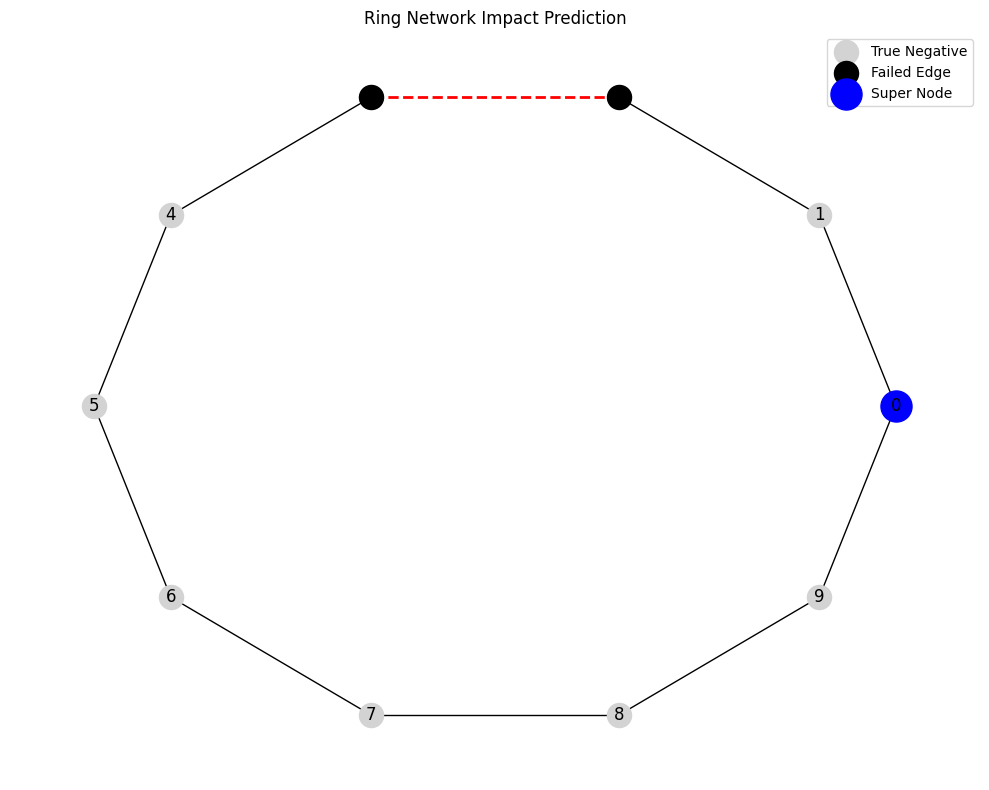

Epoch 300/500, Loss: 0.0000, Accuracy: 1.0000
Epoch 350/500, Loss: 0.0000, Accuracy: 1.0000
Epoch 400/500, Loss: 0.0000, Accuracy: 1.0000
Epoch 450/500, Loss: 0.0000, Accuracy: 1.0000
Epoch 500/500, Loss: 0.0000, Accuracy: 1.0000

Test on edge failure (2, 3):
Accuracy: 1.0000
True impacted nodes: set()
Predicted impacted nodes: set()
✓ Perfect prediction!


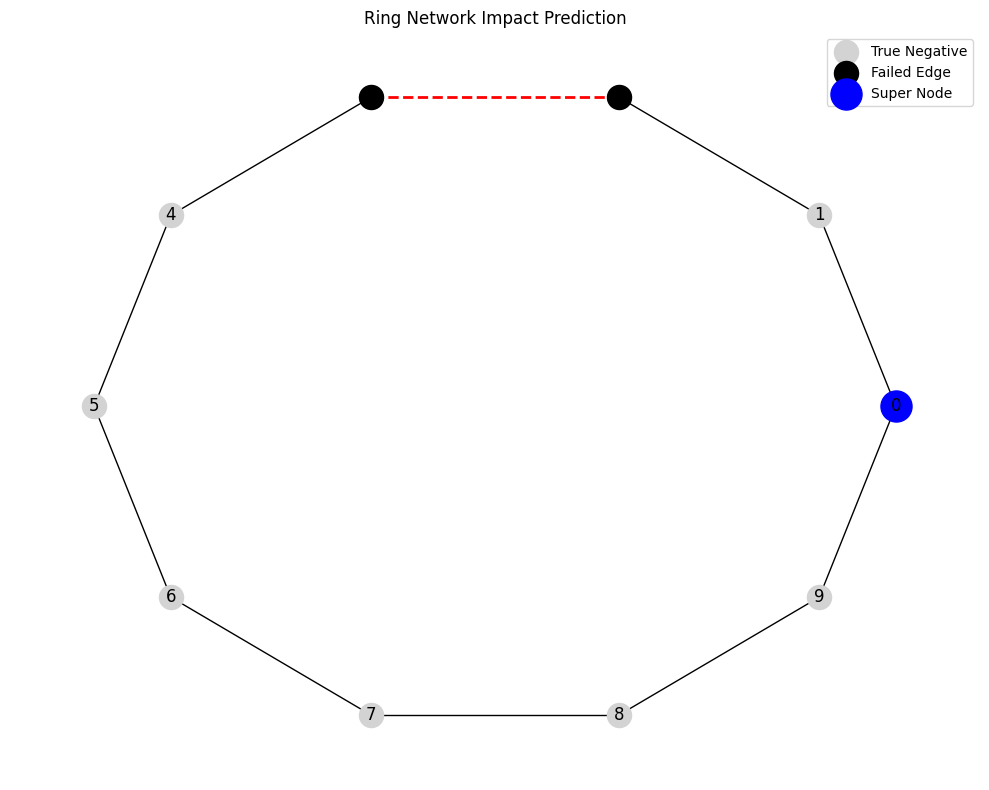

Final test accuracy: 1.0000, Precision: 1.0000


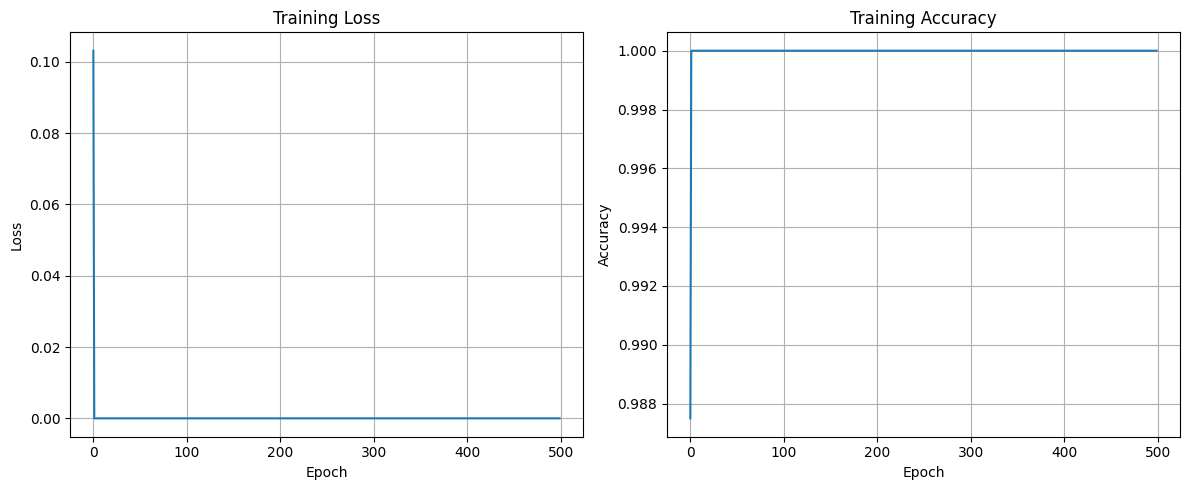

Final metrics - Accuracy: 1.0000, Precision: 1.0000

Testing edge failure (1, 2):
Predicted impacted nodes: set()


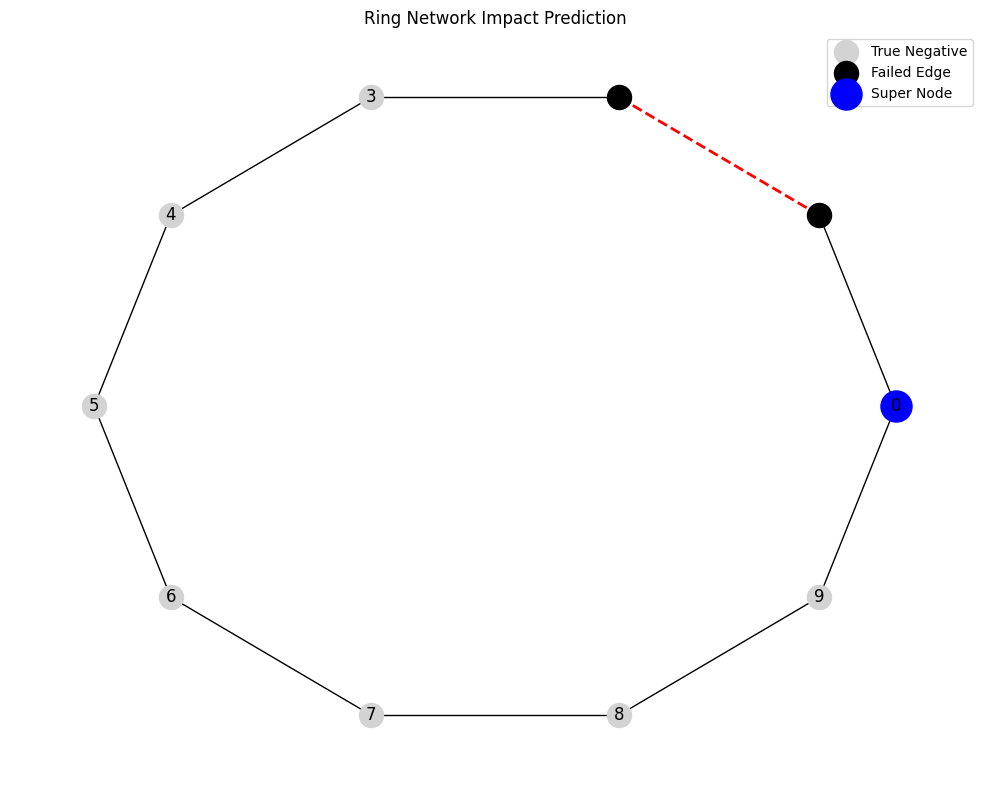


Testing edge failure (4, 5):
Predicted impacted nodes: set()


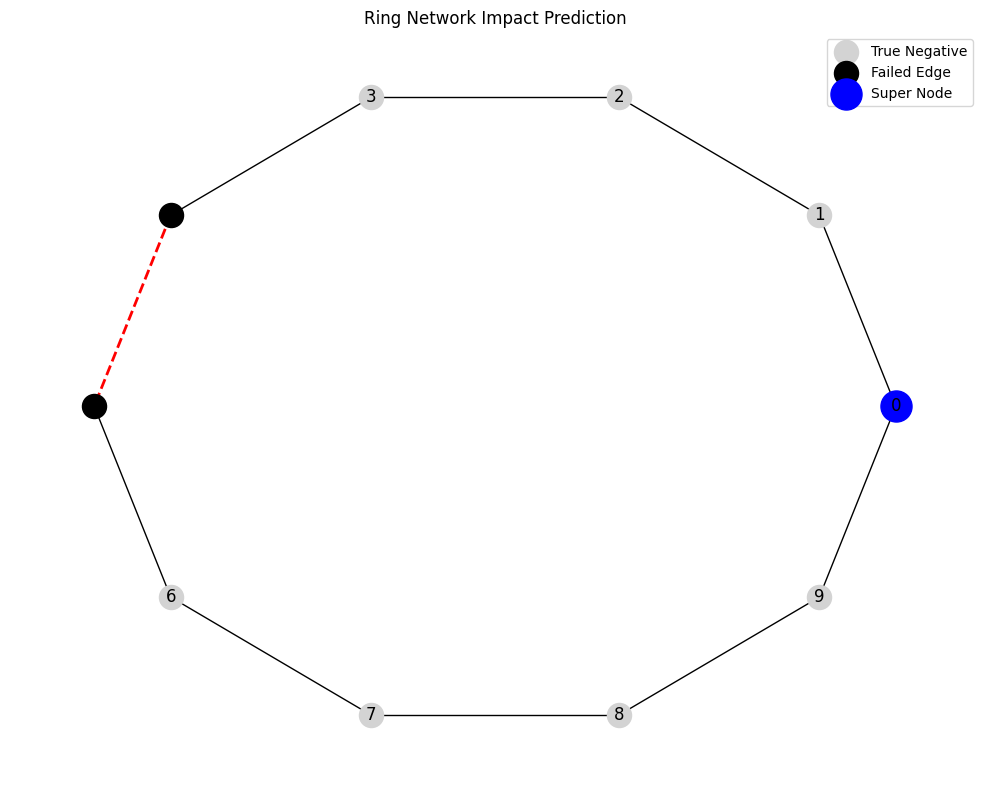


Testing edge failure (7, 8):
Predicted impacted nodes: set()


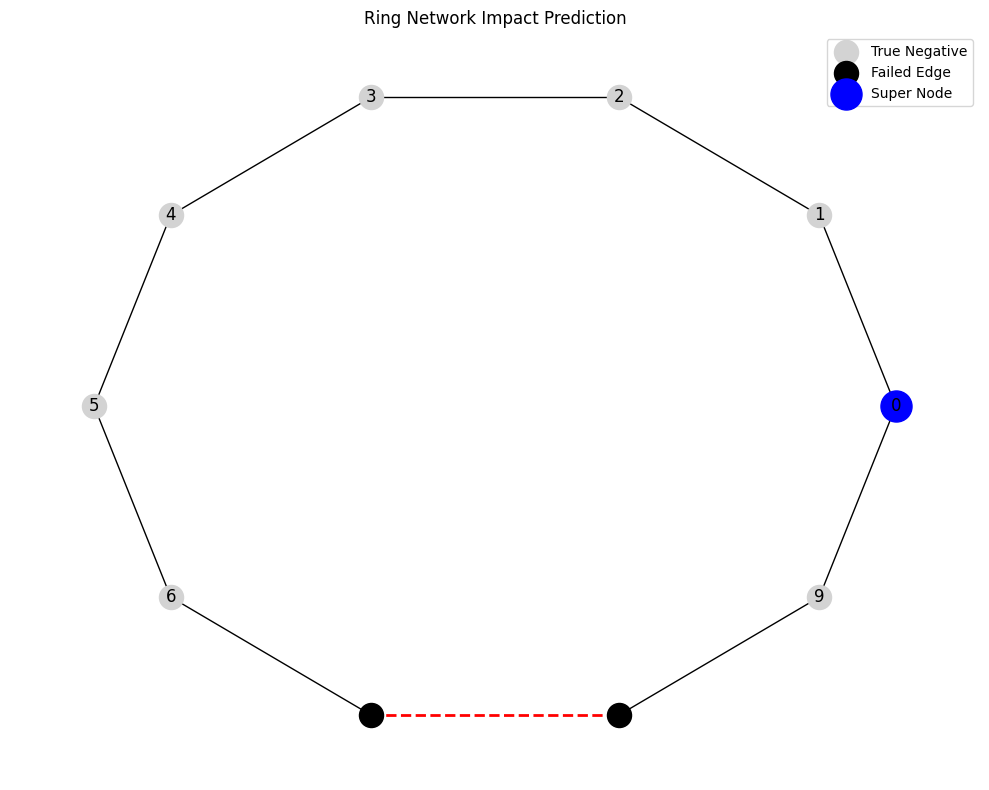

In [2]:
# Create a trainer for a 10-node ring
trainer = RingNetworkTrainer(num_nodes=10, super_node_id=0)

# Train the model with more epochs to achieve 100% precision
accuracy, precision = trainer.train(num_epochs=500, batch_size=32, test_interval=50)

print(f"Final metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")

# Test on a few specific edge failures
for edge in [(1, 2), (4, 5), (7, 8)]:
    print(f"\nTesting edge failure {edge}:")
    impacted = trainer.predict_impact(edge)
    print(f"Predicted impacted nodes: {impacted}")
    trainer.visualize_prediction(edge)

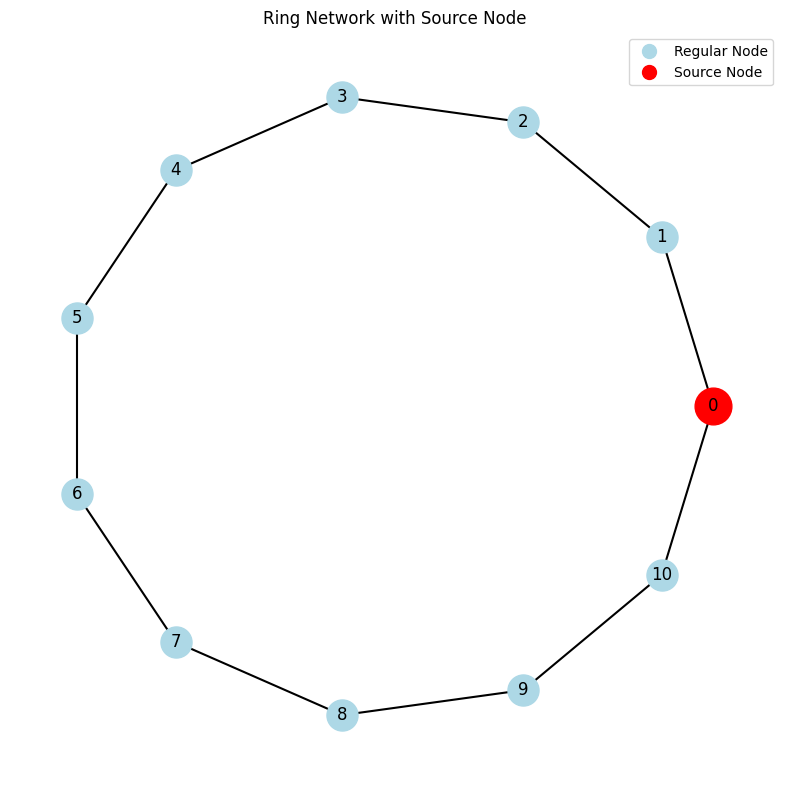

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def create_ring_network(num_nodes=10, source_node_id=0):
    """
    Create a ring network with a designated source node.
    
    Args:
        num_nodes: Number of regular nodes (excluding source node)
        source_node_id: ID of the source node
    
    Returns:
        NetworkX graph with ring topology
    """
    # Total nodes = num_nodes + 1 (for source node)
    total_nodes = num_nodes + 1
    
    # Create empty graph
    G = nx.Graph()
    
    # Add nodes
    for i in range(total_nodes):
        if i == source_node_id:
            G.add_node(i, type='source')
        else:
            G.add_node(i, type='regular')
    
    # Add edges to form a ring
    for i in range(total_nodes):
        next_node = (i + 1) % total_nodes
        G.add_edge(i, next_node)
    
    return G

def visualize_ring_network(G, source_node_id=0):
    """
    Visualize the ring network with the source node highlighted.
    
    Args:
        G: NetworkX graph
        source_node_id: ID of the source node
    """
    # Create a circular layout
    pos = nx.circular_layout(G)
    
    plt.figure(figsize=(8, 8))
    
    # Get regular nodes (all nodes except source)
    regular_nodes = [n for n in G.nodes() if n != source_node_id]
    
    # Draw regular nodes
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, 
                         node_color='lightblue', node_size=500)
    
    # Draw source node
    nx.draw_networkx_nodes(G, pos, nodelist=[source_node_id], 
                         node_color='red', node_size=700)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    # Create legend
    plt.plot([], [], 'o', color='lightblue', markersize=10, label='Regular Node')
    plt.plot([], [], 'o', color='red', markersize=10, label='Source Node')
    
    plt.legend()
    plt.title('Ring Network with Source Node')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Create the ring network (10 regular nodes + 1 source node)
ring_network = create_ring_network(num_nodes=10, source_node_id=0)

# Visualize the network
visualize_ring_network(ring_network, source_node_id=0)

In [7]:
import networkx as nx
import numpy as np
import torch
import random
from torch_geometric.data import Data, Dataset
import matplotlib.pyplot as plt


In [11]:
class RingFailureDataset(Dataset):
    def __init__(self, num_nodes=10, source_node_id=0, num_samples=1000, transform=None):
        """
        Create a dataset of network failures for GNN training.
        
        Args:
            num_nodes: Number of regular nodes (excluding source node)
            source_node_id: ID of the source node
            num_samples: Number of failure scenarios to generate
            transform: Optional transform to apply to the data
        """
        super(RingFailureDataset, self).__init__(transform)
        self.num_nodes = num_nodes
        self.source_node_id = source_node_id
        self.total_nodes = num_nodes + 1  # Including source node
        self.num_samples = num_samples
        self.samples = self._generate_samples()
    
    def _generate_samples(self):
        """Generate all samples for the dataset"""
        # Create the base ring network
        G = nx.Graph()
        for i in range(self.total_nodes):
            G.add_node(i)
        
        for i in range(self.total_nodes):
            next_node = (i + 1) % self.total_nodes
            G.add_edge(i, next_node)
        
        # All possible edges and nodes (excluding source node for failures)
        all_edges = list(G.edges())
        all_nodes = [n for n in G.nodes() if n != self.source_node_id]
        
        samples = []
        
        for _ in range(self.num_samples):
            # Randomly decide if we'll have node failures, edge failures, or both
            failure_type = random.choice(['edge', 'node', 'both'])
            
            failed_edges = []
            failed_nodes = []
            
            # Generate edge failures
            if failure_type in ['edge', 'both']:
                num_edge_failures = random.randint(1, 3)
                candidate_edges = all_edges.copy()
                random.shuffle(candidate_edges)
                failed_edges = candidate_edges[:num_edge_failures]
            
            # Generate node failures
            if failure_type in ['node', 'both']:
                num_node_failures = random.randint(1, 2)
                candidate_nodes = all_nodes.copy()
                random.shuffle(candidate_nodes)
                failed_nodes = candidate_nodes[:num_node_failures]
            
            # Create a copy of the graph to identify isolated nodes
            # (but we'll keep all nodes and edges for message passing)
            G_temp = G.copy()
            
            # Create a connectivity analysis graph by removing failed components
            G_connectivity = G.copy()
            # Remove failed nodes (for connectivity analysis only)
            for node in failed_nodes:
                if node in G_connectivity:
                    G_connectivity.remove_node(node)
            
            # Remove failed edges (for connectivity analysis only)
            for edge in failed_edges:
                if G_connectivity.has_edge(*edge):
                    G_connectivity.remove_edge(*edge)
            
            # Find isolated nodes using connectivity analysis
            if self.source_node_id in G_connectivity:
                connected_component = nx.node_connected_component(G_connectivity, self.source_node_id)
                isolated_nodes = [n for n in G.nodes() 
                                if n not in connected_component 
                                and n not in failed_nodes
                                and n != self.source_node_id]
            else:
                isolated_nodes = [n for n in G.nodes() 
                                if n not in failed_nodes
                                and n != self.source_node_id]
            
            # Create GNN-compatible data sample - using the full graph G with all edges
            # but marking failed components with special features
            data = self._create_gnn_data(G, failed_nodes, failed_edges, isolated_nodes)
            samples.append(data)
        
        return samples
    
    def _create_gnn_data(self, G, failed_nodes, failed_edges, isolated_nodes):
        """Convert network state to PyTorch Geometric Data object"""
        # Prepare node features 
        # Features: [is_source, is_failed, position, distance_to_source]
        x = torch.zeros((self.total_nodes, 2), dtype=torch.float)
        
        # Set features for all nodes
        for i in range(self.total_nodes):
            # Is source node
            x[i, 0] = 1.0 if i == self.source_node_id else 0.0
            
            # Node status (1 = failed, 0 = active)
            x[i, 1] = 1.0 if i in failed_nodes else 0.0
            
            # Normalized position in ring
        
        # Extract all edges from the graph (including failed ones)
        edge_index = []
        edge_attr = []  # Will contain edge features (1 = failed, 0 = active)
        
        for u, v in G.edges():
            # Add edges in both directions for undirected graph
            edge_index.append([u, v])
            edge_index.append([v, u])
            
            # Mark edge status (1 = failed, 0 = active)
            is_failed = 1.0 if (u, v) in failed_edges or (v, u) in failed_edges else 0.0
            edge_attr.append([is_failed])
            edge_attr.append([is_failed])  # Same attribute for both directions
        
        # Convert to tensors
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()  # Transpose to get 2xE
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        
        # Prepare labels: 1 for isolated nodes, 0 for non-isolated
        y = torch.zeros(self.total_nodes, dtype=torch.float)
        for node in isolated_nodes:
            y[node] = 1.0
        
        # Create the data object with edge attributes
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        
        # Store metadata for reference
        data.failed_nodes = failed_nodes
        data.failed_edges = failed_edges
        data.isolated_nodes = isolated_nodes
        
        return data
    
    def len(self):
        return self.num_samples
    
    def get(self, idx):
        return self.samples[idx]
    
    def visualize_sample(self, idx):
        """Visualize a sample from the dataset"""
        data = self.samples[idx]
        
        # Create a graph for visualization
        G_vis = nx.Graph()
        
        # Add all nodes
        for i in range(self.total_nodes):
            G_vis.add_node(i)
        
        # Add all edges
        edge_list = []
        for i in range(0, data.edge_index.shape[1], 2):  # Skip every other edge (undirected)
            u, v = data.edge_index[0, i].item(), data.edge_index[1, i].item()
            edge_list.append((u, v))
            G_vis.add_edge(u, v)
        
        # Setup visualization
        pos = nx.circular_layout(G_vis)
        plt.figure(figsize=(10, 8))
        
        # Prepare node categories
        failed_nodes = data.failed_nodes
        isolated_nodes = data.isolated_nodes
        
        # Get active non-isolated nodes
        active_nodes = [n for n in range(self.total_nodes) 
                      if n not in failed_nodes 
                      and n not in isolated_nodes
                      and n != self.source_node_id]
        
        # Draw nodes by category
        nx.draw_networkx_nodes(G_vis, pos, nodelist=active_nodes, 
                             node_color='lightblue', node_size=300, label='Active')
        
        nx.draw_networkx_nodes(G_vis, pos, nodelist=isolated_nodes, 
                             node_color='orange', node_size=300, label='Isolated')
        
        nx.draw_networkx_nodes(G_vis, pos, nodelist=failed_nodes, 
                             node_color='red', node_size=300, label='Failed')
        
        # Draw source node
        nx.draw_networkx_nodes(G_vis, pos, nodelist=[self.source_node_id], 
                             node_color='green', node_size=500, label='Source')
        
        # Get working and failed edges
        failed_edge_list = []
        working_edge_list = []
        
        for i, (u, v) in enumerate(edge_list):
            edge_status = data.edge_attr[i*2, 0].item()  # Get status from edge attributes
            if edge_status > 0.5:  # Failed edge
                failed_edge_list.append((u, v))
            else:
                working_edge_list.append((u, v))
        
        # Draw edges
        nx.draw_networkx_edges(G_vis, pos, edgelist=working_edge_list)
        nx.draw_networkx_edges(G_vis, pos, edgelist=failed_edge_list, 
                             style='dashed', edge_color='red', width=2)
        
        # Draw node labels
        nx.draw_networkx_labels(G_vis, pos)
        
        plt.legend()
        plt.title(f'Sample {idx}: Network with Failures and Isolated Nodes')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print additional info
        print(f"Failed nodes: {data.failed_nodes}")
        print(f"Failed edges: {data.failed_edges}")
        print(f"Isolated nodes: {data.isolated_nodes}")

Created dataset with 1000 samples

Sample 812:


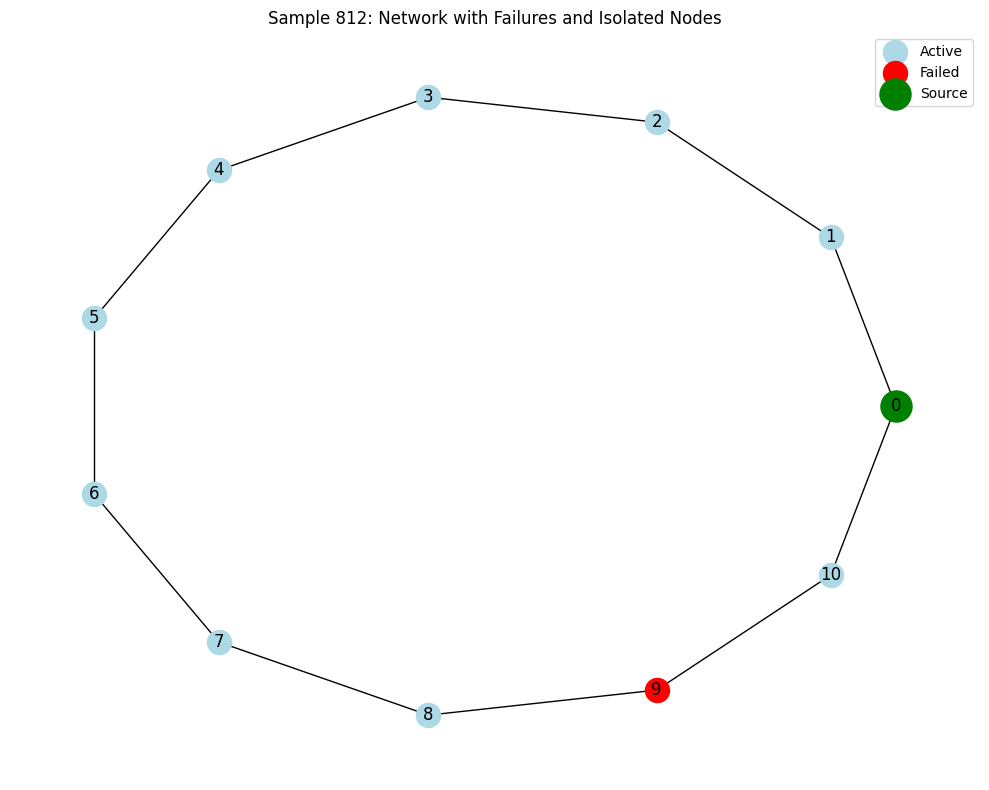

Failed nodes: [9]
Failed edges: []
Isolated nodes: []

Sample 771:


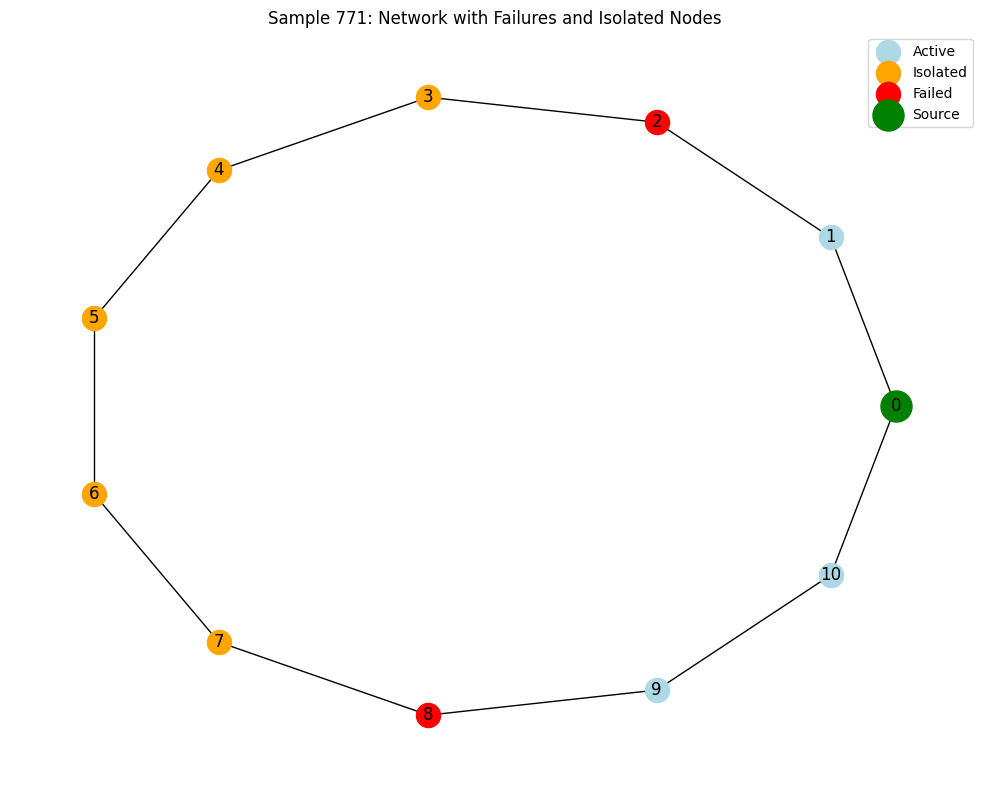

Failed nodes: [8, 2]
Failed edges: []
Isolated nodes: [3, 4, 5, 6, 7]

Sample 543:


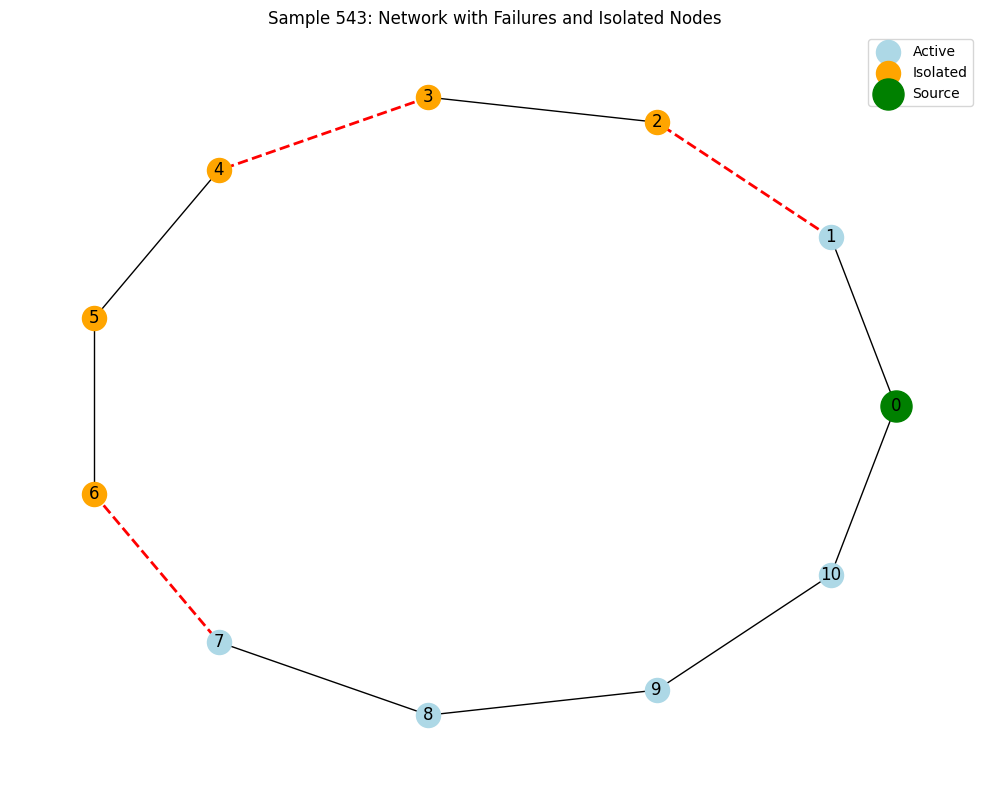

Failed nodes: []
Failed edges: [(3, 4), (6, 7), (1, 2)]
Isolated nodes: [2, 3, 4, 5, 6]

Prepared data loaders:
Training samples: 800
Testing samples: 200
Batches in training: 25


In [12]:

dataset = RingFailureDataset(num_nodes=10, source_node_id=0, num_samples=1000)
print(f"Created dataset with {len(dataset)} samples")

# Visualize a few random samples
for i in range(3):
    sample_idx = random.randint(0, len(dataset) - 1)
    print(f"\nSample {sample_idx}:")
    dataset.visualize_sample(sample_idx)

# Example of how to use the dataset for GNN training
from torch_geometric.loader import DataLoader

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\nPrepared data loaders:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Batches in training: {len(train_loader)}")

In [8]:
class IsolationGNN(torch.nn.Module):
    def __init__(self, num_node_features=2, num_edge_features=1, hidden_channels=32, num_layers=6):
        """
        GNN model to predict node isolation in a ring network with failures.
        
        Args:
            num_node_features: Number of input node features (is_source, is_failed)
            num_edge_features: Number of edge features (is_failed)
            hidden_channels: Size of hidden representations
            num_layers: Number of message passing layers (should be large enough for 
                       messages to reach farthest nodes in the ring)
        """
        super(IsolationGNN, self).__init__()
        
        # Initial node feature transformation
        self.node_encoder = nn.Linear(num_node_features, hidden_channels)
        
        # Edge feature transformation
        self.edge_encoder = nn.Linear(num_edge_features, hidden_channels)
        
        # Message passing layers that can utilize edge features
        from torch_geometric.nn import GCNConv, EdgeConv, GATv2Conv, MessagePassing
        
        # Custom message passing layer that considers edge attributes
        class EdgeAwareConv(MessagePassing):
            def __init__(self, in_channels, out_channels):
                super(EdgeAwareConv, self).__init__(aggr='add')
                self.lin_node = nn.Linear(in_channels, out_channels)
                self.lin_edge = nn.Linear(in_channels, out_channels)
                self.lin_update = nn.Linear(in_channels + out_channels, out_channels)
            
            def forward(self, x, edge_index, edge_attr):
                # Transform edge attributes
                edge_embedding = self.lin_edge(edge_attr)
                
                # Propagate messages
                out = self.propagate(edge_index, x=x, edge_attr=edge_embedding)
                
                # Update node features
                out = self.lin_update(torch.cat([x, out], dim=1))
                return out
            
            def message(self, x_j, edge_attr):
                # Message is a function of source node and edge features
                # Specifically, if edge is failed (edge_attr=1), it will affect the message
                return x_j * (1 - edge_attr) + edge_attr * self.lin_node(x_j)
        
        # Create the message passing layers
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            self.conv_layers.append(EdgeAwareConv(hidden_channels, hidden_channels))
        
        # Final prediction layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels, 1)
        )
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Use only the first 2 features as specified
    
        
        # Initial encoding
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        
        # Apply message passing layers
        for conv in self.conv_layers:
            x = F.relu(conv(x, edge_index, edge_attr))
        
        # Final prediction - whether node is isolated (1) or not (0)
        x = self.classifier(x)
        
        return torch.sigmoid(x).squeeze(-1)


In [75]:
from torch_geometric.loader import DataLoader



In [73]:
def train_isolation_model(dataset, epochs=100, batch_size=32, lr=0.001, test_size=0.2):
    """
    Train a GNN model to predict node isolation in networks with failures.
    Stops training early if model reaches perfect F1 score.
    
    Args:
        dataset: Dataset of network samples
        epochs: Maximum number of training epochs
        batch_size: Batch size for training
        lr: Learning rate
        test_size: Proportion of data to use for testing
    
    Returns:
        Trained model
    """
    # Split dataset into train and test
    num_samples = len(dataset)
    indices = list(range(num_samples))
    random.shuffle(indices)
    
    split = int(num_samples * (1 - test_size))
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create the model
    model = IsolationGNN(
        num_node_features=2,  # [is_source, is_failed]
        num_edge_features=1,  # [is_failed]
        hidden_channels=32
    ).to(device)
    
    # Set up optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    best_f1 = 0
    for epoch in range(epochs):
        # Training step
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            out = model(batch)
            
            # Only consider non-failed, non-source nodes for loss
            mask = (batch.x[:, 1] == 0)  # Not failed
            mask &= (batch.x[:, 0] == 0)  # Not source
            
            # Get all active nodes across all graphs in batch with their batch indices
            edge_index = batch.edge_index
            
            # Compute binary cross entropy loss
            loss = F.binary_cross_entropy(
                out[mask], 
                batch.y[mask]
            )
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * batch.num_graphs
        
        avg_train_loss = total_loss / len(train_dataset)
        
        # Testing step
        model.eval()
        y_true = []
        y_pred = []
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                
                # Forward pass
                out = model(batch)
                
                # Only consider non-failed, non-source nodes
                mask = (batch.x[:, 1] == 0)  # Not failed
                mask &= (batch.x[:, 0] == 0)  # Not source
                
                # Collect true labels and predictions
                y_true.append(batch.y[mask].cpu())
                y_pred.append((out[mask] > 0.5).float().cpu())
        
        # Concatenate batch results
        test_labels = torch.cat(y_true, dim=0)
        test_preds = torch.cat(y_pred, dim=0)
        
        # Compute metrics
        test_acc = accuracy_score(test_labels, test_preds)
        test_f1 = f1_score(test_labels, test_preds, zero_division=0)
        test_prec = precision_score(test_labels, test_preds, zero_division=0)
        test_rec = recall_score(test_labels, test_preds, zero_division=0)
        
        # Save the best model
        if test_f1 > best_f1:
            best_f1 = test_f1
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, " +
              f"Test Acc: {test_acc:.4f}, F1: {test_f1:.4f}, " +
              f"Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")
        
        # Early stopping if perfect F1 score achieved
        if test_f1 >= 0.98:  # Using 0.999 instead of 1.0 to account for floating point precision
            print(f"Perfect F1 score achieved! Stopping training early at epoch {epoch+1}")
            break
    
    # Final evaluation
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            
            # Only consider non-failed, non-source nodes
            mask = (batch.x[:, 1] == 0)  # Not failed
            mask &= (batch.x[:, 0] == 0)  # Not source
            
            y_true.append(batch.y[mask].cpu())
            y_pred.append((out[mask] > 0.5).float().cpu())
    
    # Concatenate batch results
    test_labels = torch.cat(y_true, dim=0)
    test_preds = torch.cat(y_pred, dim=0)
    
    # Compute metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds, zero_division=0)
    test_rec = recall_score(test_labels, test_preds, zero_division=0)
    test_f1 = f1_score(test_labels, test_preds, zero_division=0)
    
    print("\nFinal Test Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  F1 Score: {test_f1:.4f}")
    print(f"  Precision: {test_prec:.4f}")
    print(f"  Recall: {test_rec:.4f}")
    
    return model

In [51]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
import random
from torch_geometric.data import Data, Dataset
from tqdm import tqdm  #

In [13]:
model = train_isolation_model(
    dataset=dataset,
    epochs=100,          # Number of training epochs
    batch_size=32,       # Batch size for training
    lr=0.001             # Learning rate
)

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


Epoch 1/100
  Train Loss: 0.6426
  Val Metrics: Acc=0.6684, F1=0.0000
  Val Precision=0.0000, Recall=0.0000
Epoch 10/100
  Train Loss: 0.2752
  Val Metrics: Acc=0.9340, F1=0.8992
  Val Precision=0.9106, Recall=0.8881
Epoch 20/100
  Train Loss: 0.0880
  Val Metrics: Acc=0.9696, F1=0.9530
  Val Precision=0.9765, Recall=0.9306
Epoch 30/100
  Train Loss: 0.0388
  Val Metrics: Acc=0.9844, F1=0.9770
  Val Precision=0.9571, Recall=0.9978
Epoch 40/100
  Train Loss: 0.0141
  Val Metrics: Acc=0.9881, F1=0.9818
  Val Precision=1.0000, Recall=0.9642
Epoch 50/100
  Train Loss: 0.0024
  Val Metrics: Acc=0.9963, F1=0.9944
  Val Precision=0.9955, Recall=0.9933
Epoch 60/100
  Train Loss: 0.0156
  Val Metrics: Acc=0.9970, F1=0.9955
  Val Precision=0.9933, Recall=0.9978
Epoch 70/100
  Train Loss: 0.0012
  Val Metrics: Acc=0.9978, F1=0.9966
  Val Precision=0.9955, Recall=0.9978
Epoch 80/100
  Train Loss: 0.0007
  Val Metrics: Acc=0.9978, F1=0.9966
  Val Precision=0.9955, Recall=0.9978
Epoch 90/100
  Train


Evaluating sample 553:


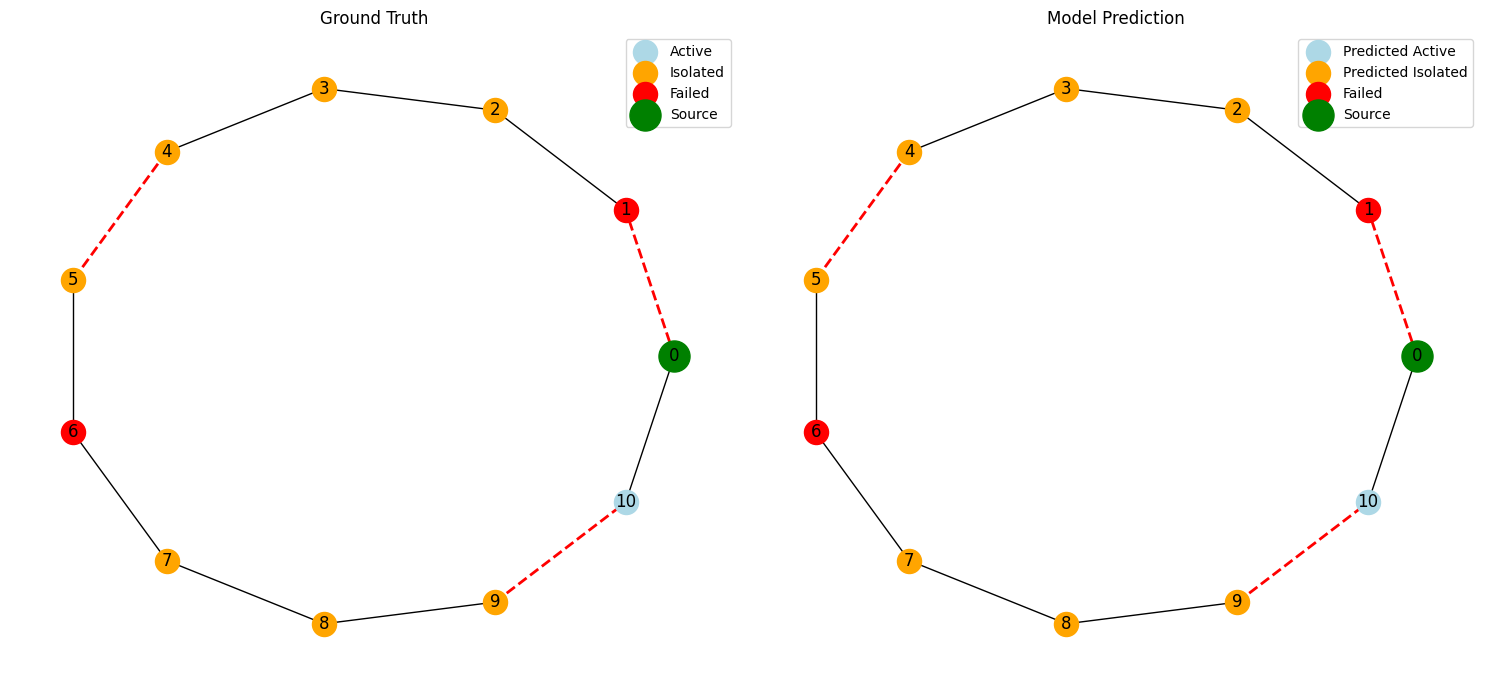

Sample 553 prediction accuracy: 1.0000
Failed nodes: [1, 6]
Failed edges: [[0, 1], [4, 5], [9, 10]]
True isolated nodes: [2, 3, 4, 5, 7, 8, 9]
Predicted isolated nodes: [2, 3, 4, 5, 7, 8, 9]

Evaluating sample 149:


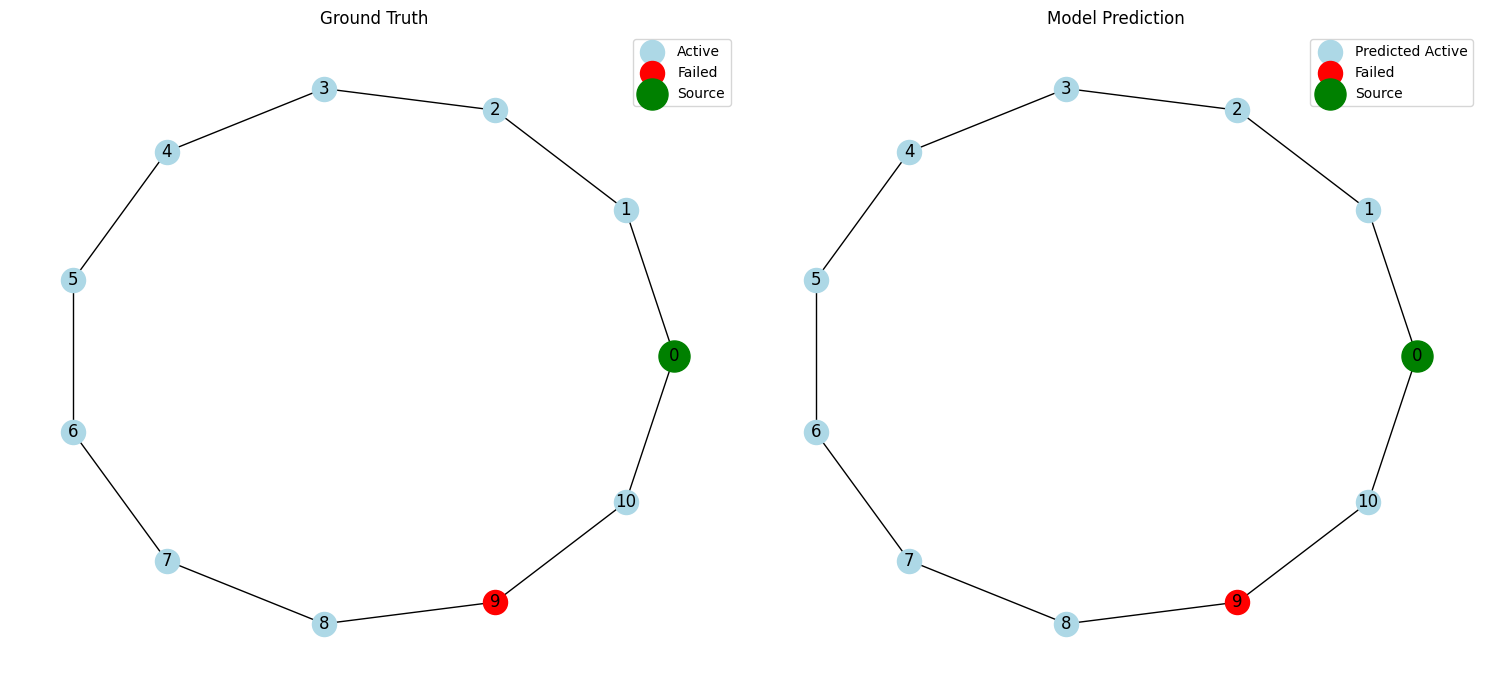

Sample 149 prediction accuracy: 1.0000
Failed nodes: [9]
Failed edges: []
True isolated nodes: []
Predicted isolated nodes: []

Evaluating sample 383:


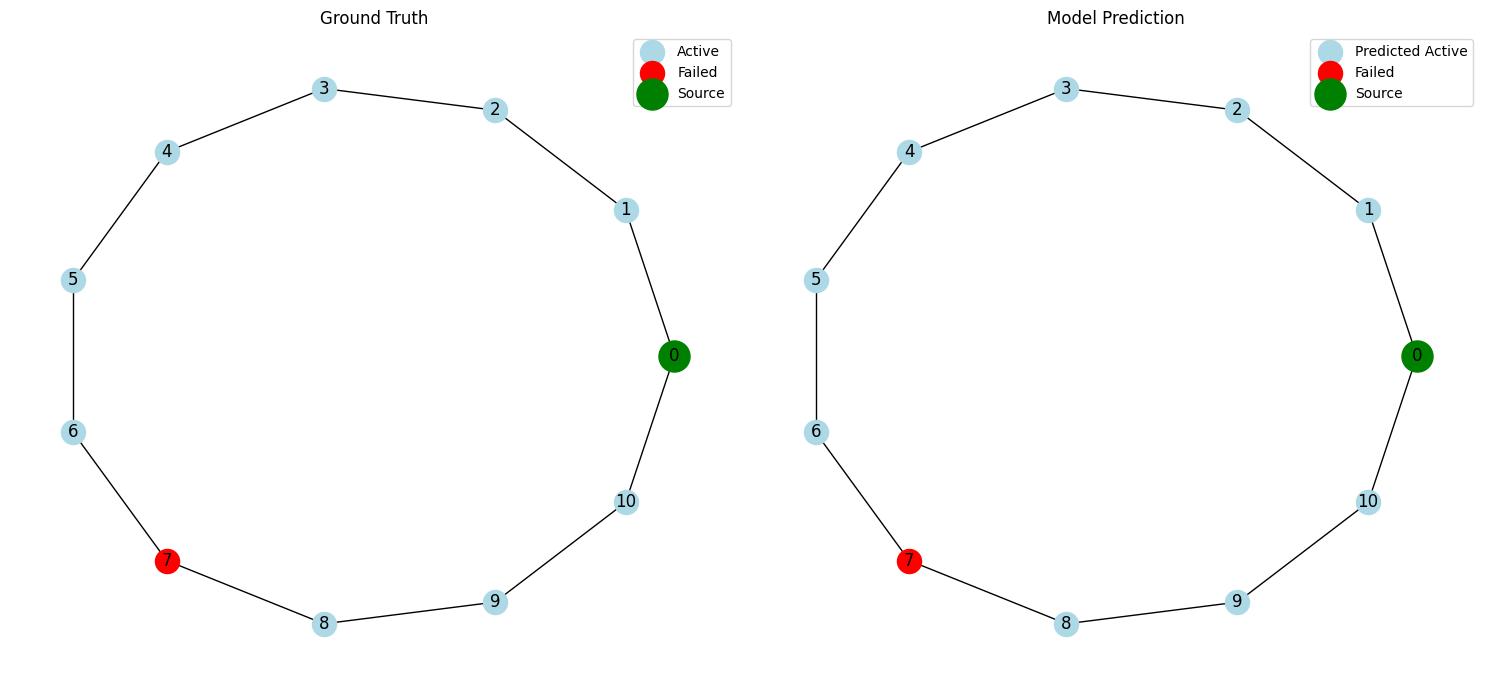

Sample 383 prediction accuracy: 1.0000
Failed nodes: [7]
Failed edges: []
True isolated nodes: []
Predicted isolated nodes: []

Evaluating sample 750:


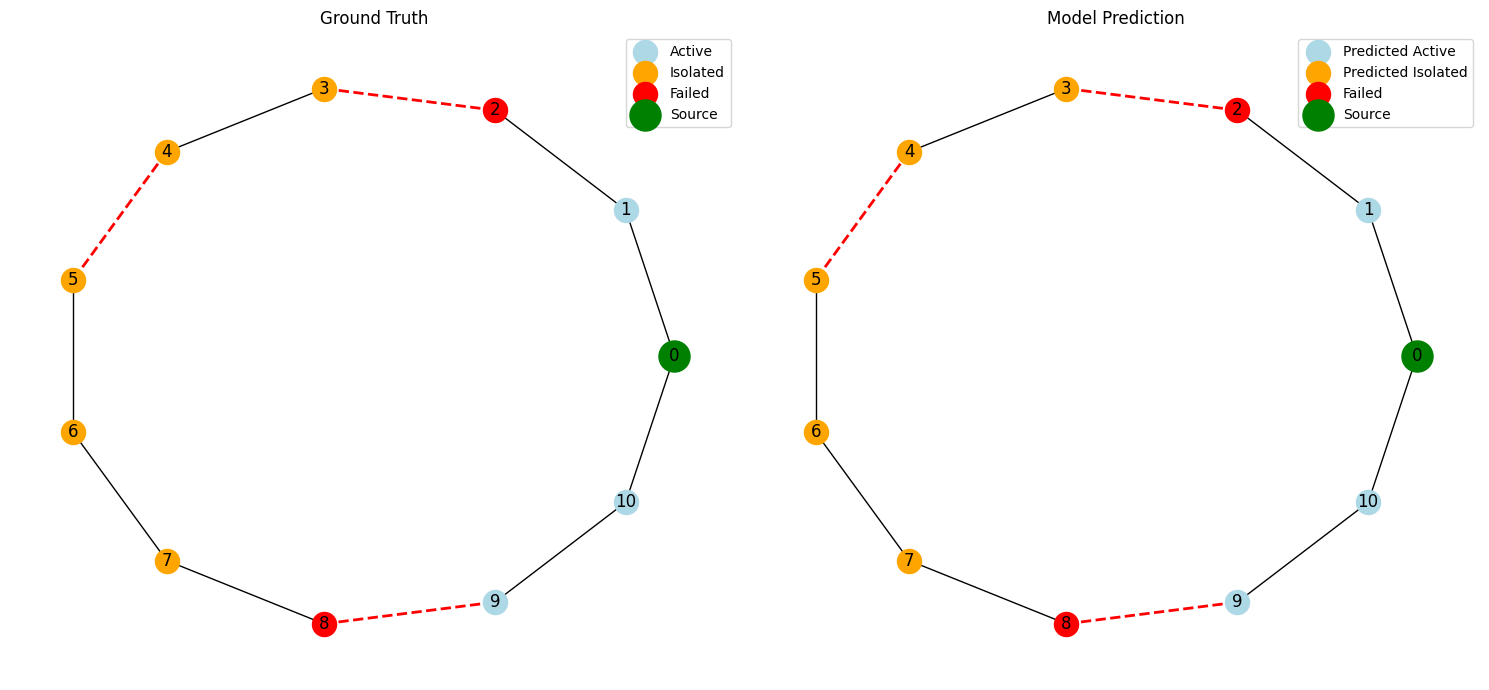

Sample 750 prediction accuracy: 1.0000
Failed nodes: [2, 8]
Failed edges: [[2, 3], [4, 5], [8, 9]]
True isolated nodes: [3, 4, 5, 6, 7]
Predicted isolated nodes: [3, 4, 5, 6, 7]

Evaluating sample 625:


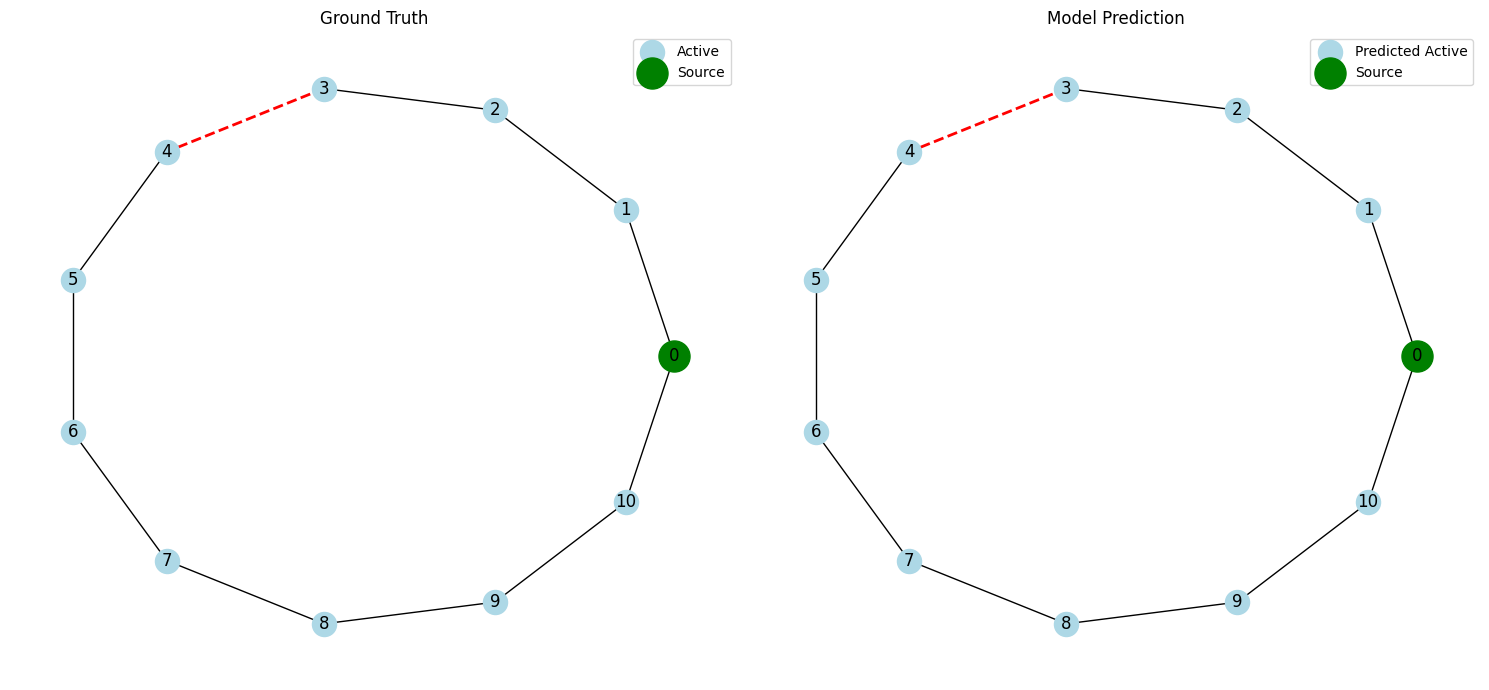

Sample 625 prediction accuracy: 1.0000
Failed nodes: []
Failed edges: [[3, 4]]
True isolated nodes: []
Predicted isolated nodes: []


In [15]:
def predict_isolation(model, sample_idx, dataset):
    """Make a prediction on a specific sample and visualize the results"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Get the sample
    data = dataset[sample_idx].to(device)
    
    # Make prediction
    with torch.no_grad():
        out = model(data)
        pred = (out > 0.5).float()
    
    # Create visualization
    G_vis = nx.Graph()
    
    # Add all nodes
    for i in range(dataset.total_nodes):
        G_vis.add_node(i)
    
    # Add edges
    edge_list = []
    for i in range(0, data.edge_index.shape[1], 2):  # Skip every other edge (undirected)
        u, v = data.edge_index[0, i].item(), data.edge_index[1, i].item()
        edge_list.append((u, v))
        G_vis.add_edge(u, v)
    
    # Setup visualization
    pos = nx.circular_layout(G_vis)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Ground truth plot
    failed_nodes = data.failed_nodes
    failed_edges = data.failed_edges
    isolated_nodes = data.isolated_nodes
    
    # Get active non-isolated nodes
    active_nodes = [n for n in range(dataset.total_nodes) 
                  if n not in failed_nodes 
                  and n not in isolated_nodes
                  and n != dataset.source_node_id]
    
    # Draw nodes by category (ground truth)
    nx.draw_networkx_nodes(G_vis, pos, nodelist=active_nodes, 
                         node_color='lightblue', node_size=300, label='Active', ax=ax1)
    nx.draw_networkx_nodes(G_vis, pos, nodelist=isolated_nodes, 
                         node_color='orange', node_size=300, label='Isolated', ax=ax1)
    nx.draw_networkx_nodes(G_vis, pos, nodelist=failed_nodes, 
                         node_color='red', node_size=300, label='Failed', ax=ax1)
    nx.draw_networkx_nodes(G_vis, pos, nodelist=[dataset.source_node_id], 
                         node_color='green', node_size=500, label='Source', ax=ax1)
    
    # Get working and failed edges
    failed_edge_list = []
    working_edge_list = []
    
    for i, (u, v) in enumerate(edge_list):
        edge_status = data.edge_attr[i*2, 0].item()
        if edge_status > 0.5:  # Failed edge
            failed_edge_list.append((u, v))
        else:
            working_edge_list.append((u, v))
    
    # Draw edges (ground truth)
    nx.draw_networkx_edges(G_vis, pos, edgelist=working_edge_list, ax=ax1)
    nx.draw_networkx_edges(G_vis, pos, edgelist=failed_edge_list, 
                         style='dashed', edge_color='red', width=2, ax=ax1)
    nx.draw_networkx_labels(G_vis, pos, ax=ax1)
    ax1.set_title("Ground Truth")
    ax1.legend()
    ax1.axis('off')
    
    # Prediction plot
    # Draw nodes by predicted category
    predicted_isolated = []
    predicted_active = []
    
    for i in range(dataset.total_nodes):
        if i in failed_nodes or i == dataset.source_node_id:
            continue  # Skip failed nodes and source
        
        if pred[i] > 0.5:
            predicted_isolated.append(i)
        else:
            predicted_active.append(i)
    
    nx.draw_networkx_nodes(G_vis, pos, nodelist=predicted_active, 
                         node_color='lightblue', node_size=300, label='Predicted Active', ax=ax2)
    nx.draw_networkx_nodes(G_vis, pos, nodelist=predicted_isolated, 
                         node_color='orange', node_size=300, label='Predicted Isolated', ax=ax2)
    nx.draw_networkx_nodes(G_vis, pos, nodelist=failed_nodes, 
                         node_color='red', node_size=300, label='Failed', ax=ax2)
    nx.draw_networkx_nodes(G_vis, pos, nodelist=[dataset.source_node_id], 
                         node_color='green', node_size=500, label='Source', ax=ax2)
    
    # Draw edges (same as ground truth)
    nx.draw_networkx_edges(G_vis, pos, edgelist=working_edge_list, ax=ax2)
    nx.draw_networkx_edges(G_vis, pos, edgelist=failed_edge_list, 
                         style='dashed', edge_color='red', width=2, ax=ax2)
    nx.draw_networkx_labels(G_vis, pos, ax=ax2)
    ax2.set_title("Model Prediction")
    ax2.legend()
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy on this sample
    correct_count = 0
    total_count = 0
    
    for i in range(dataset.total_nodes):
        if i in failed_nodes or i == dataset.source_node_id:
            continue  # Skip failed nodes and source
        
        total_count += 1
        is_isolated = i in isolated_nodes
        is_predicted_isolated = pred[i] > 0.5
        
        if is_isolated == is_predicted_isolated:
            correct_count += 1
    
    accuracy = correct_count / total_count if total_count > 0 else 0
    print(f"Sample {sample_idx} prediction accuracy: {accuracy:.4f}")
    print(f"Failed nodes: {failed_nodes}")
    print(f"Failed edges: {failed_edges}")
    print(f"True isolated nodes: {isolated_nodes}")
    print(f"Predicted isolated nodes: {predicted_isolated}")

# Evaluate on a few random samples
for i in range(5):
    sample_idx = random.randint(0, len(dataset)-1)
    print(f"\nEvaluating sample {sample_idx}:")
    predict_isolation(model, sample_idx, dataset)

In [16]:
torch.save(model.state_dict(), 'isolation_gnn_model_v1.pt')

In [11]:
# Load the saved model
model = IsolationGNN()
model.load_state_dict(torch.load('isolation_gnn_model_v1.pt'))
model.eval()


IsolationGNN(
  (node_encoder): Linear(in_features=2, out_features=32, bias=True)
  (edge_encoder): Linear(in_features=1, out_features=32, bias=True)
  (conv_layers): ModuleList(
    (0-5): 6 x EdgeAwareConv()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [116]:
def test_model_with_custom_failures(model, graph):
    """
    Test the model with a custom graph, extracting failed nodes and edges from attributes.
    Only shows prediction results, no ground truth.
    
    Args:
        model: Trained IsolationGNN model
        graph: NetworkX graph with 'is_failed' attributes on nodes and edges
        source_node_id: ID of the source node
    
    Returns:
        data: PyG Data object used for the prediction
        pred: Model predictions
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Extract failed nodes and edges from graph attributes
    failed_nodes = [n for n, attrs in graph.nodes(data=True) if attrs.get('failed', False)]
    failed_edges = [(u, v) for u, v, attrs in graph.edges(data=True) if attrs.get('failed', False)]
    source_node_id = next((n for n, attrs in graph.nodes(data=True) if attrs.get('is_block', False)), None)
    # Prepare node features
    total_nodes = graph.number_of_nodes()
    x = torch.zeros((total_nodes, 2), dtype=torch.float)
    
    # Create node mapping
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
    
    # Set features for all nodes
    for node, idx in node_to_idx.items():
        # Is source node
        x[idx, 0] = 1.0 if node == source_node_id else 0.0
        
        # Node status (1 = failed, 0 = active)
        x[idx, 1] = 1.0 if node in failed_nodes else 0.0
    
    # Prepare edges and edge features
    edge_index = []
    edge_attr = []
    
    for u, v in graph.edges():
        # Add both directions for undirected graph
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        edge_index.append([node_to_idx[v], node_to_idx[u]])
        
        # Mark edge status (1 = failed, 0 = active)
        is_failed = (u, v) in failed_edges or (v, u) in failed_edges
        edge_attr.append([1.0 if is_failed else 0.0])
        edge_attr.append([1.0 if is_failed else 0.0])
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Create the data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.failed_nodes = failed_nodes
    data.failed_edges = failed_edges
    data.node_mapping = {idx: node for node, idx in node_to_idx.items()}
    
    # Get model prediction
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
        print(out)
        pred = (out > 0.5).float()
    
    # Create visualization
    G_vis = nx.Graph()
    
    # Add all nodes
    for node in graph.nodes():
        G_vis.add_node(node)
    
    # Add edges
    for u, v in graph.edges():
        G_vis.add_edge(u, v)
    
    # Setup visualization
    pos = nx.spring_layout(G_vis, seed=42)
    
    # Create prediction visualization
    plt.figure(figsize=(10, 8))
    
    # Get predictions
    predicted_isolated = []
    predicted_active = []
    
    for i, node in enumerate(graph.nodes()):
        if node in failed_nodes or node == source_node_id:
            continue  # Skip failed nodes and source
        
        idx = node_to_idx[node]
        if pred[idx] > 0.5:
            predicted_isolated.append(node)
        else:
            predicted_active.append(node)
    
    # Draw nodes by predicted category
    nx.draw_networkx_nodes(G_vis, pos, nodelist=predicted_active, 
                         node_color='lightblue', node_size=300, label='Predicted Active')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=predicted_isolated, 
                         node_color='orange', node_size=300, label='Predicted Isolated')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=failed_nodes, 
                         node_color='red', node_size=300, label='Failed')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=[source_node_id], 
                         node_color='green', node_size=500, label='Source')
    
    # Draw edges
    working_edge_list = [(u, v) for u, v in graph.edges() 
                        if (u, v) not in failed_edges and (v, u) not in failed_edges]
    
    nx.draw_networkx_edges(G_vis, pos, edgelist=working_edge_list)
    nx.draw_networkx_edges(G_vis, pos, edgelist=failed_edges, 
                         style='dashed', edge_color='red', width=2)
    nx.draw_networkx_labels(G_vis, pos)
    
    plt.title("Model Prediction")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print predictions
    print(f"Failed nodes: {failed_nodes}")
    print(f"Failed edges: {failed_edges}")
    print(f"Predicted isolated nodes: {predicted_isolated}")
    
    return data, pred

In [115]:
def test_model_with_custom_failures_with_ups(model, graph):
    """
    Test the model with a custom graph, extracting failed nodes and edges from attributes.
    Only shows prediction results, no ground truth.
    
    Args:
        model: Trained IsolationGNN model
        graph: NetworkX graph with 'is_failed' attributes on nodes and edges
        source_node_id: ID of the source node
    
    Returns:
        data: PyG Data object used for the prediction
        pred: Model predictions
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Extract failed nodes and edges from graph attributes
    failed_nodes = [n for n, attrs in graph.nodes(data=True) if attrs.get('failed', False)]
    failed_edges = [(u, v) for u, v, attrs in graph.edges(data=True) if attrs.get('failed', False)]
    source_node_id = next((n for n, attrs in graph.nodes(data=True) if attrs.get('is_block', False)), None)
    ups_nodes = [n for n, attrs in graph.nodes(data=True) if attrs.get('is_ups', False)]
    total_nodes = graph.number_of_nodes()
    x = torch.zeros((total_nodes, 3), dtype=torch.float)
    
    # Create node mapping
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
    
    # Set features for all nodes
    for node, idx in node_to_idx.items():
        # Is source node
        x[idx, 0] = 1.0 if node == source_node_id else 0.0
        
        # Node status (1 = failed, 0 = active)
        x[idx, 1] = 1.0 if node in failed_nodes else 0.0
        x[idx, 2] = 1.0 if node in ups_nodes else 0.0
    # Prepare edges and edge features
    edge_index = []
    edge_attr = []
    
    for u, v in graph.edges():
        # Add both directions for undirected graph
        edge_index.append([node_to_idx[u], node_to_idx[v]])
        edge_index.append([node_to_idx[v], node_to_idx[u]])
        
        # Mark edge status (1 = failed, 0 = active)
        is_failed = (u, v) in failed_edges or (v, u) in failed_edges
        edge_attr.append([1.0 if is_failed else 0.0])
        edge_attr.append([1.0 if is_failed else 0.0])
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Create the data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.failed_nodes = failed_nodes
    data.failed_edges = failed_edges
    data.node_mapping = {idx: node for node, idx in node_to_idx.items()}
    
    # Get model prediction
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
        print(out)
        pred = (out > 0.5).float()
    
    # Create visualization
    G_vis = nx.Graph()
    
    # Add all nodes
    for node in graph.nodes():
        G_vis.add_node(node)
    
    # Add edges
    for u, v in graph.edges():
        G_vis.add_edge(u, v)
    
    # Setup visualization
    pos = nx.spring_layout(G_vis, seed=42)
    
    # Create prediction visualization
    plt.figure(figsize=(10, 8))
    
    # Get predictions
    predicted_isolated = []
    predicted_active = []
    
    for i, node in enumerate(graph.nodes()):
        if node in failed_nodes or node == source_node_id:
            continue  # Skip failed nodes and source
        
        idx = node_to_idx[node]
        if pred[idx] > 0.5:
            predicted_isolated.append(node)
        else:
            predicted_active.append(node)
    
    # Draw nodes by predicted category
    nx.draw_networkx_nodes(G_vis, pos, nodelist=predicted_active, 
                         node_color='lightblue', node_size=300, label='Predicted Active')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=predicted_isolated, 
                         node_color='orange', node_size=300, label='Predicted Isolated')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=failed_nodes, 
                         node_color='red', node_size=300, label='Failed')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=[source_node_id], 
                         node_color='green', node_size=500, label='Source')
    
    # Draw edges
    working_edge_list = [(u, v) for u, v in graph.edges() 
                        if (u, v) not in failed_edges and (v, u) not in failed_edges]
    
    nx.draw_networkx_edges(G_vis, pos, edgelist=working_edge_list)
    nx.draw_networkx_edges(G_vis, pos, edgelist=failed_edges, 
                         style='dashed', edge_color='red', width=2)
    nx.draw_networkx_labels(G_vis, pos)
    
    plt.title("Model Prediction")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print predictions
    print(f"Failed nodes: {failed_nodes}")
    print(f"Failed edges: {failed_edges}")
    print(f"Predicted isolated nodes: {predicted_isolated}")
    
    return data, pred

In [131]:
# Create a single ring graph with failures
import networkx as nx

# Parameters
num_nodes = 10
source_node_id = 0

# Create empty graph
G = nx.Graph()

# Add nodes
for i in range(num_nodes):
    # Source node
    if i == source_node_id:
        G.add_node(i, is_failed=False,is_block=True)
    # One failed node
    elif i == 3 or i == 6:
        G.add_node(i, is_failed=True)
    # Regular nodes
    else:
        G.add_node(i, is_failed=False)

# Add edges to form a ring
for i in range(num_nodes):
    next_node = (i + 1) % num_nodes
    
    # Mark one edge as failed
    if i == 6:
        G.add_edge(i, next_node, is_failed=False)
    else:
        G.add_edge(i, next_node, is_failed=False)
existing_nodes = list(G.nodes())
next_ups_id = max(existing_nodes) + 1

# Add a UPS node for each existing node
for node in existing_nodes:
    # Create UPS node with special attribute
    G.add_node(next_ups_id, is_failed=False, is_ups=True)
    
    # Connect UPS node only to its parent node
    G.add_edge(node, next_ups_id, is_failed=False)
    
    next_ups_id += 1
# The graph G now contains a single ring with node 3 and edge (6,7) marked as failed

In [134]:
G.number_of_nodes()

20

In [137]:
# Create a multi-ring graph with failures
import networkx as nx
import random

# Parameters
num_rings = 3
nodes_per_ring = 5
source_node_id = 0

# Create empty graph
G = nx.Graph()

# Add source node
G.add_node(source_node_id, failed=False,is_block=True)

# Track all nodes for visualization
all_nodes = [source_node_id]
next_node_id = source_node_id + 1

# Generate multiple rings
for ring in range(num_rings):
    # Create ring nodes
    ring_nodes = list(range(next_node_id, next_node_id + nodes_per_ring))
    all_nodes.extend(ring_nodes)
    
    # Add nodes to graph
    for node in ring_nodes:
        # Mark one node as failed in the first ring
        if ring == 0 and node == next_node_id + 2 or node == next_node_id + 4:
            G.add_node(node, failed=True)
        else:
            G.add_node(node, failed=False)
    
    # Connect nodes in sequence to form the ring segment
    for i in range(len(ring_nodes) - 1):
        G.add_edge(ring_nodes[i], ring_nodes[i+1], failed=False)
    
    # Close the ring through source node
    G.add_edge(source_node_id, ring_nodes[0], failed=False)
    
    # Mark the last connection as failed in the second ring
    if ring == 1:
        G.add_edge(source_node_id, ring_nodes[-1], failed=True)
    else:
        G.add_edge(source_node_id, ring_nodes[-1], failed=False)
    
    # Update next node ID
    next_node_id += nodes_per_ring

existing_nodes = list(G.nodes())
next_ups_id = max(existing_nodes) + 1

# Add a UPS node for each existing node
for node in existing_nodes:
    # Create UPS node with special attribute
    G.add_node(next_ups_id, is_failed=False, is_ups=True)
    
    # Connect UPS node only to its parent node
    G.add_edge(node, next_ups_id, is_failed=False)
    
    next_ups_id += 1
# The graph G now contains multiple rings with some failures
# Each ring connects to the source node at two points

NetworkXError: Node None has no position.

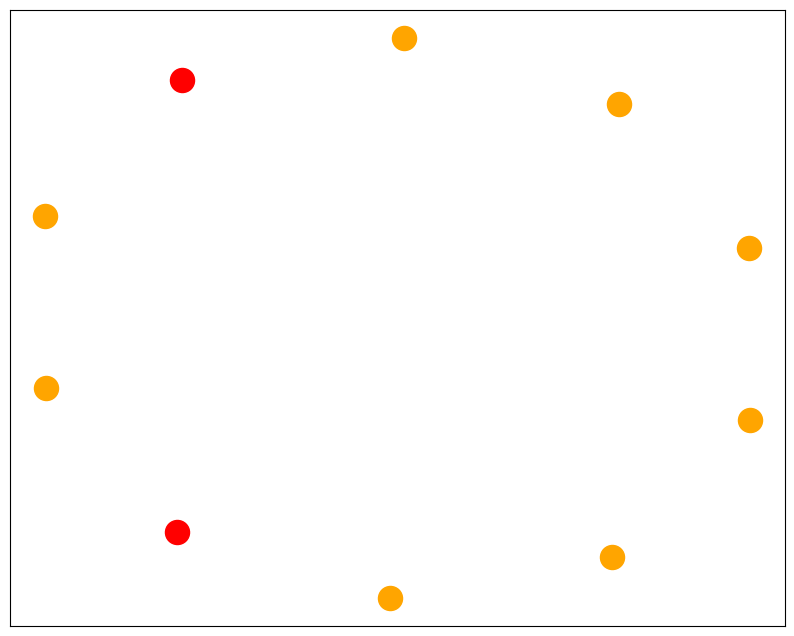

In [27]:
test_model_with_custom_failures_with_ups(
    model_multi_ring_with_ups,
    G,

)

In [65]:
class MultiRingIsolationDataset(Dataset):
    def __init__(self, num_samples=1000, min_rings=2, max_rings=4, 
               min_nodes_per_ring=5, max_nodes_per_ring=10, source_node_id=0,
               transform=None):
        super(MultiRingIsolationDataset, self).__init__(transform)
        self.num_samples = num_samples
        self.min_rings = min_rings
        self.max_rings = max_rings
        self.min_nodes_per_ring = min_nodes_per_ring
        self.max_nodes_per_ring = max_nodes_per_ring
        self.source_node_id = source_node_id
        self.samples = self._generate_samples()
    
    def _generate_samples(self):
        """Generate all samples for the dataset"""
        samples = []
        
        for _ in tqdm(range(self.num_samples), desc="Generating samples"):
            # Generate a new multi-ring topology
            graph, ring_info = self._create_multi_ring_topology()
            
            # Generate random failures
            failed_nodes, failed_edges = self._generate_failures(graph, ring_info)
            
            # Find isolated nodes
            isolated_nodes = self._find_isolated_nodes(graph, failed_nodes, failed_edges)
            
            # Create PyG data sample
            data = self._create_pyg_data(graph, failed_nodes, failed_edges, isolated_nodes)
            samples.append(data)
        
        return samples
    
    def _create_multi_ring_topology(self):
        """Create a network with multiple rings sharing the source node"""
        G = nx.Graph()
        
        # Add source node
        G.add_node(self.source_node_id, is_source=True)
        
        # Track ring structures
        ring_info = {}
        next_node_id = self.source_node_id + 1
        
        # Generate multiple rings
        num_rings = random.randint(self.min_rings, self.max_rings)
        
        for ring_idx in range(num_rings):
            # Decide number of nodes in this ring (excluding source)
            ring_size = random.randint(self.min_nodes_per_ring, self.max_nodes_per_ring)
            
            # Create nodes for this ring
            ring_nodes = list(range(next_node_id, next_node_id + ring_size))
            
            # Add nodes to the graph
            for node in ring_nodes:
                G.add_node(node, ring_id=ring_idx)
            
            # Connect nodes sequentially
            for i in range(len(ring_nodes) - 1):
                G.add_edge(ring_nodes[i], ring_nodes[i+1])
            
            # Connect first and last to source node to complete the ring
            G.add_edge(self.source_node_id, ring_nodes[0])
            G.add_edge(self.source_node_id, ring_nodes[-1])
            
            # Store ring information
            ring_info[ring_idx] = ring_nodes
            
            # Update next node ID
            next_node_id += ring_size
        
        return G, ring_info
    
    def _generate_failures(self, graph, ring_info):
        """Generate random failures on nodes and edges"""
        failed_nodes = []
        failed_edges = []
        
        # Never fail the source node
        available_nodes = [n for n in graph.nodes() if n != self.source_node_id]
        
        # Decide if we have node failures, edge failures, or both
        failure_type = random.choice(['node', 'edge', 'both'])
        
        # Generate node failures (exclude source node)
        if failure_type in ['node', 'both']:
            num_node_failures = random.randint(1, min(3, len(available_nodes) // 3))
            failed_nodes = random.sample(available_nodes, num_node_failures)
        
        # Generate edge failures (avoid edges directly connected to failed nodes)
        if failure_type in ['edge', 'both']:
            # Get available edges (exclude those connected to failed nodes)
            available_edges = []
            for u, v in graph.edges():
                if u not in failed_nodes and v not in failed_nodes:
                    available_edges.append((u, v))
            
            if available_edges:
                num_edge_failures = random.randint(1, min(3, len(available_edges) // 3))
                failed_edges = random.sample(available_edges, num_edge_failures)
        
        return failed_nodes, failed_edges
    
    def _find_isolated_nodes(self, graph, failed_nodes, failed_edges):
        """Find nodes that are isolated from the source node due to failures"""
        # Create a copy of the graph for isolation analysis
        analysis_graph = graph.copy()
        
        # Remove failed nodes
        for node in failed_nodes:
            if node in analysis_graph:
                analysis_graph.remove_node(node)
        
        # Remove failed edges
        for u, v in failed_edges:
            if analysis_graph.has_edge(u, v):
                analysis_graph.remove_edge(u, v)
        
        # Find connected component containing the source
        if self.source_node_id in analysis_graph:
            connected_component = nx.node_connected_component(analysis_graph, self.source_node_id)
            
            # Nodes not in this component are isolated
            isolated_nodes = [n for n in analysis_graph.nodes() 
                            if n not in connected_component 
                            and n != self.source_node_id]
        else:
            # If source node was removed, all nodes are isolated
            isolated_nodes = list(analysis_graph.nodes())
        
        return isolated_nodes
    
    def _create_pyg_data(self, graph, failed_nodes, failed_edges, isolated_nodes):
        """Convert the graph with failures to a PyTorch Geometric Data object"""
        # Prepare node features: [is_source, is_failed]
        x = torch.zeros((graph.number_of_nodes(), 2), dtype=torch.float)
        
        # Create a mapping of node IDs to indices
        node_to_idx = {node: i for i, node in enumerate(sorted(graph.nodes()))}
        
        # Set node features
        for node in graph.nodes():
            idx = node_to_idx[node]
            # Is source
            x[idx, 0] = 1.0 if node == self.source_node_id else 0.0
            # Is failed
            x[idx, 1] = 1.0 if node in failed_nodes else 0.0
        
        # Prepare edges and edge features
        edge_index = []
        edge_attr = []
        
        for u, v in graph.edges():
            # Add both directions (for undirected graph)
            edge_index.append([node_to_idx[u], node_to_idx[v]])
            edge_index.append([node_to_idx[v], node_to_idx[u]])
            
            # Edge feature: is_failed
            is_failed = 1.0 if (u, v) in failed_edges or (v, u) in failed_edges else 0.0
            edge_attr.append([is_failed])
            edge_attr.append([is_failed])
        
        # Convert to tensors
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        
        # Prepare target: isolated nodes
        y = torch.zeros(graph.number_of_nodes(), dtype=torch.float)
        for node in isolated_nodes:
            y[node_to_idx[node]] = 1.0
        
        # Create PyG Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        
        # Store metadata with string keys only
        # This is the key fix - PyG doesn't handle int keys well when batching
        data.node_mapping = {str(i): int(node) for node, i in node_to_idx.items()}
        data.failed_nodes_list = failed_nodes
        data.failed_edges_list = failed_edges
        data.isolated_nodes_list = isolated_nodes
        
        return data
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]
    
    def visualize_sample(self, idx):
        """Visualize a sample from the dataset"""
        data = self.samples[idx]
        
        # Reconstruct graph for visualization
        G_vis = nx.Graph()
        node_map = {int(i): data.node_mapping[i] for i in data.node_mapping.keys()}
        
        # Add nodes
        for i in range(data.x.shape[0]):
            is_source = data.x[i, 0].item() > 0.5
            is_failed = data.x[i, 1].item() > 0.5
            G_vis.add_node(node_map[i], is_source=is_source, is_failed=is_failed)
        
        # Add edges
        for i in range(0, data.edge_index.shape[1], 2):  # Skip duplicates
            u_idx = data.edge_index[0, i].item()
            v_idx = data.edge_index[1, i].item()
            u, v = node_map[u_idx], node_map[v_idx]
            
            is_failed = data.edge_attr[i, 0].item() > 0.5
            G_vis.add_edge(u, v, is_failed=is_failed)
        
        # Visualization
        pos = nx.spring_layout(G_vis, seed=42)
        plt.figure(figsize=(12, 10))
        
        # Node categories
        source_node = [n for n, attrs in G_vis.nodes(data=True) if attrs.get('is_source', False)]
        failed_nodes = [n for n, attrs in G_vis.nodes(data=True) if attrs.get('is_failed', False)]
        isolated_nodes = data.isolated_nodes_list
        active_nodes = [n for n in G_vis.nodes() 
                      if n not in source_node 
                      and n not in failed_nodes
                      and n not in isolated_nodes]
        
        # Draw nodes
        nx.draw_networkx_nodes(G_vis, pos, nodelist=active_nodes, 
                             node_color='lightblue', node_size=300, label='Active')
        nx.draw_networkx_nodes(G_vis, pos, nodelist=isolated_nodes, 
                             node_color='orange', node_size=300, label='Isolated')
        nx.draw_networkx_nodes(G_vis, pos, nodelist=failed_nodes, 
                             node_color='red', node_size=300, label='Failed')
        nx.draw_networkx_nodes(G_vis, pos, nodelist=source_node, 
                             node_color='green', node_size=500, label='Source')
        
        # Draw edges
        failed_edges = [(u, v) for u, v, attrs in G_vis.edges(data=True) if attrs.get('is_failed', False)]
        active_edges = [(u, v) for u, v in G_vis.edges() if (u, v) not in failed_edges and (v, u) not in failed_edges]
        
        nx.draw_networkx_edges(G_vis, pos, edgelist=active_edges)
        nx.draw_networkx_edges(G_vis, pos, edgelist=failed_edges, 
                             style='dashed', edge_color='red', width=2)
        
        # Draw labels
        nx.draw_networkx_labels(G_vis, pos)
        
        plt.title(f"Sample {idx}: Network with Multiple Rings and Isolated Nodes")
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print additional info
        print(f"Number of nodes: {G_vis.number_of_nodes()}")
        print(f"Failed nodes: {data.failed_nodes_list}")
        print(f"Failed edges: {data.failed_edges_list}")
        print(f"Isolated nodes: {data.isolated_nodes_list}")

In [66]:

dataset_v3 = MultiRingIsolationDataset(
    num_samples=1000,
    min_rings=2,
    max_rings=4,
    min_nodes_per_ring=5,
    max_nodes_per_ring=10,
    source_node_id=0
)

Generating samples: 100%|██████████| 1000/1000 [00:00<00:00, 1450.59it/s]


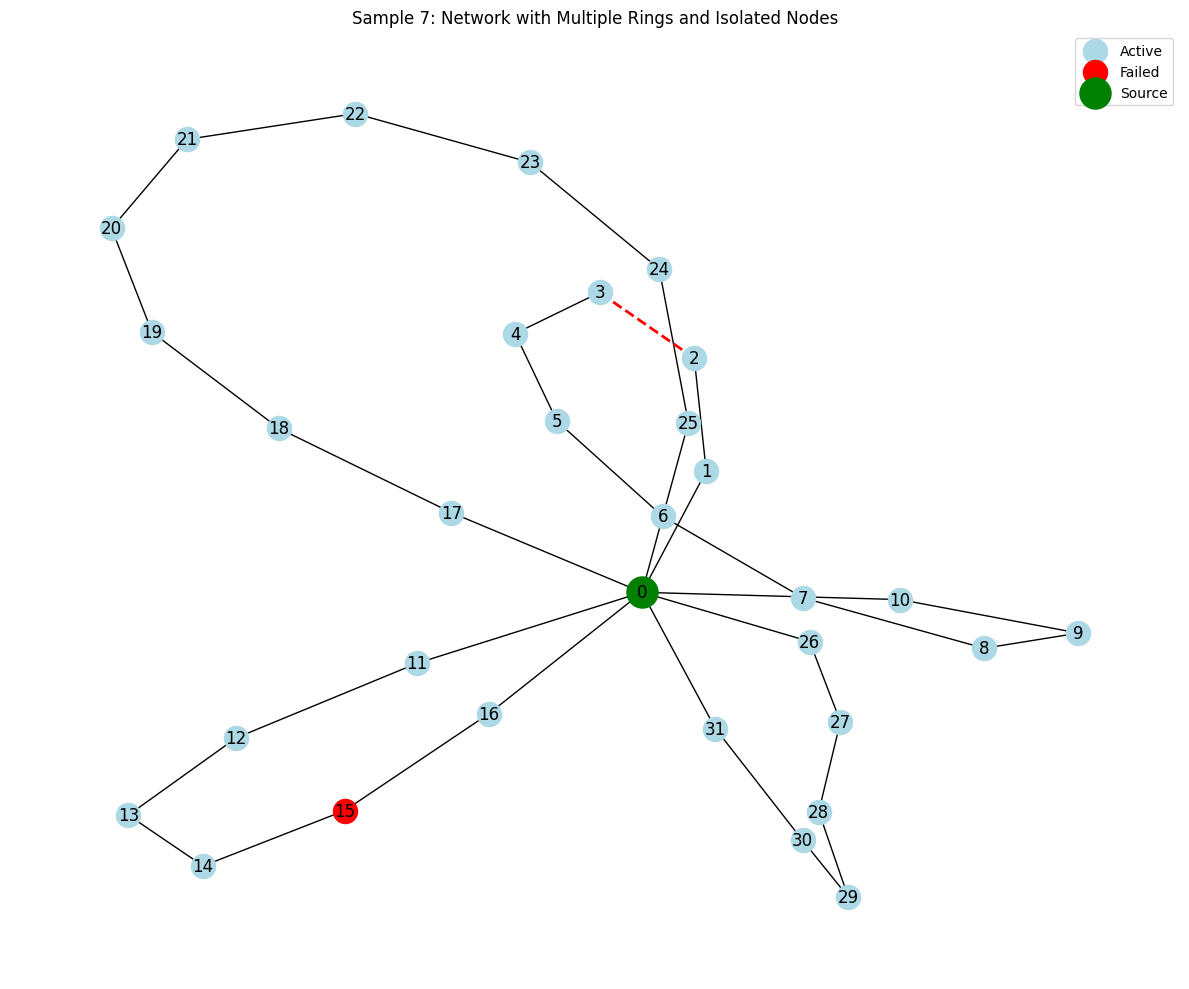

Number of nodes: 32
Failed nodes: [15]
Failed edges: [(2, 3)]
Isolated nodes: []


In [67]:
dataset_v3.visualize_sample(7)

In [68]:
class SimpleMultiRingDataset(Dataset):
    def __init__(self, num_samples=1000, min_rings=2, max_rings=4, 
               min_nodes_per_ring=5, max_nodes_per_ring=10, source_node_id=0):
        """
        Create a simplified dataset with multiple rings sharing a source node.
        Includes edge attributes for compatibility with edge-aware GNNs.
        """
        super(SimpleMultiRingDataset, self).__init__()
        self.num_samples = num_samples
        self.min_rings = min_rings
        self.max_rings = max_rings
        self.min_nodes_per_ring = min_nodes_per_ring
        self.max_nodes_per_ring = max_nodes_per_ring
        self.source_node_id = source_node_id
        self.samples = self._generate_samples()
    
    def _generate_samples(self):
        """Generate all samples for the dataset"""
        samples = []
        
        for _ in tqdm(range(self.num_samples), desc="Generating samples"):
            # Generate a multi-ring graph
            G = nx.Graph()
            
            # Add source node
            G.add_node(self.source_node_id)
            
            # Track all nodes for failure generation
            all_nodes = [self.source_node_id]
            next_node_id = self.source_node_id + 1
            
            # Generate multiple rings
            num_rings = random.randint(self.min_rings, self.max_rings)
            
            for _ in range(num_rings):
                # Decide ring size
                ring_size = random.randint(self.min_nodes_per_ring, self.max_nodes_per_ring)
                
                # Create ring nodes
                ring_nodes = list(range(next_node_id, next_node_id + ring_size))
                all_nodes.extend(ring_nodes)
                
                # Add nodes to graph
                for node in ring_nodes:
                    G.add_node(node)
                
                # Connect nodes in sequence
                for i in range(len(ring_nodes) - 1):
                    G.add_edge(ring_nodes[i], ring_nodes[i+1])
                
                # Close the ring through source node
                G.add_edge(self.source_node_id, ring_nodes[0])
                G.add_edge(self.source_node_id, ring_nodes[-1])
                
                # Update next node ID
                next_node_id += ring_size
            
            # Generate random failures (exclude source node)
            candidates = [n for n in all_nodes if n != self.source_node_id]
            num_failures = random.randint(1, max(1, len(candidates) // 4))
            failed_nodes = random.sample(candidates, num_failures)
            
            # Find isolated nodes
            analysis_graph = G.copy()
            for node in failed_nodes:
                analysis_graph.remove_node(node)
            
            if self.source_node_id in analysis_graph:
                # Find nodes connected to source
                connected = nx.node_connected_component(analysis_graph, self.source_node_id)
                # Nodes not connected to source are isolated
                isolated_nodes = [n for n in analysis_graph.nodes() 
                                if n not in connected and n != self.source_node_id]
            else:
                isolated_nodes = []
            
            # Create simplified PyG data
            data = self._create_simple_data(G, failed_nodes, isolated_nodes)
            samples.append(data)
        
        return samples
    
    def _create_simple_data(self, graph, failed_nodes, isolated_nodes):
        """Create a simplified PyG Data object with only essential fields"""
        # Remap node IDs to be sequential from 0
        nodes = sorted(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        
        # Node features: [is_source, is_failed]
        x = torch.zeros((len(nodes), 2), dtype=torch.float)
        
        # Set features
        for node in graph.nodes():
            idx = node_to_idx[node]
            # Is source
            x[idx, 0] = 1.0 if node == self.source_node_id else 0.0
            # Is failed
            x[idx, 1] = 1.0 if node in failed_nodes else 0.0
        
        # Edge index and attributes
        edge_index = []
        edge_attr = []
        
        for u, v in graph.edges():
            # Add both directions for undirected graph
            edge_index.append([node_to_idx[u], node_to_idx[v]])
            edge_index.append([node_to_idx[v], node_to_idx[u]])
            
            # Add edge features (all zeros for now - no edge failures)
            edge_attr.append([0.0])  # Single feature: is_failed=0
            edge_attr.append([0.0])
        
        # Convert to tensor
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        
        # Target: isolated nodes
        y = torch.zeros(len(nodes), dtype=torch.float)
        for node in isolated_nodes:
            y[node_to_idx[node]] = 1.0
        
        # Create data object with edge attributes
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [123]:
class SimpleMultiRingDatasetwithUPS(Dataset):
    def __init__(self, num_samples=1000, min_rings=2, max_rings=4, 
               min_nodes_per_ring=5, max_nodes_per_ring=10, source_node_id=0):
        """
        Create a simplified dataset with multiple rings sharing a source node.
        Includes UPS nodes as spurs to all nodes including the source.
        """
        super(SimpleMultiRingDatasetwithUPS, self).__init__()
        self.num_samples = num_samples
        self.min_rings = min_rings
        self.max_rings = max_rings
        self.min_nodes_per_ring = min_nodes_per_ring
        self.max_nodes_per_ring = max_nodes_per_ring
        self.source_node_id = source_node_id
        self.samples = self._generate_samples()
    
    def _generate_samples(self):
        """Generate all samples for the dataset"""
        samples = []
        
        for _ in tqdm(range(self.num_samples), desc="Generating samples"):
            # Generate a multi-ring graph
            G = nx.Graph()
            
            # Add source node
            G.add_node(self.source_node_id)
            
            # Track all nodes for failure generation
            all_nodes = [self.source_node_id]
            next_node_id = self.source_node_id + 1
            
            # Generate multiple rings
            num_rings = random.randint(self.min_rings, self.max_rings)
            
            for _ in range(num_rings):
                # Decide ring size
                ring_size = random.randint(self.min_nodes_per_ring, self.max_nodes_per_ring)
                
                # Create ring nodes
                ring_nodes = list(range(next_node_id, next_node_id + ring_size))
                all_nodes.extend(ring_nodes)
                
                # Add nodes to graph
                for node in ring_nodes:
                    G.add_node(node)
                
                # Connect nodes in sequence
                for i in range(len(ring_nodes) - 1):
                    G.add_edge(ring_nodes[i], ring_nodes[i+1])
                
                # Close the ring through source node
                G.add_edge(self.source_node_id, ring_nodes[0])
                G.add_edge(self.source_node_id, ring_nodes[-1])
                
                # Update next node ID
                next_node_id += ring_size
            
            # Add UPS nodes as spurs to all nodes (including source)
            ups_nodes = []
            for node in all_nodes:
                ups_node_id = next_node_id
                G.add_node(ups_node_id, is_ups=True)
                G.add_edge(node, ups_node_id)
                ups_nodes.append(ups_node_id)
                next_node_id += 1
            
            # Include UPS nodes in the node list
            all_nodes.extend(ups_nodes)
            
            # Generate random failures (exclude source node and UPS nodes)
            candidates = [n for n in all_nodes if n != self.source_node_id and n not in ups_nodes]
            num_failures = random.randint(1, max(1, len(candidates) // 4))
            failed_nodes = random.sample(candidates, num_failures)
            
            # Find isolated nodes
            analysis_graph = G.copy()
            for node in failed_nodes:
                analysis_graph.remove_node(node)
            
            if self.source_node_id in analysis_graph:
                # Find nodes connected to source
                connected = nx.node_connected_component(analysis_graph, self.source_node_id)
                # Nodes not connected to source are isolated
                isolated_nodes = [n for n in analysis_graph.nodes() 
                                if n not in connected and n != self.source_node_id and n not in ups_nodes]
            else:
                isolated_nodes = []
            
            # Create simplified PyG data
            data = self._create_simple_data(G, failed_nodes, isolated_nodes, ups_nodes)
            samples.append(data)
        
        return samples
    
    def _create_simple_data(self, graph, failed_nodes, isolated_nodes, ups_nodes):
        """Create a simplified PyG Data object with UPS nodes"""
        # Remap node IDs to be sequential from 0
        nodes = sorted(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        
        # Node features: [is_source, is_failed, is_ups]
        x = torch.zeros((len(nodes), 3), dtype=torch.float)
        
        # Set features
        for node in graph.nodes():
            idx = node_to_idx[node]
            # Is source
            x[idx, 0] = 1.0 if node == self.source_node_id else 0.0
            # Is failed
            x[idx, 1] = 1.0 if node in failed_nodes else 0.0
            # Is UPS
            x[idx, 2] = 1.0 if node in ups_nodes else 0.0
        
        # Edge index and attributes
        edge_index = []
        edge_attr = []
        
        for u, v in graph.edges():
            # Add both directions for undirected graph
            edge_index.append([node_to_idx[u], node_to_idx[v]])
            edge_index.append([node_to_idx[v], node_to_idx[u]])
            
            # Add edge features (all zeros for now - no edge failures)
            edge_attr.append([0.0])  # Single feature: is_failed=0
            edge_attr.append([0.0])
        
        # Convert to tensor
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        
        # Target: isolated nodes
        y = torch.zeros(len(nodes), dtype=torch.float)
        for node in isolated_nodes:
            y[node_to_idx[node]] = 1.0
        
        # Create data object with edge attributes
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [69]:
datasetv4 = SimpleMultiRingDataset(
    num_samples=1000,
    min_rings=2,
    max_rings=4,
    min_nodes_per_ring=5,
    max_nodes_per_ring=10,
    source_node_id=0
)

Generating samples: 100%|██████████| 1000/1000 [00:00<00:00, 1519.96it/s]


In [165]:
datasetv5 = SimpleMultiRingDatasetwithUPS(
    num_samples=1000,
    min_rings=10,
    max_rings=14,
    min_nodes_per_ring=8,
    max_nodes_per_ring=12,
    source_node_id=0)

Generating samples: 100%|██████████| 1000/1000 [00:06<00:00, 145.58it/s]


AttributeError: 'SimpleMultiRingDatasetwithUPS' object has no attribute 'visualize_sample'

In [76]:
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
model_multi_ring =train_isolation_model(datasetv4)

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


Using device: cpu
Epoch 1/100, Loss: 0.4863, Test Acc: 0.8990, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 2/100, Loss: 0.2903, Test Acc: 0.8990, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 3/100, Loss: 0.2654, Test Acc: 0.8990, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 4/100, Loss: 0.1941, Test Acc: 0.9053, F1: 0.1168, Precision: 1.0000, Recall: 0.0620
Epoch 5/100, Loss: 0.1691, Test Acc: 0.9356, F1: 0.5644, Precision: 0.8889, Recall: 0.4134
Epoch 6/100, Loss: 0.1487, Test Acc: 0.9387, F1: 0.5719, Precision: 0.9691, Recall: 0.4057
Epoch 7/100, Loss: 0.1365, Test Acc: 0.9457, F1: 0.7227, Precision: 0.7466, Recall: 0.7003
Epoch 8/100, Loss: 0.1177, Test Acc: 0.9585, F1: 0.7496, Precision: 0.9597, Recall: 0.6150
Epoch 9/100, Loss: 0.0992, Test Acc: 0.9645, F1: 0.7920, Precision: 0.9700, Recall: 0.6693
Epoch 10/100, Loss: 0.0909, Test Acc: 0.9598, F1: 0.7594, Precision: 0.9605, Recall: 0.6279
Epoch 11/100, Loss: 0.0752, Test Acc: 0.9794, F1: 0.8913, Precision: 0.

In [191]:
def train_isolation_model_with_ups(dataset, epochs=100, batch_size=32, lr=0.001, test_size=0.2):
    """
    Train a GNN model to predict node isolation in networks with failures.
    Stops training early if model reaches perfect F1 score.
    
    Args:
        dataset: Dataset of network samples
        epochs: Maximum number of training epochs
        batch_size: Batch size for training
        lr: Learning rate
        test_size: Proportion of data to use for testing
    
    Returns:
        Trained model
    """
    # Split dataset into train and test
    num_samples = len(dataset)
    indices = list(range(num_samples))
    random.shuffle(indices)
    
    split = int(num_samples * (1 - test_size))
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create the model
    model = IsolationGNN(
        num_node_features=3,  # [is_source, is_failed]
        num_edge_features=1,  # [is_failed]
        hidden_channels=32,
        num_layers=12
    ).to(device)
    
    # Set up optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    best_f1 = 0
    for epoch in range(epochs):
        # Training step
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            out = model(batch)
            
            # Only consider non-failed, non-source nodes for loss
            mask = (batch.x[:, 1] == 0)  # Not failed
            mask &= (batch.x[:, 0] == 0)  # Not source
            
            # Get all active nodes across all graphs in batch with their batch indices
            edge_index = batch.edge_index
            
            # Compute binary cross entropy loss
            loss = F.binary_cross_entropy(
                out[mask], 
                batch.y[mask]
            )
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * batch.num_graphs
        
        avg_train_loss = total_loss / len(train_dataset)
        
        # Testing step
        model.eval()
        y_true = []
        y_pred = []
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                
                # Forward pass
                out = model(batch)
                
                # Only consider non-failed, non-source nodes
                mask = (batch.x[:, 1] == 0)  # Not failed
                mask &= (batch.x[:, 0] == 0)  # Not source
                
                # Collect true labels and predictions
                y_true.append(batch.y[mask].cpu())
                y_pred.append((out[mask] > 0.5).float().cpu())
        
        # Concatenate batch results
        test_labels = torch.cat(y_true, dim=0)
        test_preds = torch.cat(y_pred, dim=0)
        
        # Compute metrics
        test_acc = accuracy_score(test_labels, test_preds)
        test_f1 = f1_score(test_labels, test_preds, zero_division=0)
        test_prec = precision_score(test_labels, test_preds, zero_division=0)
        test_rec = recall_score(test_labels, test_preds, zero_division=0)
        
        # Save the best model
        if test_f1 > best_f1:
            best_f1 = test_f1
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, " +
              f"Test Acc: {test_acc:.4f}, F1: {test_f1:.4f}, " +
              f"Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")
        
        # Early stopping if perfect F1 score achieved
        # if test_f1 >= 0.95:  # Using 0.999 instead of 1.0 to account for floating point precision
        #     print(f"Perfect F1 score achieved! Stopping training early at epoch {epoch+1}")
        #     break
    
    # Final evaluation
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            
            # Only consider non-failed, non-source nodes
            mask = (batch.x[:, 1] == 0)  # Not failed
            mask &= (batch.x[:, 0] == 0)  # Not source
            
            y_true.append(batch.y[mask].cpu())
            y_pred.append((out[mask] > 0.5).float().cpu())
    
    # Concatenate batch results
    test_labels = torch.cat(y_true, dim=0)
    test_preds = torch.cat(y_pred, dim=0)
    
    # Compute metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds, zero_division=0)
    test_rec = recall_score(test_labels, test_preds, zero_division=0)
    test_f1 = f1_score(test_labels, test_preds, zero_division=0)
    
    print("\nFinal Test Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  F1 Score: {test_f1:.4f}")
    print(f"  Precision: {test_prec:.4f}")
    print(f"  Recall: {test_rec:.4f}")
    
    return model

In [192]:
model_multi_ring_with_ups =train_isolation_model_with_ups(datasetv5)

Using device: cpu
Epoch 1/100, Loss: 0.8037, Test Acc: 0.9321, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 2/100, Loss: 0.3690, Test Acc: 0.9321, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 3/100, Loss: 0.3024, Test Acc: 0.9321, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 4/100, Loss: 0.2794, Test Acc: 0.9321, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 5/100, Loss: 0.2430, Test Acc: 0.9321, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 6/100, Loss: 0.2141, Test Acc: 0.9321, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 7/100, Loss: 0.1908, Test Acc: 0.9321, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Epoch 8/100, Loss: 0.1435, Test Acc: 0.9621, F1: 0.6796, Precision: 0.7996, Recall: 0.5909
Epoch 9/100, Loss: 0.1077, Test Acc: 0.9651, F1: 0.7324, Precision: 0.7648, Recall: 0.7026
Epoch 10/100, Loss: 0.1018, Test Acc: 0.9644, F1: 0.7272, Precision: 0.7588, Recall: 0.6981
Epoch 11/100, Loss: 0.0810, Test Acc: 0.9471, F1: 0.3639, Precision: 0.

In [193]:
torch.save(model_multi_ring_with_ups.state_dict(), 'model_multi_ring_with_ups.pt')

In [77]:
torch.save(model.state_dict(), 'model_multi_ring.pt')

In [215]:
# Create a multi-ring graph with failures
import networkx as nx
import random

# Parameters
num_rings = 10
nodes_per_ring = [8,5,7,6,9,10,11,12,13,14]
source_node_id = 0

# Create empty graph
G = nx.Graph()

# Add source node
G.add_node(source_node_id, failed=False,is_block=True)

# Track all nodes for visualization
all_nodes = [source_node_id]
next_node_id = source_node_id + 1

# Generate multiple rings
for ring in range(num_rings):
    # Create ring nodes
    ring_size = nodes_per_ring[ring]
    ring_nodes = list(range(next_node_id, next_node_id + ring_size))
    all_nodes.extend(ring_nodes)
    
    # Add nodes to graph
    for node in ring_nodes:
        # Mark one node as failed in the first ring

        G.add_node(node, failed=False)
    
    # Connect nodes in sequence to form the ring segment
    for i in range(len(ring_nodes) - 1):
        G.add_edge(ring_nodes[i], ring_nodes[i+1], failed=False)
    
    # Close the ring through source node
    G.add_edge(source_node_id, ring_nodes[0], failed=False)
    
    # Mark the last connection as failed in the second ring

    
    
    G.add_edge(source_node_id, ring_nodes[-1], failed=False)
    
    # Update next node ID
    next_node_id += ring_size

existing_nodes = list(G.nodes())
next_ups_id = max(existing_nodes) + 1

# Add a UPS node for each existing node
for node in existing_nodes:
    # Create UPS node with special attribute
    G.add_node(next_ups_id, is_failed=False, is_ups=True)
    
    # Connect UPS node only to its parent node
    G.add_edge(node, next_ups_id, is_failed=False)
    
    next_ups_id += 1
# The graph G now contains multiple rings with some failures
# Each ring connects to the source node at two points

In [212]:
# Get attributes of a specific node (e.g., node 1)
node_attrs = G.nodes[1]
print(f"Attributes of node 1: {node_attrs}")

# Get a specific attribute of a node
is_failed = G.nodes[1].get('failed', False)
is_ups = G.nodes[1].get('is_ups', False)
is_block = G.nodes[1].get('is_block', False)

print(f"Node 1 - Failed: {is_failed}, UPS: {is_ups}, Block: {is_block}")

# Alternative way to get node attributes
node_data = G.nodes(data=True)[1]
print(f"All node data: {node_data}")


Attributes of node 1: {'failed': True}
Node 1 - Failed: True, UPS: False, Block: False
All node data: {'failed': True}


In [217]:
G.nodes[76]['failed'] = True
G.nodes[71]['failed'] = True

tensor([0.0000e+00, 0.0000e+00, 5.6544e-34, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.6544e-34, 0.0000e+00, 0.0000e+00, 4.4927e-17, 1.3915e-16,
        4.4927e-17, 0.0000e+00, 0.0000e+00, 5.6285e-34, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.6285e-34, 0.0000e+00, 0.0000e+00, 1.8558e-27, 2.6599e-37,
        2.6599e-37, 1.8558e-27, 0.0000e+00, 0.0000e+00, 1.2948e-32, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2948e-32, 0.0000e+00,
        0.0000e+00, 8.4193e-32, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.4193e-32, 0.0000e+00, 0.0000e+00, 2.0461e-31,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0461e-31, 0.0000e+00, 0.0000e+00, 2.5331e-31, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.5331e-31, 0.0000e+00, 2.7463e-38, 1.8014e-04, 7.4641e-01,
        9.9963e-01, 9.9994e-01, 9.9995e-

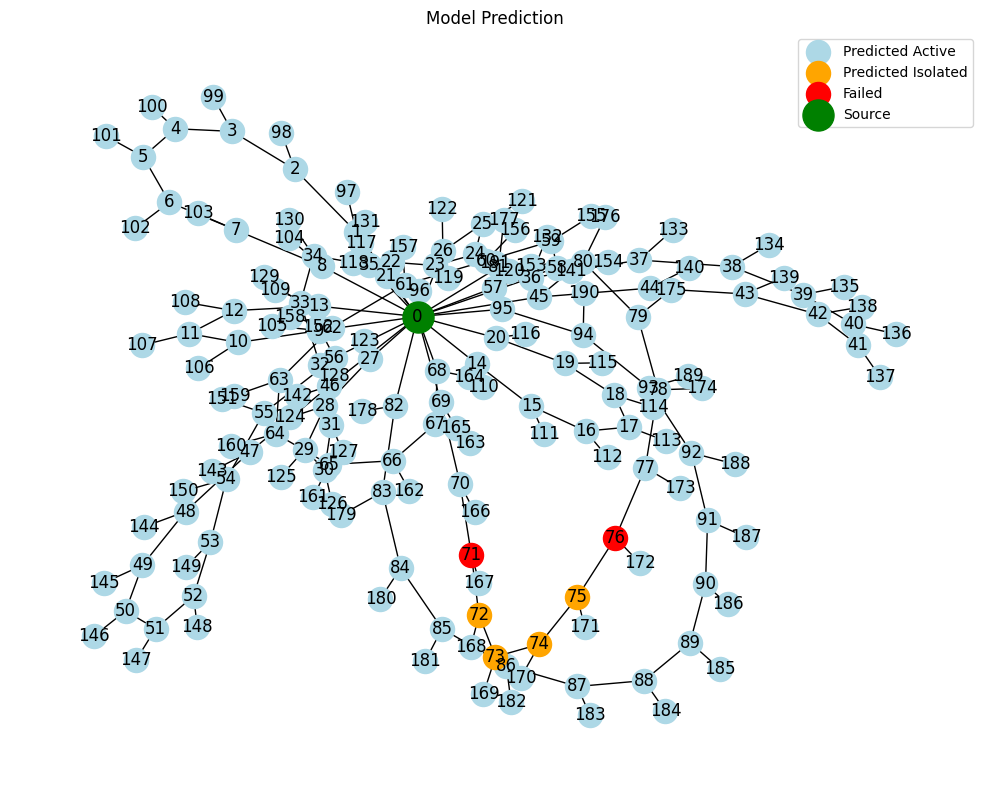

Failed nodes: [71, 76]
Failed edges: []
Predicted isolated nodes: [72, 73, 74, 75]


(Data(
   x=[192, 3],
   edge_index=[2, 402],
   edge_attr=[402, 1],
   failed_nodes=[2],
   failed_edges=[0],
   node_mapping={
     0=0,
     1=1,
     2=2,
     3=3,
     4=4,
     5=5,
     6=6,
     7=7,
     8=8,
     9=9,
     10=10,
     11=11,
     12=12,
     13=13,
     14=14,
     15=15,
     16=16,
     17=17,
     18=18,
     19=19,
     20=20,
     21=21,
     22=22,
     23=23,
     24=24,
     25=25,
     26=26,
     27=27,
     28=28,
     29=29,
     30=30,
     31=31,
     32=32,
     33=33,
     34=34,
     35=35,
     36=36,
     37=37,
     38=38,
     39=39,
     40=40,
     41=41,
     42=42,
     43=43,
     44=44,
     45=45,
     46=46,
     47=47,
     48=48,
     49=49,
     50=50,
     51=51,
     52=52,
     53=53,
     54=54,
     55=55,
     56=56,
     57=57,
     58=58,
     59=59,
     60=60,
     61=61,
     62=62,
     63=63,
     64=64,
     65=65,
     66=66,
     67=67,
     68=68,
     69=69,
     70=70,
     71=71,
     72=72,
     73=73,
   

In [218]:
test_model_with_custom_failures_with_ups(model_multi_ring_with_ups,G)

In [83]:
# Create a multi-ring graph with failures
import networkx as nx
import random

# Parameters
num_rings = 3
nodes_per_ring = 5
source_node_id = 0

# Create empty graph
G = nx.Graph()

# Add source node
G.add_node(source_node_id, failed=False,is_block=True)

# Track all nodes for visualization
all_nodes = [source_node_id]
next_node_id = source_node_id + 1

# Generate multiple rings
for ring in range(num_rings):
    # Create ring nodes
    ring_nodes = list(range(next_node_id, next_node_id + nodes_per_ring))
    all_nodes.extend(ring_nodes)
    
    # Add nodes to graph
    for node in ring_nodes:
        # Mark one node as failed in the first ring
        if ring == 0 and node == next_node_id + 2 or node == next_node_id + 4:
            G.add_node(node, failed=True)
        else:
            G.add_node(node, failed=False)
    
    # Connect nodes in sequence to form the ring segment
    for i in range(len(ring_nodes) - 1):
        G.add_edge(ring_nodes[i], ring_nodes[i+1], failed=False)
    
    # Close the ring through source node
    G.add_edge(source_node_id, ring_nodes[0], failed=False)
    
    # Mark the last connection as failed in the second ring
    if ring == 1:
        G.add_edge(source_node_id, ring_nodes[-1], failed=True)
    else:
        G.add_edge(source_node_id, ring_nodes[-1], failed=False)
    
    # Update next node ID
    next_node_id += nodes_per_ring

existing_nodes = list(G.nodes())
next_ups_id = max(existing_nodes) + 1

# Add a UPS node for each existing node
for node in existing_nodes:
    # Create UPS node with special attribute
    G.add_node(next_ups_id, is_failed=False, is_ups=True)
    
    # Connect UPS node only to its parent node
    G.add_edge(node, next_ups_id, is_failed=False)
    
    next_ups_id += 1
# The graph G now contains multiple rings with some failures
# Each ring connects to the source node at two points

tensor([1.2538e-09, 2.4439e-06, 2.4191e-02, 9.8326e-01, 9.9610e-01, 5.4589e-06,
        1.4999e-08, 1.5615e-03, 9.4150e-04, 5.3154e-02, 4.1909e-06, 1.7986e-08,
        1.8060e-03, 1.1177e-03, 5.5460e-02, 5.8518e-06])


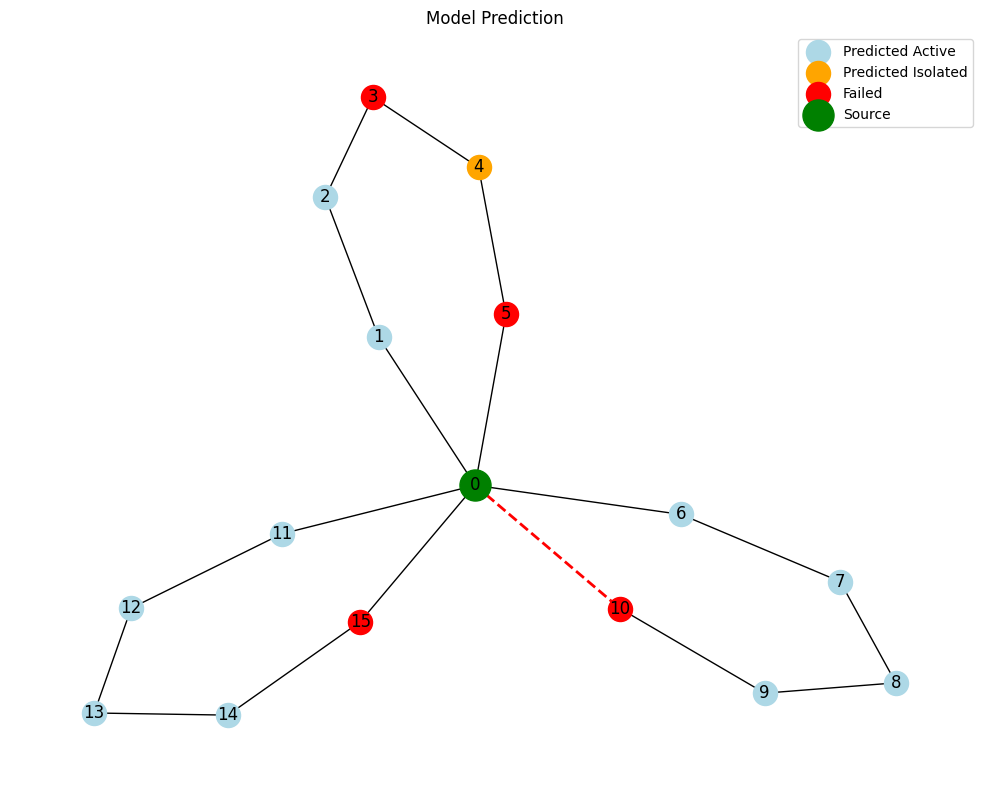

Failed nodes: [3, 5, 10, 15]
Failed edges: [(0, 10)]
Predicted isolated nodes: [4]


(Data(
   x=[16, 2],
   edge_index=[2, 36],
   edge_attr=[36, 1],
   failed_nodes=[4],
   failed_edges=[1],
   node_mapping={
     0=0,
     1=1,
     2=2,
     3=3,
     4=4,
     5=5,
     6=6,
     7=7,
     8=8,
     9=9,
     10=10,
     11=11,
     12=12,
     13=13,
     14=14,
     15=15,
   }
 ),
 tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [86]:
test_model_with_custom_failures(model_multi_ring,G)

In [86]:
def v2_test_model_with_custom_failures(model, num_nodes=10, source_node_id=0, failed_nodes=None, failed_edges=None, num_other_rings=2, nodes_per_other_ring=3):
    """
    Test the model with manually specified failed nodes and edges.
    Also adds dummy nodes from other rings connected to the same source node,
    with each ring closed through the source node.
    
    Args:
        model: Trained IsolationGNN model
        num_nodes: Number of regular nodes in the ring (excluding source)
        source_node_id: ID of the source node
        failed_nodes: List of node IDs that should be marked as failed
        failed_edges: List of edges (as tuples) that should be marked as failed
        num_other_rings: Number of other rings to connect to the source node
        nodes_per_other_ring: Number of nodes in each additional ring
    
    Returns:
        None (displays visualization)
    """
    if failed_nodes is None:
        failed_nodes = []
    if failed_edges is None:
        failed_edges = []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Create the base ring network
    G = nx.Graph()
    total_nodes = num_nodes + 1  # Including source node
    
    for i in range(total_nodes):
        G.add_node(i)
    
    for i in range(total_nodes):
        next_node = (i + 1) % total_nodes
        G.add_edge(i, next_node)
    
    # Add dummy nodes from other rings connected to the source node
    dummy_node_start = total_nodes
    dummy_nodes = []
    
    # Create nodes and edges for other rings
    for ring in range(num_other_rings):
        ring_nodes = []
        
        # Add nodes for this ring
        for i in range(nodes_per_other_ring):
            node_id = dummy_node_start + i
            G.add_node(node_id)
            ring_nodes.append(node_id)
            dummy_nodes.append(node_id)
        
        # Connect these nodes to form a ring WITH the source node
        # First connect all dummy nodes sequentially
        for i in range(len(ring_nodes) - 1):
            G.add_edge(ring_nodes[i], ring_nodes[i+1])
            
        # Then close the ring by connecting first and last dummy nodes to the source
        G.add_edge(source_node_id, ring_nodes[0])
        G.add_edge(source_node_id, ring_nodes[-1])
        
        # Update starting index for next ring
        dummy_node_start += nodes_per_other_ring
    
    # Normalize edge format
    normalized_failed_edges = []
    for u, v in failed_edges:
        if (u, v) in G.edges() or (v, u) in G.edges():
            normalized_failed_edges.append((min(u, v), max(u, v)))
    
    # Prepare node features
    x = torch.zeros((G.number_of_nodes(), 2), dtype=torch.float)
    
    # Set features for all nodes
    for i in range(G.number_of_nodes()):
        # Is source node
        x[i, 0] = 1.0 if i == source_node_id else 0.0
        
        # Node status (1 = failed, 0 = active)
        x[i, 1] = 1.0 if i in failed_nodes else 0.0
    
    # Prepare edges and edge features
    edge_index = []
    edge_attr = []
    
    for u, v in G.edges():
        # Add both directions for undirected graph
        edge_index.append([u, v])
        edge_index.append([v, u])
        
        # Mark edge status (1 = failed, 0 = active)
        is_failed = 1.0 if (min(u, v), max(u, v)) in normalized_failed_edges else 0.0
        edge_attr.append([is_failed])
        edge_attr.append([is_failed])
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Create the data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.failed_nodes = failed_nodes
    data.failed_edges = normalized_failed_edges
    
    # Get model prediction
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
        pred = (out > 0.5).float()
    
    # Create visualization
    G_vis = nx.Graph()
    
    # Add all nodes
    for i in range(G.number_of_nodes()):
        G_vis.add_node(i)
    
    # Add edges
    for u, v in G.edges():
        G_vis.add_edge(u, v)
    
    # Setup visualization with different layout to better show the multiple rings
    pos = nx.spring_layout(G_vis, seed=42)  # Spring layout works better for multiple rings
    
    # Create figure with one subplot (just predictions)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Draw nodes by predicted category
    predicted_isolated = []
    predicted_active = []
    other_ring_nodes = []
    
    for i in range(G.number_of_nodes()):
        if i in failed_nodes or i == source_node_id:
            continue  # Skip failed nodes and source
            
        if i in dummy_nodes:
            other_ring_nodes.append(i)
        elif pred[i] > 0.5:
            predicted_isolated.append(i)
        else:
            predicted_active.append(i)
    
    nx.draw_networkx_nodes(G_vis, pos, nodelist=predicted_active, 
                         node_color='lightblue', node_size=300, label='Predicted Active')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=predicted_isolated, 
                         node_color='orange', node_size=300, label='Predicted Isolated')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=other_ring_nodes, 
                         node_color='lightgreen', node_size=200, label='Other Ring Nodes')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=failed_nodes, 
                         node_color='red', node_size=300, label='Failed')
    nx.draw_networkx_nodes(G_vis, pos, nodelist=[source_node_id], 
                         node_color='green', node_size=500, label='Source')
    
    # Draw edges
    failed_edge_list = normalized_failed_edges
    working_edge_list = [(u, v) for u, v in G.edges() if (min(u, v), max(u, v)) not in failed_edge_list]
    
    nx.draw_networkx_edges(G_vis, pos, edgelist=working_edge_list)
    nx.draw_networkx_edges(G_vis, pos, edgelist=failed_edge_list, 
                         style='dashed', edge_color='red', width=2)
    nx.draw_networkx_labels(G_vis, pos)
    
    ax.set_title("Model Prediction with Multiple Rings")
    ax.legend()
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"Failed nodes: {failed_nodes}")
    print(f"Failed edges: {normalized_failed_edges}")
    print(f"Predicted isolated nodes: {predicted_isolated}")
    
    return data, pred

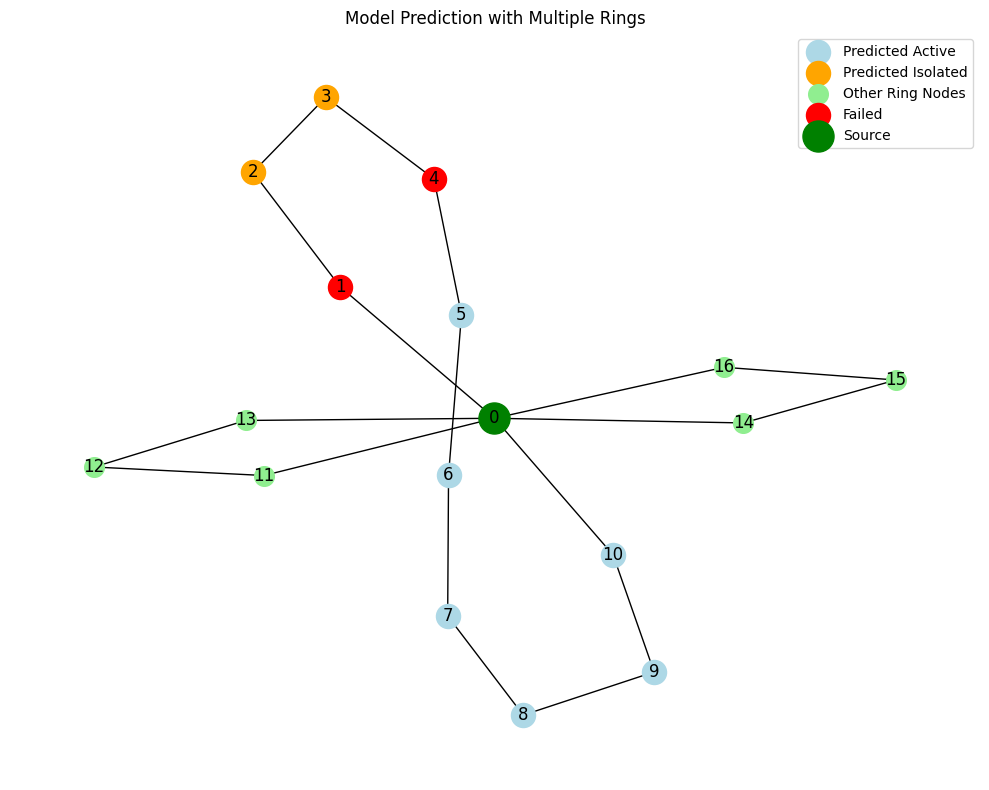

Failed nodes: [1, 4]
Failed edges: []
Predicted isolated nodes: [2, 3]


(Data(x=[17, 2], edge_index=[2, 38], edge_attr=[38, 1], failed_nodes=[2], failed_edges=[0]),
 tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [116]:
v2_test_model_with_custom_failures(model_multi_ring,failed_nodes=[1,4],failed_edges=[])

In [77]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [29]:
class CustomRuleDataset(Dataset):
    def __init__(self, num_nodes=10, source_node_id=0, num_samples=1000, transform=None, 
                 isolation_ratio=0.5):
        """
        Create a dataset with custom isolation rules for GNN training.
        
        Custom Rule: A node is isolated if and only if there are at least two failures
        (nodes or edges) on both sides of the node in the ring.
        
        Args:
            num_nodes: Number of regular nodes (excluding source node)
            source_node_id: ID of the source node
            num_samples: Number of failure scenarios to generate
            transform: Optional transform to apply to the data
            isolation_ratio: Target ratio of samples with at least one isolated node
        """
        super(CustomRuleDataset, self).__init__(transform)
        self.num_nodes = num_nodes
        self.source_node_id = source_node_id
        self.total_nodes = num_nodes + 1  # Including source node
        self.num_samples = num_samples
        self.isolation_ratio = isolation_ratio
        self.samples = self._generate_samples()
    
    def _generate_samples(self):
        """Generate all samples for the dataset with the custom isolation rule"""
        # Create the base ring network
        G = nx.Graph()
        for i in range(self.total_nodes):
            G.add_node(i)
        
        for i in range(self.total_nodes):
            next_node = (i + 1) % self.total_nodes
            G.add_edge(i, next_node)
        
        # All possible edges and nodes (excluding source node for failures)
        all_edges = list(G.edges())
        all_nodes = [n for n in G.nodes() if n != self.source_node_id]
        
        samples = []
        isolated_count = 0
        non_isolated_count = 0
        target_isolated = int(self.num_samples * self.isolation_ratio)
        target_non_isolated = self.num_samples - target_isolated
        
        # Keep generating until we have enough samples
        while len(samples) < self.num_samples:
            # Adjust failure probabilities based on current ratio
            if isolated_count < target_isolated:
                # Generate more failures to increase likelihood of isolation
                min_failures = 4
                max_failures = 8
            else:
                # Generate fewer failures to decrease likelihood of isolation
                min_failures = 1
                max_failures = 3
            
            # Generate random number of failures
            num_failures = random.randint(min_failures, max_failures)
            
            # Randomly split failures between nodes and edges
            num_node_failures = random.randint(0, num_failures)
            num_edge_failures = num_failures - num_node_failures
            
            # Select which nodes will fail
            candidate_nodes = all_nodes.copy()
            random.shuffle(candidate_nodes)
            failed_nodes = candidate_nodes[:num_node_failures]
            
            # Select which edges will fail
            candidate_edges = all_edges.copy()
            random.shuffle(candidate_edges)
            failed_edges = candidate_edges[:num_edge_failures]
            
            # Determine isolated nodes using our custom rule
            isolated_nodes = self._find_custom_isolated_nodes(
                G, failed_nodes, failed_edges, self.source_node_id
            )
            
            # Decide whether to keep this sample based on our target ratios
            has_isolation = len(isolated_nodes) > 0
            
            if has_isolation and isolated_count < target_isolated:
                # Accept an isolation case
                isolated_count += 1
                data = self._create_gnn_data(G, failed_nodes, failed_edges, isolated_nodes)
                samples.append(data)
            elif not has_isolation and non_isolated_count < target_non_isolated:
                # Accept a non-isolation case
                non_isolated_count += 1
                data = self._create_gnn_data(G, failed_nodes, failed_edges, isolated_nodes)
                samples.append(data)
            
            # Print progress occasionally
            if len(samples) % 100 == 0 and len(samples) > 0:
                print(f"Generated {len(samples)}/{self.num_samples} samples " +
                      f"({isolated_count} with isolation, {non_isolated_count} without)")
        
        print(f"Final dataset: {isolated_count} samples with isolation, " +
              f"{non_isolated_count} without isolation")
        return samples
    
    def _generate_no_isolation_sample(self, G, all_nodes, all_edges):
        """
        Generate a specific sample with no isolated nodes according to our custom rule.
        This helps balance the dataset when needed.
        """
        # Strategy 1: Use only 1 failure on each side
        # This ensures we don't meet the "2 failures on both sides" requirement
        
        # Pick random points around the ring
        positions = list(range(self.total_nodes))
        positions.remove(self.source_node_id)  # Don't fail the source
        random.shuffle(positions)
        
        # Choose 2-3 positions evenly distributed
        failure_positions = positions[:3]
        
        # Create either node or edge failures at these positions
        failed_nodes = []
        failed_edges = []
        
        for pos in failure_positions:
            if random.random() < 0.5:  # 50% chance of node failure
                failed_nodes.append(pos)
            else:  # 50% chance of edge failure
                next_pos = (pos + 1) % self.total_nodes
                failed_edges.append((pos, next_pos))
        
        # Verify no nodes are isolated with our custom rule
        isolated_nodes = self._find_custom_isolated_nodes(
            G, failed_nodes, failed_edges, self.source_node_id
        )
        
        # If somehow we still have isolation, try a different approach
        if isolated_nodes:
            # Strategy 2: Just use 1-2 failures total
            if random.random() < 0.5:
                # Single node failure
                node = random.choice(all_nodes)
                return [node], []
            else:
                # Single edge failure
                edge = random.choice(all_edges)
                return [], [edge]
        
        return failed_nodes, failed_edges

    def _find_custom_isolated_nodes(self, G, failed_nodes, failed_edges, source_node_id):
        """
        Find nodes that are isolated according to our custom rule:
        A node is isolated if and only if there are at least two failures
        (nodes or edges) on both sides of the node in the ring.
        """
        isolated_nodes = []
        total_nodes = G.number_of_nodes()
        
        # Normalize failed edges format
        normalized_failed_edges = [(min(u, v), max(u, v)) for u, v in failed_edges]
        
        # Helper function to check if a node or edge exists in the failures
        def is_failure_at(node_id, next_node_id):
            if node_id in failed_nodes or next_node_id in failed_nodes:
                return True
            edge = (min(node_id, next_node_id), max(node_id, next_node_id))
            return edge in normalized_failed_edges
        
        # For each non-source, non-failed node
        for node in range(total_nodes):
            if node == source_node_id or node in failed_nodes:
                continue
                
            # Count failures in clockwise direction
            clockwise_failures = 0
            curr = node
            for _ in range(total_nodes):  # Limit to avoid infinite loop
                next_node = (curr + 1) % total_nodes
                if is_failure_at(curr, next_node):
                    clockwise_failures += 1
                    if clockwise_failures >= 2:
                        break
                curr = next_node
            
            # Count failures in counter-clockwise direction
            counter_failures = 0
            curr = node
            for _ in range(total_nodes):  # Limit to avoid infinite loop
                prev_node = (curr - 1) % total_nodes
                if is_failure_at(prev_node, curr):
                    counter_failures += 1
                    if counter_failures >= 2:
                        break
                curr = prev_node
            
            # Node is isolated if there are at least 2 failures on each side
            if clockwise_failures >= 2 and counter_failures >= 2:
                isolated_nodes.append(node)
        
        return isolated_nodes
        
    def _create_gnn_data(self, G, failed_nodes, failed_edges, isolated_nodes):
        """Convert network state to PyTorch Geometric Data object"""
        # Prepare node features 
        # Features: [is_source, is_failed]
        x = torch.zeros((self.total_nodes, 2), dtype=torch.float)
        
        # Set features for all nodes
        for i in range(self.total_nodes):
            # Is source node
            x[i, 0] = 1.0 if i == self.source_node_id else 0.0
            
            # Node status (1 = failed, 0 = active)
            x[i, 1] = 1.0 if i in failed_nodes else 0.0
        
        # Extract all edges from the graph (including failed ones)
        edge_index = []
        edge_attr = []  # Will contain edge features (1 = failed, 0 = active)
        
        for u, v in G.edges():
            # Add edges in both directions for undirected graph
            edge_index.append([u, v])
            edge_index.append([v, u])
            
            # Mark edge status (1 = failed, 0 = active)
            is_failed = 1.0 if (min(u, v), max(u, v)) in [(min(a, b), max(a, b)) for a, b in failed_edges] else 0.0
            edge_attr.append([is_failed])
            edge_attr.append([is_failed])  # Same attribute for both directions
        
        # Convert to tensors
        edge_index = torch.tensor(edge_index, dtype=torch.long).t()  # Transpose to get 2xE
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        
        # Prepare labels: 1 for isolated nodes, 0 for non-isolated
        y = torch.zeros(self.total_nodes, dtype=torch.float)
        for node in isolated_nodes:
            y[node] = 1.0
        
        # Create the data object with edge attributes
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        
        # Store metadata for reference
        data.failed_nodes = failed_nodes
        data.failed_edges = failed_edges
        data.isolated_nodes = isolated_nodes
        
        return data
    
    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.samples)
    
    def __getitem__(self, idx):
        """Get a sample from the dataset"""
        return self.samples[idx]
    


    def visualize_sample(self, idx):
        """
        Visualize a specific sample, focusing only on the logical ring
        containing isolated nodes. Uses proper LR name normalization.
        """
        data = self.samples[idx]
        
        # Reconstruct full graph first
        G = nx.Graph()
        
        # Add nodes with their properties
        for i, node_id in enumerate(data.node_ids):
            is_block = bool(data.x[i, 0])
            is_failed = bool(data.x[i, 1])
            is_isolated = bool(data.y[i])
            
            # Get original node attributes from base graph
            original_attrs = {}
            if self.base_graph.has_node(node_id):
                original_attrs = self.base_graph.nodes[node_id]
            
            # Normalize LR name the same way as in get_ring_node_mapping
            lr_name_original = original_attrs.get('lr_name')
            lr_name_normalized = None
            if lr_name_original:
                # Enhanced regex to capture numbers after various separators or at the end
                number_match = re.search(r'(?:no\.?|[-\s]|RING-|RING\s*)(\d+)', lr_name_original, re.IGNORECASE)
                if not number_match:  # Try finding number at the end if first regex failed
                    number_match = re.search(r'(\d+)$', lr_name_original)

                if number_match:
                    lr_name_normalized = str(int(number_match.group(1)))
            
            # Add all attributes with normalized LR name
            G.add_node(node_id, 
                    is_block=is_block, 
                    is_failed=is_failed, 
                    is_isolated=is_isolated,
                    pr_name=original_attrs.get('pr_name', 'unknown'),
                    lr_name_original=lr_name_original,
                    lr_name=lr_name_normalized,  # Store normalized version for matching
                    block_ip=original_attrs.get('block_ip', None),
                    name=original_attrs.get('name', f"Node-{node_id}"))
        
        # Add edges
        edge_idx = data.edge_index.t().numpy()
        for i, (src_idx, dst_idx) in enumerate(edge_idx):
            src_id = data.node_ids[src_idx]
            dst_id = data.node_ids[dst_idx]
            is_failed = bool(data.edge_attr[i, 0])
            
            G.add_edge(src_id, dst_id, is_failed=is_failed)
        
        # Find rings with isolated nodes
        isolated_rings = set()
        isolated_node_list = data.isolated_nodes
        
        if not isolated_node_list:
            print("No isolated nodes in this sample, showing a random ring instead.")
            # Get a random ring from any node
            random_node = random.choice(list(G.nodes()))
            if G.has_node(random_node):
                ring_key = (G.nodes[random_node].get('pr_name', 'unknown'), 
                        G.nodes[random_node].get('lr_name', 'unknown'))
                isolated_rings.add(ring_key)
        else:
            # Find rings containing isolated nodes
            for node in isolated_node_list:
                if G.has_node(node):
                    pr_name = G.nodes[node].get('pr_name', 'unknown')
                    lr_name = G.nodes[node].get('lr_name', 'unknown')  # Using the normalized version
                    if pr_name != 'unknown' and lr_name != 'unknown':
                        isolated_rings.add((pr_name, lr_name))
        
        # If no valid rings found, use the whole graph
        if not isolated_rings or all(k[0] == 'unknown' for k in isolated_rings):
            print("Couldn't identify specific rings, showing entire graph.")
            ring_subgraph = G
            ring_name = "Multiple/Unknown Rings"
        else:
            # Select the first isolated ring for visualization
            target_ring = list(isolated_rings)[0]
            ring_name = f"PR: {target_ring[0]}, LR: {target_ring[1]}"
            print(f"Focusing on ring: {ring_name}")
            
            # Get all nodes in this ring using normalized LR name
            ring_nodes = [n for n, d in G.nodes(data=True) 
                        if d.get('pr_name') == target_ring[0] and d.get('lr_name') == target_ring[1]]
            
            # Add block routers connected to these nodes
            block_ips = set()
            for node in ring_nodes:
                block_ip = G.nodes[node].get('block_ip')
                if block_ip and G.has_node(block_ip):
                    block_ips.add(block_ip)
            
            # Create the focused subgraph
            nodes_to_include = set(ring_nodes) | block_ips
            
            # Check if we have enough nodes for a meaningful visualization
            if len(nodes_to_include) < 3:
                print(f"Ring {ring_name} has too few nodes, showing entire graph.")
                ring_subgraph = G
            else:
                ring_subgraph = G.subgraph(nodes_to_include).copy()
        
        # Visualize the ring subgraph
        plt.figure(figsize=(12, 10))
        
        # Use a circular layout for better ring visualization
        if len(ring_subgraph) < 20:  # For smaller graphs, circular layout works better
            pos = nx.circular_layout(ring_subgraph)
        else:
            pos = nx.spring_layout(ring_subgraph, seed=42)
        
        # Draw different node types
        block_nodes = [n for n, d in ring_subgraph.nodes(data=True) if d.get('is_block', False)]
        failed_nodes = [n for n, d in ring_subgraph.nodes(data=True) if d.get('is_failed', False)]
        isolated_nodes = [n for n, d in ring_subgraph.nodes(data=True) 
                        if d.get('is_isolated', False) and not d.get('is_failed', False)]
        normal_nodes = [n for n, d in ring_subgraph.nodes(data=True) 
                    if not d.get('is_block', False) and not d.get('is_failed', False) 
                    and not d.get('is_isolated', False)]
        
        # Draw normal nodes
        if normal_nodes:
            nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=normal_nodes, 
                                node_color='blue', node_size=300, alpha=0.7,
                                label='Normal Nodes')
        
        # Draw block routers
        if block_nodes:
            nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=block_nodes, 
                                node_color='red', node_size=500, alpha=0.8,
                                label='Block Routers')
        
        # Draw failed nodes
        if failed_nodes:
            nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=failed_nodes, 
                                node_color='black', node_size=300, alpha=0.8,
                                label='Failed Nodes')
        
        # Draw isolated nodes
        if isolated_nodes:
            nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=isolated_nodes, 
                                node_color='yellow', node_size=300, alpha=0.8,
                                label='Isolated Nodes')
        
        # Draw edges
        working_edges = [(u, v) for u, v, d in ring_subgraph.edges(data=True) if not d.get('is_failed', False)]
        failed_edges = [(u, v) for u, v, d in ring_subgraph.edges(data=True) if d.get('is_failed', False)]
        
        nx.draw_networkx_edges(ring_subgraph, pos, edgelist=working_edges, width=1.0, alpha=0.5)
        nx.draw_networkx_edges(ring_subgraph, pos, edgelist=failed_edges, width=1.5, 
                            alpha=0.7, style='dashed', edge_color='red', label='Failed Links')
        
        # Draw labels with more useful information
        labels = {node: f"{ring_subgraph.nodes[node].get('name', '').split('-')[-1]}\n{str(node).split('.')[-1]}" 
                for node in ring_subgraph.nodes()}
        
        nx.draw_networkx_labels(ring_subgraph, pos, labels=labels, font_size=8)
        
        # Add title with more detail
        plt.title(f"Sample {idx}: Ring {ring_name}\n"
                f"{len(data.failed_nodes)} failed nodes, {len(data.failed_edges)} failed edges, "
                f"{len(data.isolated_nodes)} isolated nodes")
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print details
        print(f"Sample {idx} details:")
        print(f"Failed nodes: {data.failed_nodes}")
        print(f"Failed edges: {data.failed_edges}")
        print(f"Isolated nodes: {data.isolated_nodes}")
        
        # Print information about why isolation occurred
        if isolated_nodes:
            print("\nIsolation analysis:")
            for node in isolated_nodes:
                block_ip = G.nodes[node].get('block_ip', 'unknown')
                print(f"Node {node} (in ring {G.nodes[node].get('pr_name', 'unknown')}, "
                    f"{G.nodes[node].get('lr_name_original', 'unknown')}) is isolated from block router {block_ip}")

Generated 100/5000 samples (100 with isolation, 0 without)
Generated 200/5000 samples (200 with isolation, 0 without)
Generated 300/5000 samples (300 with isolation, 0 without)
Generated 400/5000 samples (400 with isolation, 0 without)
Generated 500/5000 samples (500 with isolation, 0 without)
Generated 600/5000 samples (600 with isolation, 0 without)
Generated 700/5000 samples (700 with isolation, 0 without)
Generated 800/5000 samples (800 with isolation, 0 without)
Generated 900/5000 samples (900 with isolation, 0 without)
Generated 1000/5000 samples (1000 with isolation, 0 without)
Generated 1100/5000 samples (1100 with isolation, 0 without)
Generated 1200/5000 samples (1200 with isolation, 0 without)
Generated 1300/5000 samples (1300 with isolation, 0 without)
Generated 1400/5000 samples (1400 with isolation, 0 without)
Generated 1500/5000 samples (1500 with isolation, 0 without)
Generated 1600/5000 samples (1600 with isolation, 0 without)
Generated 1700/5000 samples (1700 with iso

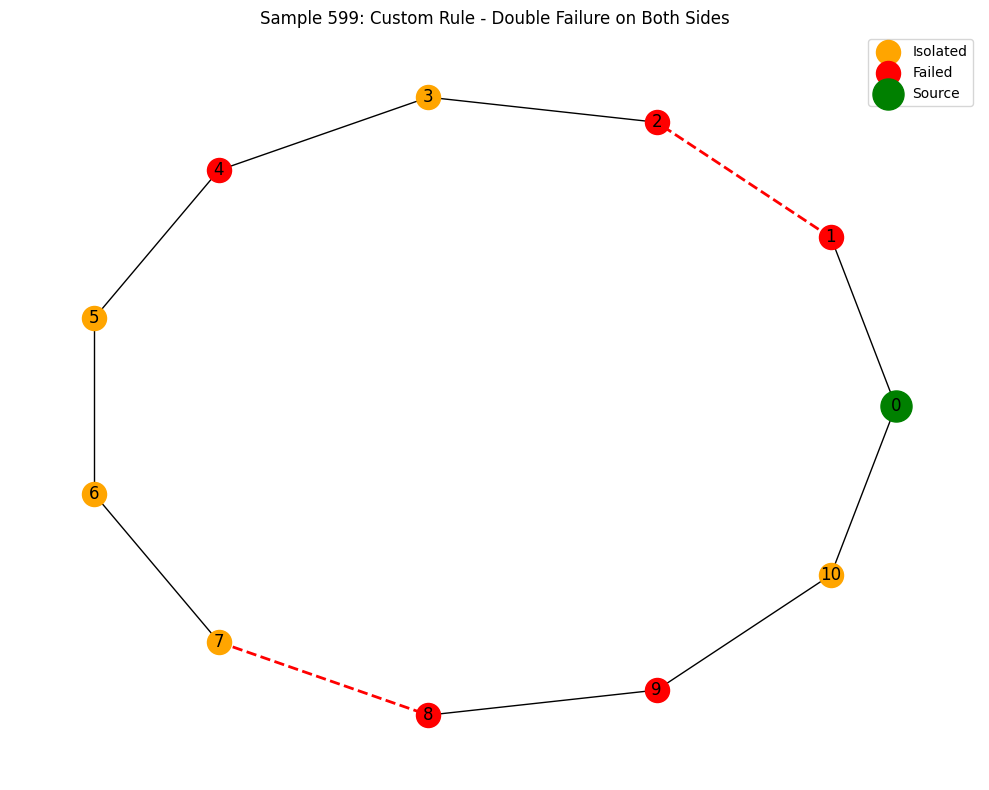

Failed nodes: [8, 4, 9, 1, 2]
Failed edges: [(7, 8), (1, 2)]
Isolated nodes (by custom rule): [3, 5, 6, 7, 10]
Visualizing sample 1570:


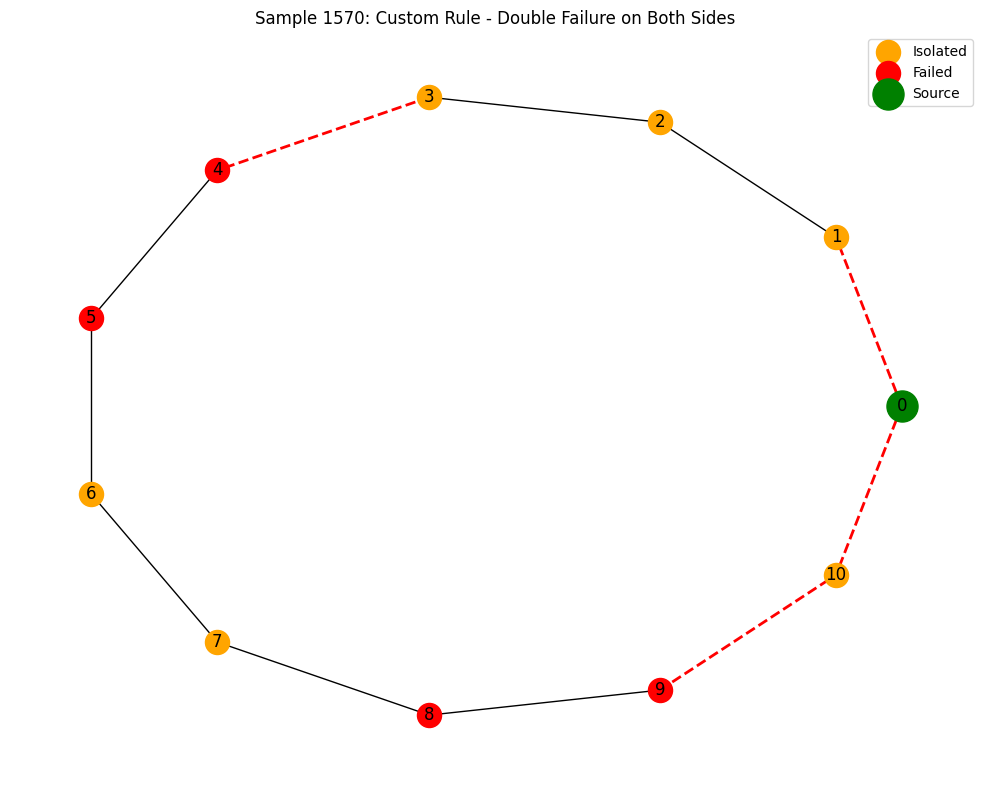

Failed nodes: [4, 5, 8, 9]
Failed edges: [(0, 1), (0, 10), (9, 10), (3, 4)]
Isolated nodes (by custom rule): [1, 2, 3, 6, 7, 10]
Visualizing sample 250:


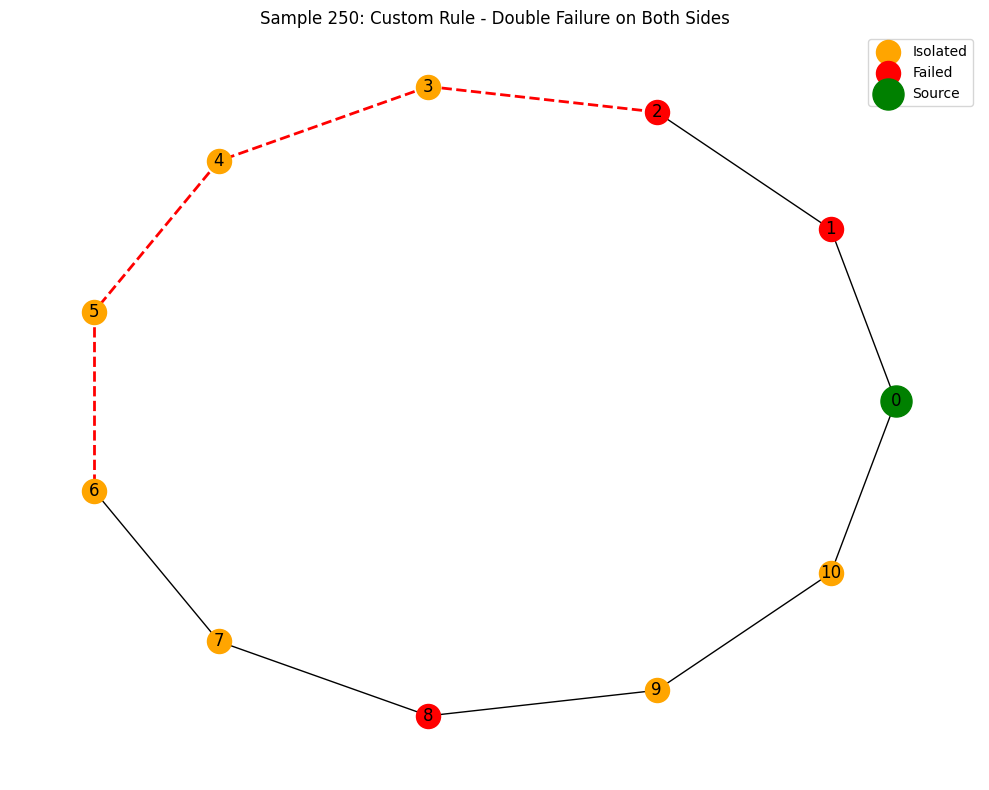

Failed nodes: [1, 2, 8]
Failed edges: [(5, 6), (2, 3), (4, 5), (3, 4)]
Isolated nodes (by custom rule): [3, 4, 5, 6, 7, 9, 10]
Samples with isolated nodes: 2500/5000 (50.0%)
Using device: cpu
Epoch 1/200, Loss: 0.1631, Test Acc: 0.9972, F1: 0.9965, Precision: 1.0000, Recall: 0.9930
Epoch 2/200, Loss: 0.0119, Test Acc: 0.9999, F1: 0.9999, Precision: 1.0000, Recall: 0.9997
Perfect F1 score achieved! Stopping training early at epoch 2

Final Test Results:
  Accuracy: 0.9999
  F1 Score: 0.9999
  Precision: 1.0000
  Recall: 0.9997


In [38]:
def train_custom_rule_model():
    # Create dataset with custom rule
    custom_dataset = CustomRuleDataset(
        num_nodes=10,
        source_node_id=0,
        num_samples=5000  # More samples may be needed for this complex rule
    )
    
    # Visualize a few samples to verify
    for i in range(3):
        sample_idx = random.randint(0, len(custom_dataset)-1)
        print(f"Visualizing sample {sample_idx}:")
        custom_dataset.visualize_sample(sample_idx)
    
    # Count how many samples have isolated nodes
    isolated_count = sum(1 for i in range(len(custom_dataset)) 
                         if len(custom_dataset[i].isolated_nodes) > 0)
    print(f"Samples with isolated nodes: {isolated_count}/{len(custom_dataset)} "
          f"({100*isolated_count/len(custom_dataset):.1f}%)")
    
    # The custom rule may be more complex, so we might need:
    # 1. More message passing layers to capture longer-range dependencies
    # 2. Larger hidden dimension to represent more complex patterns
    # 3. More epochs for training to converge
    
    model = train_isolation_model(
        dataset=custom_dataset,
        epochs=200,          # More epochs
        batch_size=32,
        lr=0.001
    )
    
    return model, custom_dataset

# Run the training
custom_rule_model, custom_dataset = train_custom_rule_model()

In [33]:
def setup_database():
    """Initialize database connection and create tables if needed"""
    config = configparser.ConfigParser()
    config.read("config.ini")
    db_config = {
        "host": config["mysql"]["host"],
        "user": config["mysql"]["user"],
        "password": config["mysql"]["password"],
        "database": config["mysql"]["database"]
    }
    mydb = mysql.connector.connect(**db_config)
    cursor = mydb.cursor(dictionary=True, buffered=True)
    
    # Create table if not exists
    create_table_query = """
    CREATE TABLE IF NOT EXISTS dummy_cam (
        id INT AUTO_INCREMENT PRIMARY KEY,
        rca_id VARCHAR(255),
        child_id TEXT,
        timestamp TEXT
    )
    """
    cursor.execute(create_table_query)
    mydb.commit()
    
    return mydb, cursor


In [35]:
import logging

# Setup logging
def setup_logging():
    """Configure logging to file and console"""
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s %(levelname)s:\n%(message)s\n',
        handlers=[
            logging.FileHandler("gnnv3.log", mode="a"),
            
        ]
    )



In [36]:
def load_topology(cursor):
    """Load and build network topology graph from database"""
    query_log_topo = """
        SELECT 
           aendname, 
           bendname, 
           aendip, 
           bendip, 
           block_name, 
           physicalringname, 
           lrname 
        FROM topology_data_logical
    """
    cursor.execute(query_log_topo)
    topology_logical = cursor.fetchall()
    
    # Create topology graph
    topology_graph = nx.Graph()
    for row in topology_logical:
        aend = row["aendip"]
        bend = row["bendip"]
        aendname = row["aendname"].upper()
        bendname = row["bendname"].upper()
        pr_name = row["physicalringname"].upper()
        lr_name = row["lrname"].upper()
        block_name = row["block_name"].upper()
         
        topology_graph.add_node(aend, name=aendname, lr_name=lr_name, pr_name=pr_name, block_name=block_name)
        topology_graph.add_node(bend, name=bendname, lr_name=lr_name, pr_name=pr_name, block_name=block_name)
        topology_graph.add_edge(aend, bend, lr_name=lr_name, pr_name=pr_name, block_name=block_name)
    
    logging.info("Topology Logical Graph created")
    return topology_graph

In [37]:
def identify_block_routers(cursor, topology_graph):
    """Identify block routers and mark them in the graph"""
    block_router_query = """
        SELECT ip 
        FROM network_element 
        WHERE devicetype = 'BLOCK_ROUTER'
    """
    cursor.execute(block_router_query)
    block_routers = cursor.fetchall()
    
    # Create a set of block router IPs for faster lookups
    block_router_ips = {router['ip'] for router in block_routers}
    logging.info(f"Found {len(block_router_ips)} BLOCK_ROUTERs")
    
    return block_router_ips

In [38]:
def remove_inter_block_connections(topology_graph, block_router_ips):
    """Remove nodes that create paths between blocks"""
    logging.info("Removing nodes that connect different blocks...")
    
    # Create a working copy of the graph for path analysis
    connection_graph = topology_graph.copy()
    
    # Track nodes to remove
    nodes_to_remove = set()
    
    # Iterative removal process
    prev_removal_count = -1
    current_removal_count = 0
    block_router_list = list(block_router_ips)
    
    while prev_removal_count != current_removal_count:
        prev_removal_count = current_removal_count
        
        # Create a temporary graph with current removals
        temp_graph = connection_graph.copy()
        temp_graph.remove_nodes_from(nodes_to_remove)
        
        # Check all pairs of block routers
        for i in range(len(block_router_list)):
            for j in range(i+1, len(block_router_list)):
                block1 = block_router_list[i]
                block2 = block_router_list[j]
                
                # Skip if either block router was removed
                if (block1 not in temp_graph.nodes or 
                    block2 not in temp_graph.nodes):
                    continue
                    
                # Find a path if one exists
                try:
                    if nx.has_path(temp_graph, block1, block2):
                        path = nx.shortest_path(temp_graph, block1, block2)
                        
                        # Add intermediate nodes to removal list
                        for node in path[1:-1]:
                            if node not in block_router_ips and node not in nodes_to_remove:
                                nodes_to_remove.add(node)
                                logging.info(f"Marking node {node} for removal (connects blocks {block1} and {block2})")
                except nx.NetworkXNoPath:
                    continue
        
        current_removal_count = len(nodes_to_remove)
        logging.info(f"Iteration complete: {current_removal_count} nodes marked for removal")
    
    # Remove nodes from the actual topology graph
    for node in nodes_to_remove:
        if topology_graph.has_node(node):
            topology_graph.remove_node(node)
    
    logging.info(f"Removed {len(nodes_to_remove)} nodes to completely isolate blocks")
    
    # Verify isolation
    components = list(nx.connected_components(topology_graph))
    logging.info(f"Topology now has {len(components)} disconnected components")
    
    return topology_graph

In [39]:
def assign_nodes_to_blocks(topology_graph, block_router_ips):
    """Assign each node to its block router"""
    for ip in block_router_ips:
        if not topology_graph.has_node(ip):
            logging.warning(f"BLOCK_ROUTER {ip} not found in topology graph")
        else:
            # Mark as block router
            topology_graph.nodes[ip]['is_block'] = True
            topology_graph.nodes[ip]['block_ip'] = ip
            
            try:
                # Get all reachable nodes using BFS
                reachable_nodes = list(nx.bfs_tree(topology_graph, ip))
                reachable_nodes.append(ip)  # Include the source node
                
                # Set block_ip for all reachable nodes
                assigned_count = 0
                for node in reachable_nodes:
                    topology_graph.nodes[node]['block_ip'] = ip
                    assigned_count += 1
                
                block_name = topology_graph.nodes[ip].get('block_name', 'Unknown')
                logging.info(f"Block router {ip} ({block_name}): {assigned_count} nodes assigned")
                
            except Exception as e:
                logging.error(f"Error assigning nodes to block router {ip}: {e}")
    
    return topology_graph

In [40]:
import re

def get_ring_node_mapping(graph):
    """
    Create a mapping from (pr_name, lr_name) tuples to their subgraphs,
    ensuring the associated block router is included in each subgraph.

    Parameters:
    -----------
    graph : NetworkX Graph
        The network topology graph with pr_name, lr_name, and block_ip attributes.

    Returns:
    --------
    dict
        Dictionary mapping (pr_name, lr_name) tuples to NetworkX subgraphs.
    """
    logging.info("Starting get_ring_node_mapping...")
    # Temporary structure to hold nodes and the block_ip for each ring
    # Format: {(pr_name, lr_name): {'nodes': {node1, node2,...}, 'block_ip': block_ip_str}}
    ring_data = {}

    # Iterate through all nodes in the graph
    logging.info("Iterating through graph nodes to collect ring data...")
    node_count = 0
    skipped_nodes = 0
    for node, attrs in graph.nodes(data=True):
        if attrs.get('is_block', False):
            continue
        node_count += 1
        # Extract ring names and block IP
        pr_name = attrs.get('pr_name')
        lr_name_original = attrs.get('lr_name')
        block_ip = attrs.get('block_ip') # Get the block_ip assigned earlier

        # Normalize lr_name to extract the number
        lr_name_normalized = None
        if lr_name_original:
            # Enhanced regex to capture numbers after various separators or at the end
            number_match = re.search(r'(?:no\.?|[-\s]|RING-|RING\s*)(\d+)', lr_name_original, re.IGNORECASE)
            if not number_match: # Try finding number at the end if first regex failed
                 number_match = re.search(r'(\d+)$', lr_name_original)

            if number_match:
                lr_name_normalized = str(int(number_match.group(1)))
                # logging.debug(f"Node {node}: Original LR '{lr_name_original}' -> Normalized LR '{lr_name_normalized}'")
            # else:
                # logging.debug(f"Node {node}: Could not normalize LR name '{lr_name_original}'")


        # Skip nodes without required ring information
        if not pr_name or not lr_name_normalized:
            # logging.debug(f"Node {node}: Skipping due to missing PR ('{pr_name}') or normalized LR ('{lr_name_normalized}')")
            skipped_nodes += 1
            continue

        # Create tuple key with normalized ring names
        ring_key = (pr_name, lr_name_normalized)
        # logging.debug(f"Node {node}: Using ring key {ring_key}")


        # Initialize entry for this ring if it doesn't exist
        if ring_key not in ring_data:
            ring_data[ring_key] = {'nodes': set(), 'block_ip': None}
            # logging.debug(f"Initialized ring_data for key {ring_key}")


        # Add the current node to the set for this ring
        ring_data[ring_key]['nodes'].add(node)
        # logging.debug(f"Added node {node} to ring key {ring_key}. Current nodes: {ring_data[ring_key]['nodes']}")


        # Store the block_ip associated with this ring
        # Assuming all nodes in a logical ring belong to the same block
        if block_ip and ring_data[ring_key]['block_ip'] is None:
            ring_data[ring_key]['block_ip'] = block_ip
            # logging.debug(f"Assigned block_ip {block_ip} to ring key {ring_key}")

        elif block_ip and ring_data[ring_key]['block_ip'] != block_ip:
            # This case indicates a potential issue in block assignment logic
            logging.warning(f"Ring {ring_key} found associated with multiple block IPs:"
                            f" Existing: {ring_data[ring_key]['block_ip']}, New: {block_ip} (from node {node}). Using the first one found.")

    logging.info(f"Finished iterating through {node_count} nodes. Skipped {skipped_nodes} nodes without full ring info.")
    logging.info(f"Collected data for {len(ring_data)} unique ring keys.")

    # Now, ensure the block router node is added to each ring's node set
    # and create the final subgraphs
    logging.info("Creating subgraphs for each ring key...")
    ring_graphs = {}
    for ring_key, data in ring_data.items():
        # logging.debug(f"Processing ring key {ring_key} for subgraph creation.")
        nodes_for_subgraph = data['nodes'].copy() # Start with nodes found in the ring
        block_ip_for_ring = data['block_ip']
        # logging.debug(f"  Initial nodes for subgraph: {nodes_for_subgraph}")
        # logging.debug(f"  Block IP associated with this ring: {block_ip_for_ring}")


        # Add the block router node if it exists and isn't already included
        if block_ip_for_ring:
            if graph.has_node(block_ip_for_ring):
                if block_ip_for_ring not in nodes_for_subgraph:
                    nodes_for_subgraph.add(block_ip_for_ring)
                    # logging.debug(f"  Added block node {block_ip_for_ring} to subgraph node set.")
                # else:
                    # logging.debug(f"  Block node {block_ip_for_ring} was already in the node set.")

            else:
                logging.warning(f"Block IP {block_ip_for_ring} for ring {ring_key} not found in the main graph. Cannot add to subgraph.")
        # else:
            # logging.warning(f"No block IP was assigned to ring {ring_key} during node iteration.")


        # Create a subgraph containing all these nodes (ring nodes + block node) and their edges
        if nodes_for_subgraph: # Only create subgraph if there are nodes
            # logging.debug(f"  Final nodes for subgraph creation: {nodes_for_subgraph}")
            try:
                ring_graphs[ring_key] = graph.subgraph(nodes_for_subgraph).copy()
                # logging.debug(f"  Successfully created subgraph for {ring_key} with {ring_graphs[ring_key].number_of_nodes()} nodes and {ring_graphs[ring_key].number_of_edges()} edges.")
            except Exception as e:
                 logging.error(f"  Error creating subgraph for {ring_key} with nodes {nodes_for_subgraph}: {e}")

        else:
             logging.warning(f"No nodes found for ring {ring_key} after processing. Cannot create subgraph.")


    # Log summary
    logging.info(f"Finished creating subgraphs. Found {len(ring_graphs)} unique ring combinations with associated block routers.")
    for (pr, lr), subgraph in ring_graphs.items():
        # Retrieve block_ip from the original ring_data for logging consistency
        block_node_in_subgraph = ring_data.get((pr, lr), {}).get('block_ip', 'N/A')
        logging.info(f"Ring (PR:{pr}, LR:{lr}): {subgraph.number_of_nodes()} nodes (Block: {block_node_in_subgraph}), {subgraph.number_of_edges()} edges")

    logging.info("Exiting get_ring_node_mapping.")
    return ring_graphs

In [41]:
def add_ups_devices(cursor, topology_graph):
    """Add UPS devices as nodes connected to their routers"""
    logging.info("Adding UPS devices as nodes...")
    query_ups = """
        SELECT n1.ip as router_ip, n2.ip as ups_ip
        FROM network_element n1 
        JOIN network_element n2 ON n1.location = n2.location 
        WHERE n1.devicetype IN ("GP_ROUTER","BLOCK_ROUTER") 
        AND n2.devicetype IN ("GP_UPS","BLOCK_UPS")
    """
    cursor.execute(query_ups)
    router_ups_mappings = cursor.fetchall()
    
    ups_count = 0
    for mapping in router_ups_mappings:
        router_ip = mapping["router_ip"]
        ups_ip = mapping["ups_ip"]
        
        if not topology_graph.has_node(router_ip):
            logging.warning(f"Router {router_ip} not found in topology graph. Skipping UPS {ups_ip}")
            continue
            
        if not topology_graph.has_node(ups_ip):
            router_name = topology_graph.nodes[router_ip].get('name', f"Router-{router_ip}")
            ups_name = f"UPS-{router_name}"
            topology_graph.add_node(ups_ip, name=ups_name, devicetype="UPS", is_ups=True)
            ups_count += 1
        
        topology_graph.add_edge(router_ip, ups_ip, edge_type="router_ups")
        logging.info(f"Added UPS {ups_ip} connected to router {router_ip}")
    
    logging.info(f"Added {ups_count} UPS devices as nodes to the topology graph")
    return topology_graph

In [42]:
import configparser
import mysql.connector
import networkx as nx

In [43]:
setup_logging()
mydb, cursor = setup_database()

# Load network topology
global topology_logical_graph  # Declare we're using the global variable
topology_logical_graph = load_topology(cursor)

# Identify block routers
block_router_ips = identify_block_routers(cursor, topology_logical_graph)

# Isolate blocks by removing inter-block connections
topology_logical_graph = remove_inter_block_connections(topology_logical_graph, block_router_ips)


topology_logical_graph = assign_nodes_to_blocks(topology_logical_graph, block_router_ips)


# Add UPS devices
topology_logical_graph = add_ups_devices(cursor, topology_logical_graph)

In [44]:
ring_nodes = get_ring_node_mapping(topology_logical_graph)

In [45]:

import matplotlib.pyplot as plt
import random

def visualize_random_ring(ring_nodes):
    """
    Select a random ring from the ring_nodes dictionary and visualize it.
    
    Args:
        ring_nodes: Dictionary mapping (pr_name, lr_name) tuples to NetworkX subgraphs
    """
    # Select a random ring
    ring_keys = list(ring_nodes.keys())
    if not ring_keys:
        print("No rings found in the ring_nodes dictionary")
        return
    
    random_ring_key = random.choice(ring_keys)
    ring_subgraph = ring_nodes[random_ring_key]
    
    # Extract PR name and LR name for title
    pr_name, lr_name = random_ring_key
    
    # Find block router in this subgraph if any
    block_router = None
    for node, attrs in ring_subgraph.nodes(data=True):
        if attrs.get('is_block', False):
            block_router = node
            break
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Create a nice layout - circular works well for rings
    pos = nx.spring_layout(ring_subgraph, seed=42)
    
    # Draw nodes with different colors for block router
    block_nodes = [node for node, attrs in ring_subgraph.nodes(data=True) 
                  if attrs.get('is_block', False)]
    
    normal_nodes = [node for node, attrs in ring_subgraph.nodes(data=True) 
                   if not attrs.get('is_block', False)]
    
    # Draw different node types with different colors
    if normal_nodes:
        nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=normal_nodes, 
                              node_color='skyblue', node_size=500, alpha=0.8)
    
    if block_nodes:
        nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=block_nodes, 
                              node_color='red', node_size=700, alpha=0.8)
    
    # Draw UPS nodes if any
    ups_nodes = [node for node, attrs in ring_subgraph.nodes(data=True) 
                if attrs.get('is_ups', False)]
    
    if ups_nodes:
        nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=ups_nodes, 
                              node_color='green', node_size=400, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(ring_subgraph, pos, width=2, alpha=0.5)
    
    # Draw labels with IP addresses
    labels = {node: f"{attrs.get('name', 'Unknown')}\n{node}" 
             for node, attrs in ring_subgraph.nodes(data=True)}
    
    nx.draw_networkx_labels(ring_subgraph, pos, labels=labels, font_size=8)
    
    # Add title and remove axis
    plt.title(f"Ring: PR '{pr_name}', LR '{lr_name}'\n({ring_subgraph.number_of_nodes()} nodes, {ring_subgraph.number_of_edges()} edges)")
    plt.axis('off')
    
    # Print additional info
    print(f"Selected Ring: PR '{pr_name}', LR '{lr_name}'")
    print(f"Number of nodes: {ring_subgraph.number_of_nodes()}")
    print(f"Number of edges: {ring_subgraph.number_of_edges()}")
    
    if block_router:
        print(f"Block router: {block_router}")
    else:
        print("No block router found in this ring")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Just call this function with your existing ring_nodes dictionary
# visualize_random_ring(ring_nodes)

Selected Ring: PR 'FARASGAON_BLUE', LR '1'
Number of nodes: 11
Number of edges: 11
Block router: 10.128.0.48


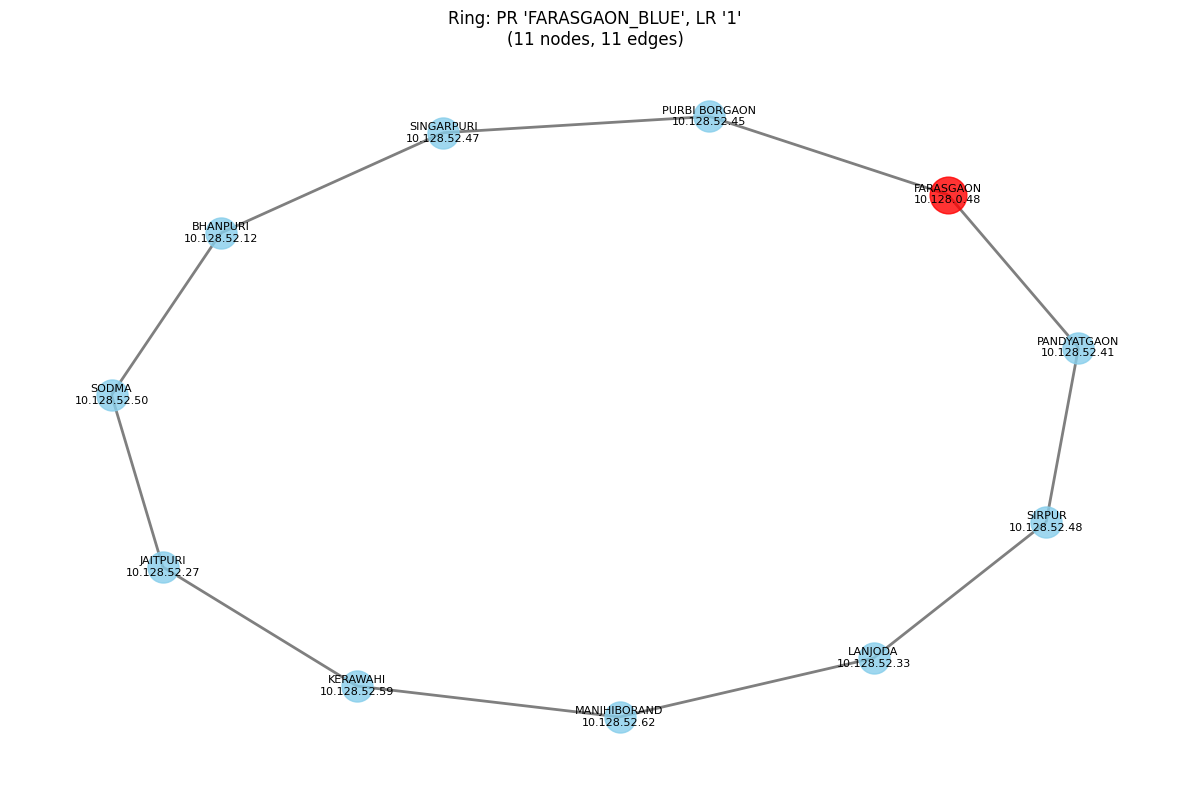

In [46]:
visualize_random_ring(ring_nodes)

In [47]:
import torch
import random
import networkx as nx
import numpy as np
from torch_geometric.data import Dataset, Data
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy


In [48]:
import re

In [49]:

class NetworkIsolationDataset(Dataset):
    def __init__(self, base_graph, block_router_ips, ring_nodes, num_samples=1000, 
                 min_failures=1, max_failures=5, failure_prob=0.5, 
                 include_edge_failures=True, transform=None):
        """
        Dataset for training a GNN to predict node isolation from block routers.
        
        Args:
            base_graph: NetworkX graph representing the network topology
            block_router_ips: Set of IPs that are block routers
            num_samples: Number of scenarios to generate
            min_failures, max_failures: Range of number of failures to simulate per sample
            failure_prob: Probability of choosing node failures (vs edge failures)
            include_edge_failures: Whether to include edge failures in the scenarios
            transform: PyTorch Geometric transforms
        """
        super(NetworkIsolationDataset, self).__init__(transform)
        self.base_graph = base_graph
        self.block_router_ips = block_router_ips
        self.ring_nodes = ring_nodes
        self.num_samples = num_samples
        self.min_failures = min_failures
        self.max_failures = max_failures
        self.failure_prob = failure_prob
        self.include_edge_failures = include_edge_failures
        
        # Generate all samples at initialization
        self.samples = []
        self._generate_samples()
    
    def _generate_samples(self):
        """Generate samples with failures targeting existing ring_nodes for more isolations"""
        print("Generating network isolation samples...")
        
        # Use the existing ring_nodes dictionary instead of recreating it
        # Assuming ring_nodes is passed to the __init__ method as an additional parameter
        valid_rings = {k: list(v.nodes()) for k, v in self.ring_nodes.items() if v.number_of_nodes() >= 3}
        print(f"Found {len(valid_rings)} valid rings for targeted failures")
        
        sample_count = 0
        attempts = 0
        max_attempts = self.num_samples * 3  # Allow more attempts to get enough good samples
        
        while sample_count < self.num_samples and attempts < max_attempts:
            attempts += 1
            
            # Create a working copy of the graph
            graph_copy = copy.deepcopy(self.base_graph)
            
            # Randomly select number of failures for this sample
            num_failures = random.randint(self.min_failures, self.max_failures)
            
            # Track failures
            failed_nodes = set()
            failed_edges = set()
            
            # 80% of the time, target failures within a single ring to create more isolations
            if random.random() < 0.8 and valid_rings:
                # Choose a random ring to target
                target_ring_key = random.choice(list(valid_rings.keys()))
                target_ring_nodes = valid_rings[target_ring_key]
                
                # Get all edges within this ring
                ring_edges = []
                for u, v in graph_copy.edges():
                    if u in target_ring_nodes and v in target_ring_nodes:
                        ring_edges.append((u, v))
                
                # Choose more aggressively from this ring
                for _ in range(num_failures):
                    # Decide whether to fail a node or an edge
                    if not self.include_edge_failures or random.random() < self.failure_prob:
                        # Node failure - prioritize ring nodes that aren't block routers
                        available_nodes = [n for n in target_ring_nodes 
                                        if n not in self.block_router_ips 
                                        and n not in failed_nodes]
                        
                        if available_nodes and random.random() < 0.8:  # 80% chance to choose from target ring
                            failed_node = random.choice(available_nodes)
                        else:  # Fall back to any available node
                            available_nodes = [n for n in graph_copy.nodes() 
                                            if n not in self.block_router_ips 
                                            and n not in failed_nodes]
                            if available_nodes:
                                failed_node = random.choice(available_nodes)
                            else:
                                continue
                        
                        failed_nodes.add(failed_node)
                        graph_copy.nodes[failed_node]['failed'] = True
                    
                    else:
                        # Edge failure - prioritize ring edges
                        if ring_edges and random.random() < 0.8:  # 80% chance to choose from target ring
                            available_edges = [e for e in ring_edges 
                                            if e not in failed_edges and (e[1], e[0]) not in failed_edges]
                            if available_edges:
                                u, v = random.choice(available_edges)
                            else:
                                available_edges = [(u, v) for u, v in graph_copy.edges() 
                                                if (u, v) not in failed_edges and (v, u) not in failed_edges]
                                if available_edges:
                                    u, v = random.choice(available_edges)
                                else:
                                    continue
                        else:
                            available_edges = [(u, v) for u, v in graph_copy.edges() 
                                            if (u, v) not in failed_edges and (v, u) not in failed_edges]
                            if available_edges:
                                u, v = random.choice(available_edges)
                            else:
                                continue
                        
                        failed_edges.add((u, v))
                        graph_copy.edges[u, v]['failed'] = True
            
            else:
                # Standard random failure approach (as before)
                for _ in range(num_failures):
                    # Decide whether to fail a node or an edge
                    if not self.include_edge_failures or random.random() < self.failure_prob:
                        # Node failure
                        available_nodes = [n for n in graph_copy.nodes() 
                                        if n not in self.block_router_ips 
                                        and n not in failed_nodes]
                        
                        if available_nodes:
                            failed_node = random.choice(available_nodes)
                            failed_nodes.add(failed_node)
                            graph_copy.nodes[failed_node]['failed'] = True
                    
                    else:
                        # Edge failure
                        available_edges = [(u, v) for u, v in graph_copy.edges() 
                                        if (u, v) not in failed_edges and (v, u) not in failed_edges]
                        
                        if available_edges:
                            u, v = random.choice(available_edges)
                            failed_edges.add((u, v))
                            graph_copy.edges[u, v]['failed'] = True
            
            # Remove failed nodes from the graph for isolation analysis
            isolation_graph = graph_copy.copy()
            isolation_graph.remove_nodes_from(failed_nodes)
            
            # Remove failed edges from the graph for isolation analysis
            for u, v in failed_edges:
                if isolation_graph.has_edge(u, v):
                    isolation_graph.remove_edge(u, v)
            
            # Find isolated nodes (those that can't reach their block router)
            isolated_nodes = set()
            for node in isolation_graph.nodes():
                if node in self.block_router_ips:
                    continue  # Skip block routers
                
                # Find this node's block_ip (which block it belongs to)
                block_ip = graph_copy.nodes[node].get('block_ip')
                if not block_ip:
                    continue  # Skip nodes without block assignment
                
                # Check if node can reach its block router
                if block_ip in isolation_graph.nodes() and not nx.has_path(isolation_graph, node, block_ip):
                    isolated_nodes.add(node)
            
            # Only keep samples that have at least one isolated node (optional)
            if not isolated_nodes and random.random() < 0.7:  # 70% chance to skip non-isolation cases
                continue  # Skip this sample, try again
                
            # Convert to PyG Data format
            data = self._create_pyg_data(graph_copy, failed_nodes, failed_edges, isolated_nodes)
            self.samples.append(data)
            sample_count += 1
            
            # Progress update
            if sample_count % 100 == 0:
                print(f"Generated {sample_count} samples so far...")
        
        # Report statistics
        total_isolated = sum(torch.sum(sample.y).item() for sample in self.samples)
        total_nodes = sum(sample.y.shape[0] for sample in self.samples)
        print(f"Generated {len(self.samples)} samples after {attempts} attempts")
        print(f"Total nodes: {total_nodes}, Isolated nodes: {total_isolated} ({100.0*total_isolated/total_nodes:.2f}%)")
    
    def _create_pyg_data(self, graph, failed_nodes, failed_edges, isolated_nodes):
        """Convert NetworkX graph and failure information to PyG Data format"""
        # Create edge index tensor
        node_to_idx = {node: i for i, node in enumerate(graph.nodes())}

        edge_list = list(graph.edges())
        edge_index = torch.tensor([
        [node_to_idx[u], node_to_idx[v]] for u, v in edge_list
        ], dtype=torch.long).t().contiguous()
        
        # Create node feature matrix
        # Features: [is_block_router, is_failed]
        x = torch.zeros((graph.number_of_nodes(), 2), dtype=torch.float)
        
        # Create node mapping for easier indexing
        node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
        
        # Set node features
        for node, idx in node_to_idx.items():
            # is_block_router
            x[idx, 0] = 1.0 if node in self.block_router_ips else 0.0
            # is_failed
            x[idx, 1] = 1.0 if node in failed_nodes else 0.0
        
        # Create edge feature matrix
        # Features: [is_failed]
        edge_attr = torch.zeros((len(edge_list), 1), dtype=torch.float)
        
        # Set edge features
        for i, (u, v) in enumerate(edge_list):
            edge_attr[i, 0] = 1.0 if (u, v) in failed_edges or (v, u) in failed_edges else 0.0
        
        # Create label tensor (1 for isolated nodes, 0 for connected nodes)
        y = torch.zeros(graph.number_of_nodes(), dtype=torch.float)
        for node in isolated_nodes:
            if node in node_to_idx:  # Make sure node exists (wasn't removed)
                y[node_to_idx[node]] = 1.0
        
        # Create PyG Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        
        # Store the original node IDs for reference
        data.node_ids = list(graph.nodes())
        data.failed_nodes = list(failed_nodes)
        data.failed_edges = list(failed_edges)
        data.isolated_nodes = list(isolated_nodes)
        
        return data
    
    def len(self):
        return len(self.samples)
    
    def get(self, idx):
        return self.samples[idx]


    def visualize_sample(self, idx):
        """
        Visualize a specific sample, focusing only on the logical ring
        containing isolated nodes. Places block routers at the north position.
        """
        data = self.samples[idx]
        
        # Reconstruct full graph first
        G = nx.Graph()
        
        # Add nodes with their properties
        for i, node_id in enumerate(data.node_ids):
            is_block = bool(data.x[i, 0])
            is_failed = bool(data.x[i, 1])
            is_isolated = bool(data.y[i])
            
            # Get original node attributes from base graph
            original_attrs = {}
            if self.base_graph.has_node(node_id):
                original_attrs = self.base_graph.nodes[node_id]
            
            # Normalize LR name the same way as in get_ring_node_mapping
            lr_name_original = original_attrs.get('lr_name')
            lr_name_normalized = None
            if lr_name_original:
                # Enhanced regex to capture numbers after various separators or at the end
                number_match = re.search(r'(?:no\.?|[-\s]|RING-|RING\s*)(\d+)', lr_name_original, re.IGNORECASE)
                if not number_match:  # Try finding number at the end if first regex failed
                    number_match = re.search(r'(\d+)$', lr_name_original)

                if number_match:
                    lr_name_normalized = str(int(number_match.group(1)))
            
            # Add all attributes with normalized LR name
            G.add_node(node_id, 
                    is_block=is_block, 
                    is_failed=is_failed, 
                    is_isolated=is_isolated,
                    pr_name=original_attrs.get('pr_name', 'unknown'),
                    lr_name_original=lr_name_original,
                    lr_name=lr_name_normalized,  # Store normalized version for matching
                    block_ip=original_attrs.get('block_ip', None),
                    name=original_attrs.get('name', f"Node-{node_id}"))
        
        # Add edges
        edge_idx = data.edge_index.t().numpy()
        for i, (src_idx, dst_idx) in enumerate(edge_idx):
            src_id = data.node_ids[src_idx]
            dst_id = data.node_ids[dst_idx]
            is_failed = bool(data.edge_attr[i, 0])
            
            G.add_edge(src_id, dst_id, is_failed=is_failed)
        
        # Find rings with isolated nodes
        isolated_rings = set()
        isolated_node_list = data.isolated_nodes
        
        if not isolated_node_list:
            print("No isolated nodes in this sample, showing a random ring instead.")
            # Get a random ring from any node
            random_node = random.choice(list(G.nodes()))
            if G.has_node(random_node):
                ring_key = (G.nodes[random_node].get('pr_name', 'unknown'), 
                        G.nodes[random_node].get('lr_name', 'unknown'))
                isolated_rings.add(ring_key)
        else:
            # Find rings containing isolated nodes
            for node in isolated_node_list:
                if G.has_node(node):
                    pr_name = G.nodes[node].get('pr_name', 'unknown')
                    lr_name = G.nodes[node].get('lr_name', 'unknown')  # Using the normalized version
                    if pr_name != 'unknown' and lr_name != 'unknown':
                        isolated_rings.add((pr_name, lr_name))
        
        # If no valid rings found, use the whole graph
        if not isolated_rings or all(k[0] == 'unknown' for k in isolated_rings):
            print("Couldn't identify specific rings, showing entire graph.")
            ring_subgraph = G
            ring_name = "Multiple/Unknown Rings"
        else:
            # Select the first isolated ring for visualization
            target_ring = list(isolated_rings)[0]
            ring_name = f"PR: {target_ring[0]}, LR: {target_ring[1]}"
            print(f"Focusing on ring: {ring_name}")
            
            # Get all nodes in this ring using normalized LR name
            ring_nodes = [n for n, d in G.nodes(data=True) 
                        if d.get('pr_name') == target_ring[0] and d.get('lr_name') == target_ring[1]]
            
            # Add block routers connected to these nodes
            block_ips = set()
            for node in ring_nodes:
                block_ip = G.nodes[node].get('block_ip')
                if block_ip and G.has_node(block_ip):
                    block_ips.add(block_ip)
            
            # Create the focused subgraph
            nodes_to_include = set(ring_nodes) | block_ips
            
            # Check if we have enough nodes for a meaningful visualization
            if len(nodes_to_include) < 3:
                print(f"Ring {ring_name} has too few nodes, showing entire graph.")
                ring_subgraph = G
            else:
                ring_subgraph = G.subgraph(nodes_to_include).copy()
        
        # Visualize the ring subgraph
        plt.figure(figsize=(12, 10))
        
        # Create a custom circular layout with block router at the top (north position)
        # First get the standard circular layout
        pos = nx.circular_layout(ring_subgraph)
        
        # Identify block routers
        block_nodes = [n for n, d in ring_subgraph.nodes(data=True) if d.get('is_block', False)]
        
        # If we have block routers, adjust the layout so the first one is at the top
        if block_nodes:
            # Get the current position of the first block router
            block_node = block_nodes[0]
            block_pos = pos[block_node]
            
            # Calculate angle to rotate the entire layout
            current_angle = np.arctan2(block_pos[1], block_pos[0])
            target_angle = np.pi/2  # 90 degrees (top)
            rotation_angle = target_angle - current_angle
            
            # Rotate all positions
            for node in pos:
                x, y = pos[node]
                # Rotate the point
                new_x = x * np.cos(rotation_angle) - y * np.sin(rotation_angle)
                new_y = x * np.sin(rotation_angle) + y * np.cos(rotation_angle)
                pos[node] = np.array([new_x, new_y])
        
        # Draw different node types
        failed_nodes = [n for n, d in ring_subgraph.nodes(data=True) if d.get('is_failed', False)]
        isolated_nodes = [n for n, d in ring_subgraph.nodes(data=True) 
                        if d.get('is_isolated', False) and not d.get('is_failed', False)]
        normal_nodes = [n for n, d in ring_subgraph.nodes(data=True) 
                    if not d.get('is_block', False) and not d.get('is_failed', False) 
                    and not d.get('is_isolated', False)]
        
        # Draw normal nodes
        if normal_nodes:
            nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=normal_nodes, 
                                node_color='blue', node_size=300, alpha=0.7,
                                label='Normal Nodes')
        
        # Draw block routers
        if block_nodes:
            nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=block_nodes, 
                                node_color='red', node_size=500, alpha=0.8,
                                label='Block Routers')
        
        # Draw failed nodes
        if failed_nodes:
            nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=failed_nodes, 
                                node_color='black', node_size=300, alpha=0.8,
                                label='Failed Nodes')
        
        # Draw isolated nodes
        if isolated_nodes:
            nx.draw_networkx_nodes(ring_subgraph, pos, nodelist=isolated_nodes, 
                                node_color='yellow', node_size=300, alpha=0.8,
                                label='Isolated Nodes')
        
        # Draw edges
        working_edges = [(u, v) for u, v, d in ring_subgraph.edges(data=True) if not d.get('is_failed', False)]
        failed_edges = [(u, v) for u, v, d in ring_subgraph.edges(data=True) if d.get('is_failed', False)]
        
        nx.draw_networkx_edges(ring_subgraph, pos, edgelist=working_edges, width=1.0, alpha=0.5)
        nx.draw_networkx_edges(ring_subgraph, pos, edgelist=failed_edges, width=1.5, 
                            alpha=0.7, style='dashed', edge_color='red', label='Failed Links')
        
        # Draw labels with more useful information
        labels = {node: f"{ring_subgraph.nodes[node].get('name', '').split('-')[-1]}\n{str(node).split('.')[-1]}" 
                for node in ring_subgraph.nodes()}
        
        nx.draw_networkx_labels(ring_subgraph, pos, labels=labels, font_size=8)
        
        # Add title with more detail
        plt.title(f"Sample {idx}: Ring {ring_name}\n"
                f"{len(data.failed_nodes)} failed nodes, {len(data.failed_edges)} failed edges, "
                f"{len(data.isolated_nodes)} isolated nodes")
        plt.legend()
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print details
        print(f"Sample {idx} details:")
        print(f"Failed nodes: {data.failed_nodes}")
        print(f"Failed edges: {data.failed_edges}")
        print(f"Isolated nodes: {data.isolated_nodes}")
        
        # Print information about why isolation occurred
        if isolated_nodes:
            print("\nIsolation analysis:")
            for node in isolated_nodes:
                block_ip = G.nodes[node].get('block_ip', 'unknown')
                print(f"Node {node} (in ring {G.nodes[node].get('pr_name', 'unknown')}, "
                    f"{G.nodes[node].get('lr_name_original', 'unknown')}) is isolated from block router {block_ip}")




In [50]:
dataset = NetworkIsolationDataset(
    base_graph=topology_logical_graph,
    block_router_ips=block_router_ips,
    ring_nodes=ring_nodes,  # Use your existing ring_nodes dictionary
    num_samples=1000,
    min_failures=2,    # Increase minimum failures
    max_failures=6,    # Increase maximum failures
    failure_prob=0.6   # 60% probability of node failures vs edge failures
)

Generating network isolation samples...
Found 114 valid rings for targeted failures
Generated 100 samples so far...
Generated 200 samples so far...


KeyboardInterrupt: 

Focusing on ring: PR: BAKAWAND_BLUE, LR: 3


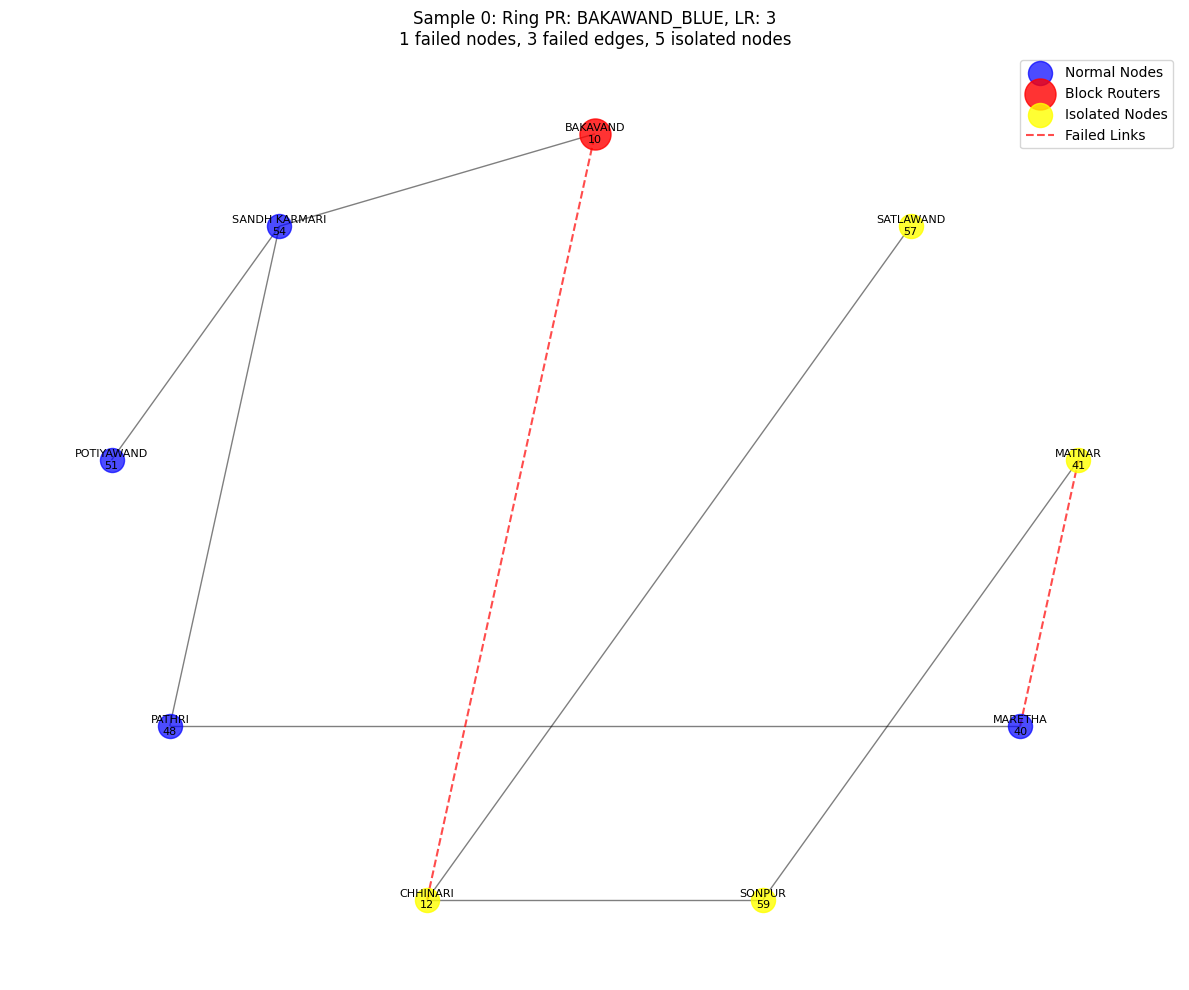

Sample 0 details:
Failed nodes: ['10.128.93.48']
Failed edges: [('10.128.10.40', '10.128.10.41'), ('10.128.0.10', '10.128.10.12'), ('10.128.8.42', '10.131.9.254')]
Isolated nodes: ['10.128.10.12', '10.128.10.59', '10.128.10.41', '10.128.10.57', '10.128.93.6']

Isolation analysis:
Node 10.128.10.12 (in ring BAKAWAND_BLUE, RING NO.03SPUR) is isolated from block router 10.128.0.10
Node 10.128.10.59 (in ring BAKAWAND_BLUE, RING NO.03) is isolated from block router 10.128.0.10
Node 10.128.10.41 (in ring BAKAWAND_BLUE, RING NO.03) is isolated from block router 10.128.0.10
Node 10.128.10.57 (in ring BAKAWAND_BLUE, RING NO.03SPUR) is isolated from block router 10.128.0.10


In [45]:
dataset.visualize_sample(0)

In [36]:
dataset[0]

Data(x=[1684, 2], edge_index=[2, 1780], edge_attr=[1780, 1], y=[1684], node_ids=[1684], failed_nodes=[0], failed_edges=[2], isolated_nodes=[1])

In [137]:
def predict_isolation_from_graph(model, graph):
    """
    Make predictions using the trained model directly from a NetworkX graph.
    Takes failed nodes and edges from the 'failed' attribute.
    
    Args:
        model: Trained IsolationGNN model
        graph: NetworkX graph with 'failed' attributes on nodes and edges
        
    Returns:
        predicted_isolated: List of node IDs predicted to be isolated
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Extract failed nodes and edges from attributes
    failed_nodes = [n for n, attrs in graph.nodes(data=True) if attrs.get('failed', False)]
    failed_edges = [(u, v) for u, v, attrs in graph.edges(data=True) if attrs.get('failed', False)]

    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
    
    # Create node features: [is_block_router, is_failed]
    x = torch.zeros((len(graph.nodes()), 2), dtype=torch.float)
    for node, idx in node_to_idx.items():
        # is_block_router (assuming block routers have a 'is_block' or similar attribute)
        x[idx, 0] = 1.0 if graph.nodes[node].get('is_block', False) else 0.0
        # is_failed
        x[idx, 1] = 1.0 if node in failed_nodes else 0.0
    
    # Create edge index
    edge_list = list(graph.edges())
    edge_index = torch.tensor([
        [node_to_idx[u], node_to_idx[v]] for u, v in edge_list
    ], dtype=torch.long).t().contiguous()
    
    # Create edge features: [is_failed]
    edge_attr = torch.zeros((len(edge_list), 1), dtype=torch.float)
    for i, (u, v) in enumerate(edge_list):
        edge_attr[i, 0] = 1.0 if (u, v) in failed_edges or (v, u) in failed_edges else 0.0
    
    # Store original node IDs for reference
    node_ids = list(graph.nodes())
    
    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.node_ids = node_ids
    
    # Move to device and predict
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
        print(out)
        pred = (out > 0.5).float()
    
    # Get node IDs that are predicted as isolated
    predicted_isolated = []
    for i, node_id in enumerate(node_ids):
        # Skip block routers and failed nodes
        if x[i, 0] > 0.5 or x[i, 1] > 0.5:  # is_block or is_failed
            continue
            
        # Check if this node is predicted as isolated
        if pred[i] > 0.5:
            predicted_isolated.append(node_id)
    
    return predicted_isolated

In [51]:
def mark_failures_in_graph(graph, failed_nodes, failed_edges):
    """
    Marks specified nodes and edges as failed in a NetworkX graph.
    
    Args:
        graph: NetworkX graph to modify
        failed_nodes: List of node IDs to mark as failed
        failed_edges: List of (u, v) edge tuples to mark as failed
        
    Returns:
        Modified graph with failure attributes set
    """
    # Mark failed nodes
    for node in failed_nodes:
        if graph.has_node(node):
            graph.nodes[node]['failed'] = True
    
    # Mark failed edges
    for u, v in failed_edges:
        if graph.has_edge(u, v):
            graph.edges[u, v]['failed'] = True
    
    return graph

In [52]:
mark_failures_in_graph(topology_logical_graph,['10.128.10.9','10.128.10.21'],[])

In [202]:
subgraph.nodes['10.128.10.9']['failed'] = False

In [53]:
failed_nodes = [node for node, attrs in topology_logical_graph.nodes(data=True) if attrs.get('failed', False)]
print("Failed nodes:", failed_nodes)


Failed nodes: ['10.128.10.9', '10.128.10.21']


In [54]:
ring_nodes

{('GEEDAM_BLUE', '1'): <networkx.classes.graph.Graph at 0x7906d044a570>,
 ('GEEDAM_BLUE', '2'): <networkx.classes.graph.Graph at 0x7906d044a4e0>,
 ('GEEDAM_ORANGE', '3'): <networkx.classes.graph.Graph at 0x7906d044a600>,
 ('GEEDAM_ORANGE', '4'): <networkx.classes.graph.Graph at 0x7906d0449fd0>,
 ('JAGDALPUR_BLUE', '1'): <networkx.classes.graph.Graph at 0x7906d044a690>,
 ('JAGDALPUR_BLUE', '2'): <networkx.classes.graph.Graph at 0x7906d044a330>,
 ('JAGDALPUR_ORANGE', '3'): <networkx.classes.graph.Graph at 0x7906d044b5c0>,
 ('JAGDALPUR_ORANGE', '4'): <networkx.classes.graph.Graph at 0x7906d044b530>,
 ('JAGDALPUR_ORANGE', '5'): <networkx.classes.graph.Graph at 0x7906d044b380>,
 ('JAGDALPUR_PINK', '6'): <networkx.classes.graph.Graph at 0x7906d044b2f0>,
 ('JAGDALPUR_PINK', '7'): <networkx.classes.graph.Graph at 0x7906d044b650>,
 ('KESHKAL_BLUE', '1'): <networkx.classes.graph.Graph at 0x7906d044b6e0>,
 ('KESHKAL_BLUE', '2'): <networkx.classes.graph.Graph at 0x7906d044b770>,
 ('KESHKAL_ORANGE'

In [142]:
ring_nodes[('BAKAWAND_PINK', '6')].nodes()

NodeView(('10.128.10.7', '10.128.10.35', '10.128.10.21', '10.128.10.27', '10.128.10.9', '10.128.0.10'))

In [55]:
graph = ring_nodes[('BAKAWAND_PINK', '6')]

In [152]:
graph.edges()

EdgeView([('10.128.10.7', '10.128.10.35'), ('10.128.10.7', '10.128.10.27'), ('10.128.10.35', '10.128.10.9'), ('10.128.10.21', '10.128.10.27'), ('10.128.10.21', '10.128.0.10'), ('10.128.10.9', '10.128.0.10')])

In [56]:
mark_failures_in_graph(graph,['10.128.10.9','10.128.10.21'],[])

In [61]:
print("Graph attributes:")
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")
print("\nNode attributes:")
for node, attrs in graph.nodes(data=True):
    print(f"Node {node}: {attrs}")
print("\nEdge attributes:")
for u, v, attrs in graph.edges(data=True):
    print(f"Edge {u} -> {v}: {attrs}")


Graph attributes:
Number of nodes: 6
Number of edges: 6

Node attributes:
Node 10.128.10.7: {'name': 'BEDAUMARGAON', 'lr_name': 'RING NO.06', 'pr_name': 'BAKAWAND_PINK', 'block_name': 'BAKAWAND', 'block_ip': '10.128.0.10'}
Node 10.128.10.9: {'name': 'BHEJRIPADAR', 'lr_name': 'RING NO.06', 'pr_name': 'BAKAWAND_PINK', 'block_name': 'BAKAWAND', 'block_ip': '10.128.0.10', 'failed': True}
Node 10.128.0.10: {'name': 'BAKAVAND', 'lr_name': 'RING NO.06', 'pr_name': 'BAKAWAND_PINK', 'block_name': 'BAKAWAND', 'is_block': True, 'block_ip': '10.128.0.10'}
Node 10.128.10.27: {'name': 'JHARUMARGAON', 'lr_name': 'RING NO.06', 'pr_name': 'BAKAWAND_PINK', 'block_name': 'BAKAWAND', 'block_ip': '10.128.0.10'}
Node 10.128.10.21: {'name': 'DHOBIGUDA', 'lr_name': 'RING NO.06', 'pr_name': 'BAKAWAND_PINK', 'block_name': 'BAKAWAND', 'block_ip': '10.128.0.10', 'failed': True}
Node 10.128.10.35: {'name': 'KOSMI', 'lr_name': 'RING NO.06', 'pr_name': 'BAKAWAND_PINK', 'block_name': 'BAKAWAND', 'block_ip': '10.128.0

In [57]:
failed_nodes = [node for node, attrs in graph.nodes(data=True) if attrs.get('failed', False)]

print("Failed nodes:", failed_nodes)


Failed nodes: ['10.128.10.9', '10.128.10.21']


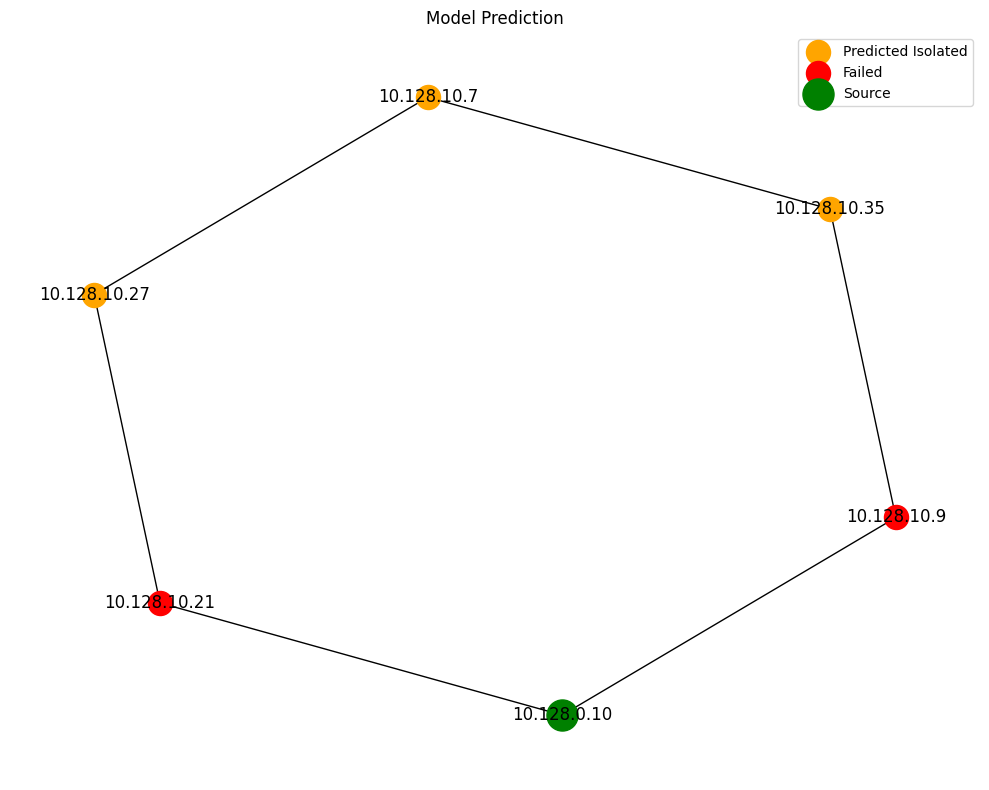

Failed nodes: ['10.128.10.9', '10.128.10.21']
Failed edges: []
Predicted isolated nodes: ['10.128.10.7', '10.128.10.27', '10.128.10.35']


(Data(
   x=[6, 2],
   edge_index=[2, 12],
   edge_attr=[12, 1],
   failed_nodes=[2],
   failed_edges=[0],
   node_mapping={
     0='10.128.10.7',
     1='10.128.10.9',
     2='10.128.0.10',
     3='10.128.10.27',
     4='10.128.10.21',
     5='10.128.10.35',
   }
 ),
 tensor([1., 1., 1., 1., 1., 1.]))

In [64]:
test_model_with_custom_failures(model,graph)

In [93]:
component_nodes = nx.node_connected_component(topology_logical_graph, '10.128.0.10')

# Create a subgraph containing only those nodes
subgraph = topology_logical_graph.subgraph(component_nodes).copy()

# Optional: check number of nodes/edges in the subgraph
print(f"Subgraph has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")

Subgraph has 130 nodes and 137 edges


In [203]:
subgraph.nodes['10.128.10.9']['failed'] = False

In [200]:
def analyze_ring_structure(graph, source_node_id=0):
    """
    Analyzes a graph to identify rings and count nodes per ring.
    
    Args:
        graph: NetworkX graph with a multi-ring structure
        source_node_id: ID of the source/block node that connects rings
    
    Returns:
        num_rings: Number of rings in the graph
        rings_info: Dictionary with ring ID and number of nodes per ring
    """
    if not graph.has_node(source_node_id):
        print(f"Source node {source_node_id} not found in graph")
        return 0, {}
    
    # Get all neighbors of the source node
    source_neighbors = list(graph.neighbors(source_node_id))
    
    # Remove the source node to analyze the remaining components
    temp_graph = graph.copy()
    temp_graph.remove_node(source_node_id)
    
    # Get connected components (each should be part of a ring)
    components = list(nx.connected_components(temp_graph))
    
    # Initialize ring information
    rings_info = {}
    ring_id = 0
    
    # For each component, check if it forms a ring with the source
    for component in components:
        # Find nodes in this component that were connected to source
        entry_points = [n for n in component if n in source_neighbors]
        
        # If component has two connections to source, it's a ring
        if len(entry_points) >= 2:
            ring_id += 1
            # Count nodes in this ring (excluding source)
            ring_size = len(component)
            rings_info[ring_id] = {
                'nodes': list(component),
                'size': ring_size,
                'entry_points': entry_points
            }
    
    num_rings = len(rings_info)
    
    # Print summary
    print(f"Found {num_rings} rings connected to source node {source_node_id}")
    for ring_id, info in rings_info.items():
        print(f"Ring {ring_id}: {info['size']} nodes")
        # Uncomment to see detailed node information
        # print(f"  Nodes: {info['nodes']}")
        # print(f"  Connected to source at: {info['entry_points']}")
    
    return num_rings, rings_info

# Example usage
num_rings, rings_info = analyze_ring_structure(subgraph, source_node_id='10.128.0.10')

# To get the total number of non-source nodes in the graph
total_ring_nodes = sum(info['size'] for info in rings_info.values())
print(f"Total nodes in rings: {total_ring_nodes}")

# To check if UPS nodes are included
ups_nodes = [n for n, attrs in G.nodes(data=True) if attrs.get('is_ups', False)]
print(f"Number of UPS nodes: {len(ups_nodes)}")

Found 8 rings connected to source node 10.128.0.10
Ring 1: 16 nodes
Ring 2: 14 nodes
Ring 3: 14 nodes
Ring 4: 10 nodes
Ring 5: 16 nodes
Ring 6: 18 nodes
Ring 7: 19 nodes
Ring 8: 20 nodes
Total nodes in rings: 127
Number of UPS nodes: 81


In [201]:
num_rings, rings_info = analyze_ring_structure(G, 0)

# To get the total number of non-source nodes in the graph
total_ring_nodes = sum(info['size'] for info in rings_info.values())
print(f"Total nodes in rings: {total_ring_nodes}")

# To check if UPS nodes are included
ups_nodes = [n for n, attrs in G.nodes(data=True) if attrs.get('is_ups', False)]
print(f"Number of UPS nodes: {len(ups_nodes)}")

Found 10 rings connected to source node 0
Ring 1: 16 nodes
Ring 2: 16 nodes
Ring 3: 16 nodes
Ring 4: 16 nodes
Ring 5: 16 nodes
Ring 6: 16 nodes
Ring 7: 16 nodes
Ring 8: 16 nodes
Ring 9: 16 nodes
Ring 10: 16 nodes
Total nodes in rings: 160
Number of UPS nodes: 81


In [220]:
subgraph.nodes['10.128.10.15']['failed'] = True
subgraph.nodes['10.128.10.4']['failed'] = True

In [221]:
failed_nodes = [node for node, attrs in subgraph.nodes(data=True) if attrs.get('failed', False)]

print("Failed nodes:", failed_nodes)


Failed nodes: ['10.128.10.15', '10.128.10.7', '10.128.10.4', '10.128.10.21']


tensor([2.4182e-06, 8.9523e-32, 1.8140e-06, 1.1144e-05, 1.9477e-31, 9.9966e-01,
        1.0358e-14, 1.3716e-37, 0.0000e+00, 6.2674e-08, 4.3040e-30, 2.9905e-21,
        0.0000e+00, 1.1370e-19, 0.0000e+00, 0.0000e+00, 5.8369e-12, 0.0000e+00,
        3.0592e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.9905e-21, 8.5839e-32, 0.0000e+00, 9.9930e-01, 2.6181e-27, 0.0000e+00,
        6.6156e-16, 1.3098e-15, 1.8140e-06, 6.6155e-16, 8.9908e-24, 3.5590e-37,
        1.4416e-21, 6.6152e-27, 1.0582e-14, 3.6203e-26, 0.0000e+00, 1.1742e-30,
        7.6642e-13, 1.7097e-11, 2.7944e-12, 8.9523e-32, 9.8628e-12, 4.9864e-12,
        9.6432e-01, 0.0000e+00, 1.9477e-31, 3.7621e-24, 1.0358e-14, 0.0000e+00,
        1.0436e-25, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9864e-12, 0.0000e+00,
        1.7874e-07, 1.1144e-05, 8.1459e-06, 3.6739e-24, 8.2348e-36, 0.0000e+00,
        0.0000e+00, 1.1742e-30, 9.9930e-01, 1.4380e-07, 6.2152e-26, 0.0000e+00,
        9.8629e-12, 0.0000e+00, 3.3344e-

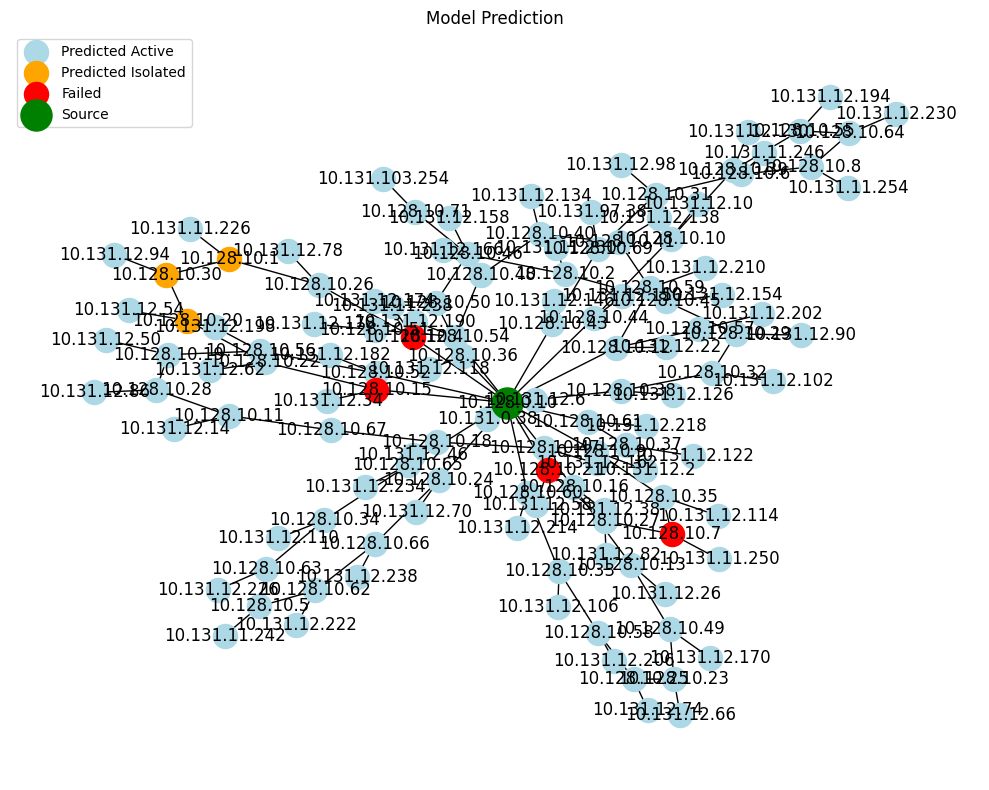

Failed nodes: ['10.128.10.15', '10.128.10.7', '10.128.10.4', '10.128.10.21']
Failed edges: []
Predicted isolated nodes: ['10.128.10.30', '10.128.10.1', '10.128.10.20']


(Data(
   x=[130, 3],
   edge_index=[2, 274],
   edge_attr=[274, 1],
   failed_nodes=[4],
   failed_edges=[0],
   node_mapping={
     0='10.131.12.202',
     1='10.131.12.6',
     2='10.131.12.54',
     3='10.128.10.26',
     4='10.128.10.15',
     5='10.128.10.30',
     6='10.131.12.210',
     7='10.128.10.48',
     8='10.128.10.62',
     9='10.131.12.82',
     10='10.131.12.74',
     11='10.131.12.134',
     12='10.128.10.65',
     13='10.131.103.254',
     14='10.128.10.47',
     15='10.128.10.45',
     16='10.131.12.126',
     17='10.128.10.44',
     18='10.128.10.35',
     19='10.128.10.29',
     20='10.128.10.18',
     21='10.128.10.69',
     22='10.128.10.36',
     23='10.128.10.10',
     24='10.131.12.138',
     25='10.131.12.154',
     26='10.128.10.6',
     27='10.128.10.1',
     28='10.131.11.242',
     29='10.128.10.60',
     30='10.131.12.110',
     31='10.131.12.26',
     32='10.131.11.226',
     33='10.131.12.238',
     34='10.131.12.50',
     35='10.128.10.37',
     36=

In [222]:
test_model_with_custom_failures_with_ups(model_multi_ring_with_ups,subgraph)